
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train MC and SARSA 
    - Compare which one performs better in training
    - Compare which one performs better on Test time period


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [20]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import sarsa_single_stock, on_policy_mc_control_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [2]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [3]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [4]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254782,-80.462476,16.129793,2.749560,2.861671,"[[0.0013489701053628017, 0.0004284136887189974...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839520,6287200,AMGN,2,0.156756,42.707036,40.853192,51.060611,51.523305,10.432018,41.058035,40.603776,"[[0.0013489701053628017, 0.0004284136887189974...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580753,9625600,AXP,2,-0.935582,18.646870,12.660474,42.554856,-75.437613,25.776759,15.744065,17.616374,"[[0.0013489701053628017, 0.0004284136887189974...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005882,5443100,BA,2,-0.279800,32.174386,28.867834,47.440225,156.994574,5.366299,30.327214,32.389916,"[[0.0013489701053628017, 0.0004284136887189974...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608654,6277400,CAT,2,0.655611,30.348090,25.455644,51.205305,98.374144,26.331746,26.689550,26.423592,"[[0.0013489701053628017, 0.0004284136887189974...",tic AAPL AMGN AXP ...


In [5]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [6]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [7]:
EPISODES = 1000

In [8]:
sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [9]:
sarsa_post_training_env, sarsa_training_episodes, sarsa_Q = sarsa_single_stock(sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0)

Episode:   0%|          | 1/1000 [00:05<1:34:56,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8612408.772428846
Sharpe:  1.1862438751971256


Episode:   0%|          | 2/1000 [00:11<1:33:18,  5.61s/it]

begin_total_asset:1000000
end_total_asset:6189811.560351245
Sharpe:  1.03522733772496


Episode:   0%|          | 3/1000 [00:16<1:31:19,  5.50s/it]

begin_total_asset:1000000
end_total_asset:7367839.291122264
Sharpe:  1.10380873253977


Episode:   0%|          | 4/1000 [00:21<1:30:27,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6374880.558856018
Sharpe:  1.1070366974740282


Episode:   0%|          | 5/1000 [00:27<1:30:02,  5.43s/it]

begin_total_asset:1000000
end_total_asset:9950855.387127088
Sharpe:  1.280701252589045


Episode:   1%|          | 6/1000 [00:32<1:29:42,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5991906.010990613
Sharpe:  1.0450908353731723


Episode:   1%|          | 7/1000 [00:38<1:29:50,  5.43s/it]

begin_total_asset:1000000
end_total_asset:10087739.332827996
Sharpe:  1.3098386600750636


Episode:   1%|          | 8/1000 [00:43<1:30:13,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6811435.890819335
Sharpe:  1.1169928372059104


Episode:   1%|          | 9/1000 [00:49<1:29:37,  5.43s/it]

begin_total_asset:1000000
end_total_asset:9023646.514015414
Sharpe:  1.1387811073817298


Episode:   1%|          | 10/1000 [00:54<1:29:01,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4122725.531131363
Sharpe:  0.8053662024751195


Episode:   1%|          | 11/1000 [00:59<1:28:44,  5.38s/it]

begin_total_asset:1000000
end_total_asset:9839495.537975358
Sharpe:  1.2167495244194648


Episode:   1%|          | 12/1000 [01:05<1:28:31,  5.38s/it]

begin_total_asset:1000000
end_total_asset:6807179.455533615
Sharpe:  1.0910242203664726


Episode:   1%|▏         | 13/1000 [01:10<1:28:46,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5833374.80070469
Sharpe:  0.9043604570811468


Episode:   1%|▏         | 14/1000 [01:16<1:28:49,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8066987.807380703
Sharpe:  1.1158079839903423


Episode:   2%|▏         | 15/1000 [01:21<1:29:25,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6075615.072648522
Sharpe:  1.0672739547676786


Episode:   2%|▏         | 16/1000 [01:26<1:29:08,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7511238.271126845
Sharpe:  1.1219477812397805


Episode:   2%|▏         | 17/1000 [01:32<1:28:37,  5.41s/it]

begin_total_asset:1000000
end_total_asset:7066159.311719498
Sharpe:  1.1475931222009332


Episode:   2%|▏         | 18/1000 [01:37<1:28:27,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5034433.787833736
Sharpe:  0.9954577680980258


Episode:   2%|▏         | 19/1000 [01:43<1:28:20,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4756038.557326304
Sharpe:  0.9044072355368539


Episode:   2%|▏         | 20/1000 [01:48<1:28:29,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5175923.804301769
Sharpe:  0.9847980482422576


Episode:   2%|▏         | 21/1000 [01:54<1:28:33,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3963261.062589356
Sharpe:  0.8982258960779459


Episode:   2%|▏         | 22/1000 [01:59<1:28:51,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4853463.91039209
Sharpe:  0.9391340947045824


Episode:   2%|▏         | 23/1000 [02:04<1:28:18,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6096494.616142253
Sharpe:  1.175861963680369


Episode:   2%|▏         | 24/1000 [02:10<1:28:07,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4696822.432869348
Sharpe:  1.037464819021498


Episode:   2%|▎         | 25/1000 [02:15<1:28:10,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6920673.245566279
Sharpe:  1.2002257242012528


Episode:   3%|▎         | 26/1000 [02:21<1:28:05,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4840993.965489915
Sharpe:  0.8631975812120022


Episode:   3%|▎         | 27/1000 [02:26<1:28:00,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3813965.310612971
Sharpe:  0.8493731639253341


Episode:   3%|▎         | 28/1000 [02:31<1:27:41,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3734506.3477366706
Sharpe:  0.8768437514603109


Episode:   3%|▎         | 29/1000 [02:37<1:28:09,  5.45s/it]

begin_total_asset:1000000
end_total_asset:3323771.334896716
Sharpe:  0.8670773796302305


Episode:   3%|▎         | 30/1000 [02:42<1:28:07,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4858434.844990793
Sharpe:  1.0305358658359258


Episode:   3%|▎         | 31/1000 [02:48<1:27:53,  5.44s/it]

begin_total_asset:1000000
end_total_asset:10539518.17650645
Sharpe:  1.340525829847391


Episode:   3%|▎         | 32/1000 [02:53<1:27:40,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7416738.506633902
Sharpe:  1.2860505349141802


Episode:   3%|▎         | 33/1000 [02:59<1:27:31,  5.43s/it]

begin_total_asset:1000000
end_total_asset:8902768.08972861
Sharpe:  1.231753849744716


Episode:   3%|▎         | 34/1000 [03:04<1:27:27,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4504599.403073295
Sharpe:  1.0856119587738506


Episode:   4%|▎         | 35/1000 [03:10<1:27:31,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5910321.881322693
Sharpe:  1.118459768905938


Episode:   4%|▎         | 36/1000 [03:15<1:27:24,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6819987.429082299
Sharpe:  1.2409035309053291


Episode:   4%|▎         | 37/1000 [03:21<1:28:00,  5.48s/it]

begin_total_asset:1000000
end_total_asset:7822626.210862437
Sharpe:  1.1024464458749061


Episode:   4%|▍         | 38/1000 [03:26<1:27:25,  5.45s/it]

begin_total_asset:1000000
end_total_asset:7423707.542637446
Sharpe:  1.0802676953101762


Episode:   4%|▍         | 39/1000 [03:31<1:27:05,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6212109.326918757
Sharpe:  1.1367032615592676


Episode:   4%|▍         | 40/1000 [03:37<1:26:47,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6973389.962328291
Sharpe:  1.1290303362614673


Episode:   4%|▍         | 41/1000 [03:42<1:26:42,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5343206.026580145
Sharpe:  1.0380757028278729


Episode:   4%|▍         | 42/1000 [03:48<1:26:32,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5322829.049326915
Sharpe:  1.0711737504108463


Episode:   4%|▍         | 43/1000 [03:53<1:26:14,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6365660.7279601535
Sharpe:  1.0405560048947986


Episode:   4%|▍         | 44/1000 [03:59<1:26:34,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6322216.6764409775
Sharpe:  1.135602364860997


Episode:   4%|▍         | 45/1000 [04:04<1:26:18,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6323828.667327436
Sharpe:  1.0501803651638086


Episode:   5%|▍         | 46/1000 [04:09<1:26:07,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6936573.512551546
Sharpe:  1.1457727627348446


Episode:   5%|▍         | 47/1000 [04:15<1:26:11,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4079845.4674831247
Sharpe:  0.7794881486790229


Episode:   5%|▍         | 48/1000 [04:20<1:25:45,  5.41s/it]

begin_total_asset:1000000
end_total_asset:7939709.0772592835
Sharpe:  1.131516187337537


Episode:   5%|▍         | 49/1000 [04:25<1:25:34,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5929024.54487235
Sharpe:  0.9575177192942012


Episode:   5%|▌         | 50/1000 [04:31<1:25:30,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7884626.075921678
Sharpe:  1.1774296327176126


Episode:   5%|▌         | 51/1000 [04:36<1:25:16,  5.39s/it]

begin_total_asset:1000000
end_total_asset:7713057.992784574
Sharpe:  1.102943771855505


Episode:   5%|▌         | 52/1000 [04:42<1:25:48,  5.43s/it]

begin_total_asset:1000000
end_total_asset:10437092.187203959
Sharpe:  1.2375360655781467


Episode:   5%|▌         | 53/1000 [04:47<1:25:30,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5427997.040425266
Sharpe:  0.978000929829213


Episode:   5%|▌         | 54/1000 [04:53<1:25:10,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5815364.374057566
Sharpe:  0.9834345471076238


Episode:   6%|▌         | 55/1000 [04:58<1:24:48,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5935117.990190243
Sharpe:  0.9280095939405633


Episode:   6%|▌         | 56/1000 [05:03<1:24:33,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7773319.784451597
Sharpe:  1.1628210044416778


Episode:   6%|▌         | 57/1000 [05:09<1:24:33,  5.38s/it]

begin_total_asset:1000000
end_total_asset:8396311.709603453
Sharpe:  1.335255986900291


Episode:   6%|▌         | 58/1000 [05:14<1:24:31,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5052694.938953291
Sharpe:  0.9937799696921608


Episode:   6%|▌         | 59/1000 [05:19<1:24:46,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5662342.6676319735
Sharpe:  0.9986975483718391


Episode:   6%|▌         | 60/1000 [05:25<1:25:12,  5.44s/it]

begin_total_asset:1000000
end_total_asset:8890464.021943657
Sharpe:  1.3342641123219865


Episode:   6%|▌         | 61/1000 [05:30<1:24:54,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6282105.5695290575
Sharpe:  1.0917201112731363


Episode:   6%|▌         | 62/1000 [05:36<1:25:11,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5111200.268156448
Sharpe:  1.0493779993166013


Episode:   6%|▋         | 63/1000 [05:41<1:24:53,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7447778.754225556
Sharpe:  1.2725117071412528


Episode:   6%|▋         | 64/1000 [05:47<1:25:05,  5.45s/it]

begin_total_asset:1000000
end_total_asset:7357500.078277513
Sharpe:  1.155256817841771


Episode:   6%|▋         | 65/1000 [05:52<1:25:01,  5.46s/it]

begin_total_asset:1000000
end_total_asset:7414190.734434179
Sharpe:  1.2588925408661997


Episode:   7%|▋         | 66/1000 [05:58<1:25:00,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6206573.865642206
Sharpe:  1.1095855057814048


Episode:   7%|▋         | 67/1000 [06:03<1:25:15,  5.48s/it]

begin_total_asset:1000000
end_total_asset:6306977.510592549
Sharpe:  1.184997260393857


Episode:   7%|▋         | 68/1000 [06:09<1:24:32,  5.44s/it]

begin_total_asset:1000000
end_total_asset:3880084.2630234584
Sharpe:  0.8856745640808781


Episode:   7%|▋         | 69/1000 [06:14<1:24:26,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6598273.566098239
Sharpe:  1.163873832416899


Episode:   7%|▋         | 70/1000 [06:20<1:24:24,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6135397.534808685
Sharpe:  1.00893185129418


Episode:   7%|▋         | 71/1000 [06:25<1:24:15,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7400590.025913726
Sharpe:  1.1526548294135144


Episode:   7%|▋         | 72/1000 [06:30<1:24:17,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6789447.689456492
Sharpe:  1.0914673684942606


Episode:   7%|▋         | 73/1000 [06:36<1:23:49,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7028687.497785129
Sharpe:  1.1938453003380916


Episode:   7%|▋         | 74/1000 [06:41<1:24:18,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6521208.675852223
Sharpe:  1.0783718245551457


Episode:   8%|▊         | 75/1000 [06:47<1:24:06,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4472672.515506367
Sharpe:  0.8481578133555566


Episode:   8%|▊         | 76/1000 [06:52<1:24:01,  5.46s/it]

begin_total_asset:1000000
end_total_asset:5353549.313304463
Sharpe:  0.9847149424650183


Episode:   8%|▊         | 77/1000 [06:58<1:23:52,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5517538.224533824
Sharpe:  1.0990689220203447


Episode:   8%|▊         | 78/1000 [07:03<1:23:37,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4039954.9485657047
Sharpe:  0.9119115950775982


Episode:   8%|▊         | 79/1000 [07:09<1:23:26,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4315761.939519927
Sharpe:  0.9749691688186839


Episode:   8%|▊         | 80/1000 [07:14<1:23:22,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4598025.488550721
Sharpe:  0.8695306241739664


Episode:   8%|▊         | 81/1000 [07:20<1:23:48,  5.47s/it]

begin_total_asset:1000000
end_total_asset:6268848.08369877
Sharpe:  1.0660378817143836


Episode:   8%|▊         | 82/1000 [07:25<1:23:25,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5904826.574841862
Sharpe:  1.1243757559529615


Episode:   8%|▊         | 83/1000 [07:30<1:23:12,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5552333.766467628
Sharpe:  0.989713742879498


Episode:   8%|▊         | 84/1000 [07:36<1:22:54,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7826988.252380958
Sharpe:  1.2159003878235268


Episode:   8%|▊         | 85/1000 [07:41<1:22:45,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5425432.224461752
Sharpe:  1.0458417141759795


Episode:   9%|▊         | 86/1000 [07:47<1:22:23,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6657696.476141805
Sharpe:  1.1257042140371163


Episode:   9%|▊         | 87/1000 [07:52<1:22:23,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5678261.326240186
Sharpe:  1.1165818374609062


Episode:   9%|▉         | 88/1000 [07:57<1:22:34,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6517011.164604891
Sharpe:  1.2054099210461642


Episode:   9%|▉         | 89/1000 [08:03<1:22:50,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6828681.259189729
Sharpe:  1.1374966942157394


Episode:   9%|▉         | 90/1000 [08:08<1:22:32,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7259522.507817591
Sharpe:  1.1994945162373158


Episode:   9%|▉         | 91/1000 [08:14<1:22:30,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5953678.251142585
Sharpe:  1.055046441366298


Episode:   9%|▉         | 92/1000 [08:19<1:22:08,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5667429.800300207
Sharpe:  1.172993574855136


Episode:   9%|▉         | 93/1000 [08:25<1:22:04,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6223771.182389903
Sharpe:  1.0823700512518035


Episode:   9%|▉         | 94/1000 [08:30<1:21:54,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5497692.354629935
Sharpe:  1.0911076578883674


Episode:  10%|▉         | 95/1000 [08:35<1:21:51,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7297637.665651998
Sharpe:  1.2591507161514246


Episode:  10%|▉         | 96/1000 [08:41<1:22:20,  5.47s/it]

begin_total_asset:1000000
end_total_asset:4731691.576588886
Sharpe:  0.9385866505864501


Episode:  10%|▉         | 97/1000 [08:46<1:22:00,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4484439.278967362
Sharpe:  0.9304315340441364


Episode:  10%|▉         | 98/1000 [08:52<1:21:44,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6686807.990303689
Sharpe:  1.0924487520373352


Episode:  10%|▉         | 99/1000 [08:57<1:21:31,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4686096.646468234
Sharpe:  0.9617255565294507


Episode:  10%|█         | 100/1000 [09:03<1:21:25,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5102303.98979791
Sharpe:  1.0472905303317959


Episode:  10%|█         | 101/1000 [09:08<1:21:28,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5181651.505251768
Sharpe:  1.0193188051029156


Episode:  10%|█         | 102/1000 [09:14<1:21:27,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5845742.00202317
Sharpe:  1.2907639303510363


Episode:  10%|█         | 103/1000 [09:19<1:21:26,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6799773.184172222
Sharpe:  1.159857131865484


Episode:  10%|█         | 104/1000 [09:25<1:21:35,  5.46s/it]

begin_total_asset:1000000
end_total_asset:8513787.04107488
Sharpe:  1.376854742895655


Episode:  10%|█         | 105/1000 [09:30<1:21:06,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5338343.781214154
Sharpe:  0.9756231725519431


Episode:  11%|█         | 106/1000 [09:35<1:20:58,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5989545.112162195
Sharpe:  0.9863738614566755


Episode:  11%|█         | 107/1000 [09:41<1:20:44,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5481974.075006234
Sharpe:  1.1337243448909318


Episode:  11%|█         | 108/1000 [09:46<1:20:31,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3853693.924938246
Sharpe:  0.9821550260569154


Episode:  11%|█         | 109/1000 [09:52<1:20:17,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3055401.3351659495
Sharpe:  0.7204483030921826


Episode:  11%|█         | 110/1000 [09:57<1:20:12,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5360381.580621288
Sharpe:  0.9642968972484361


Episode:  11%|█         | 111/1000 [10:02<1:20:40,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7122727.28793705
Sharpe:  1.0722651829484184


Episode:  11%|█         | 112/1000 [10:08<1:20:12,  5.42s/it]

begin_total_asset:1000000
end_total_asset:8649852.632976055
Sharpe:  1.1427209084943208


Episode:  11%|█▏        | 113/1000 [10:13<1:20:08,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4468429.541707366
Sharpe:  0.9570945088517426


Episode:  11%|█▏        | 114/1000 [10:19<1:19:57,  5.41s/it]

begin_total_asset:1000000
end_total_asset:7424898.180992489
Sharpe:  1.1823472324081474


Episode:  12%|█▏        | 115/1000 [10:24<1:20:01,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3673919.8264356535
Sharpe:  0.8508173988099262


Episode:  12%|█▏        | 116/1000 [10:30<1:19:59,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3779714.0225991514
Sharpe:  0.8257848986329221


Episode:  12%|█▏        | 117/1000 [10:35<1:20:24,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6034904.441290326
Sharpe:  1.1271079195690024


Episode:  12%|█▏        | 118/1000 [10:41<1:22:20,  5.60s/it]

begin_total_asset:1000000
end_total_asset:7478756.91870543
Sharpe:  1.0953260835567316


Episode:  12%|█▏        | 119/1000 [10:46<1:21:33,  5.55s/it]

begin_total_asset:1000000
end_total_asset:5642614.219021224
Sharpe:  1.0839574442585802


Episode:  12%|█▏        | 120/1000 [10:52<1:20:36,  5.50s/it]

begin_total_asset:1000000
end_total_asset:6249269.969166338
Sharpe:  1.1925969070219


Episode:  12%|█▏        | 121/1000 [10:57<1:19:49,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5005060.535707016
Sharpe:  0.9618174017981435


Episode:  12%|█▏        | 122/1000 [11:03<1:19:20,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3920803.3788854177
Sharpe:  0.9250197070084705


Episode:  12%|█▏        | 123/1000 [11:08<1:18:45,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5629773.967714273
Sharpe:  0.9256695453947793


Episode:  12%|█▏        | 124/1000 [11:13<1:19:25,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5617165.797974267
Sharpe:  1.0580846265085222


Episode:  12%|█▎        | 125/1000 [11:19<1:20:33,  5.52s/it]

begin_total_asset:1000000
end_total_asset:4092959.4841711572
Sharpe:  0.9566836058459863


Episode:  13%|█▎        | 126/1000 [11:25<1:20:19,  5.51s/it]

begin_total_asset:1000000
end_total_asset:6015775.320369365
Sharpe:  1.17335019504847


Episode:  13%|█▎        | 127/1000 [11:30<1:19:18,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4708764.263497275
Sharpe:  0.9830076040520684


Episode:  13%|█▎        | 128/1000 [11:35<1:18:52,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4248746.786406495
Sharpe:  0.9081157511716099


Episode:  13%|█▎        | 129/1000 [11:41<1:18:21,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3351038.6788047296
Sharpe:  0.8590217814661146


Episode:  13%|█▎        | 130/1000 [11:46<1:17:52,  5.37s/it]

begin_total_asset:1000000
end_total_asset:6771038.957793598
Sharpe:  1.3036310347145588


Episode:  13%|█▎        | 131/1000 [11:51<1:17:34,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9745503.881311271
Sharpe:  1.3901380057625992


Episode:  13%|█▎        | 132/1000 [11:57<1:17:30,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6774162.806155464
Sharpe:  1.2649603675888934


Episode:  13%|█▎        | 133/1000 [12:02<1:17:15,  5.35s/it]

begin_total_asset:1000000
end_total_asset:4379260.031484655
Sharpe:  1.007208855264599


Episode:  13%|█▎        | 134/1000 [12:07<1:17:21,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5236419.142507415
Sharpe:  1.0750097235814347


Episode:  14%|█▎        | 135/1000 [12:13<1:17:16,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3341951.6288439664
Sharpe:  0.8281852089490148


Episode:  14%|█▎        | 136/1000 [12:18<1:16:59,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3874989.1961871227
Sharpe:  0.9570171883554345


Episode:  14%|█▎        | 137/1000 [12:23<1:16:51,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4424853.356696709
Sharpe:  0.9110850796493429


Episode:  14%|█▍        | 138/1000 [12:29<1:16:48,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3087443.782059964
Sharpe:  0.8252369554352208


Episode:  14%|█▍        | 139/1000 [12:34<1:16:40,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3591095.532930824
Sharpe:  0.900778033808577


Episode:  14%|█▍        | 140/1000 [12:39<1:16:42,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3490934.8628238197
Sharpe:  0.866831829827757


Episode:  14%|█▍        | 141/1000 [12:45<1:17:16,  5.40s/it]

begin_total_asset:1000000
end_total_asset:2678038.1848466466
Sharpe:  0.670332093774343


Episode:  14%|█▍        | 142/1000 [12:50<1:16:51,  5.37s/it]

begin_total_asset:1000000
end_total_asset:2758507.423820118
Sharpe:  0.705613323879974


Episode:  14%|█▍        | 143/1000 [12:56<1:16:42,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5287489.635249916
Sharpe:  0.9055674596799478


Episode:  14%|█▍        | 144/1000 [13:01<1:16:26,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3280580.7752721542
Sharpe:  0.6709552248415118


Episode:  14%|█▍        | 145/1000 [13:06<1:16:20,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4304692.68162623
Sharpe:  0.9457706294181405


Episode:  15%|█▍        | 146/1000 [13:12<1:16:08,  5.35s/it]

begin_total_asset:1000000
end_total_asset:2552378.6953188386
Sharpe:  0.573606939059036


Episode:  15%|█▍        | 147/1000 [13:17<1:16:15,  5.36s/it]

begin_total_asset:1000000
end_total_asset:2891327.910370754
Sharpe:  0.6666598113371335


Episode:  15%|█▍        | 148/1000 [13:22<1:16:15,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3425928.995785418
Sharpe:  0.901982227392024


Episode:  15%|█▍        | 149/1000 [13:28<1:16:35,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3541115.2287161457
Sharpe:  0.8039174392538698


Episode:  15%|█▌        | 150/1000 [13:33<1:16:19,  5.39s/it]

begin_total_asset:1000000
end_total_asset:2697050.178620363
Sharpe:  0.6843669801881871


Episode:  15%|█▌        | 151/1000 [13:39<1:16:03,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3291268.008123222
Sharpe:  0.7587655514862996


Episode:  15%|█▌        | 152/1000 [13:44<1:16:05,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4498680.8097459255
Sharpe:  0.9710996302035949


Episode:  15%|█▌        | 153/1000 [13:49<1:15:59,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4097621.235727248
Sharpe:  0.8227283433042415


Episode:  15%|█▌        | 154/1000 [13:55<1:15:43,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5274471.446377096
Sharpe:  0.9348162405492001


Episode:  16%|█▌        | 155/1000 [14:00<1:15:37,  5.37s/it]

begin_total_asset:1000000
end_total_asset:2993989.1565847313
Sharpe:  0.656075393202506


Episode:  16%|█▌        | 156/1000 [14:05<1:15:49,  5.39s/it]

begin_total_asset:1000000
end_total_asset:7693055.709322628
Sharpe:  1.1450856200894695


Episode:  16%|█▌        | 157/1000 [14:11<1:15:26,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7993566.694060082
Sharpe:  1.0967389709344664


Episode:  16%|█▌        | 158/1000 [14:16<1:15:16,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6004819.131535441
Sharpe:  1.1144630919501826


Episode:  16%|█▌        | 159/1000 [14:21<1:14:56,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6902934.984542548
Sharpe:  1.049914101635148


Episode:  16%|█▌        | 160/1000 [14:27<1:15:03,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5525436.659246395
Sharpe:  0.9043125828272546


Episode:  16%|█▌        | 161/1000 [14:32<1:14:47,  5.35s/it]

begin_total_asset:1000000
end_total_asset:8293407.080778929
Sharpe:  1.0740584682571785


Episode:  16%|█▌        | 162/1000 [14:37<1:14:35,  5.34s/it]

begin_total_asset:1000000
end_total_asset:9676021.464722142
Sharpe:  1.1996660054306345


Episode:  16%|█▋        | 163/1000 [14:43<1:14:37,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5052755.286223269
Sharpe:  0.8604271918419631


Episode:  16%|█▋        | 164/1000 [14:48<1:14:42,  5.36s/it]

begin_total_asset:1000000
end_total_asset:8054276.279243936
Sharpe:  1.1240124702387684


Episode:  16%|█▋        | 165/1000 [14:54<1:14:20,  5.34s/it]

begin_total_asset:1000000
end_total_asset:7601436.594989695
Sharpe:  1.1269709153960412


Episode:  17%|█▋        | 166/1000 [14:59<1:16:15,  5.49s/it]

begin_total_asset:1000000
end_total_asset:6233591.79326196
Sharpe:  1.0130172407219067


Episode:  17%|█▋        | 167/1000 [15:05<1:17:21,  5.57s/it]

begin_total_asset:1000000
end_total_asset:7438780.198463381
Sharpe:  1.1561209697141521


Episode:  17%|█▋        | 168/1000 [15:11<1:17:25,  5.58s/it]

begin_total_asset:1000000
end_total_asset:3815805.927053484
Sharpe:  0.9253616974800224


Episode:  17%|█▋        | 169/1000 [15:16<1:16:53,  5.55s/it]

begin_total_asset:1000000
end_total_asset:4629030.509799196
Sharpe:  0.8504414760723292


Episode:  17%|█▋        | 170/1000 [15:22<1:16:13,  5.51s/it]

begin_total_asset:1000000
end_total_asset:2943060.0817108997
Sharpe:  0.7025357073469986


Episode:  17%|█▋        | 171/1000 [15:27<1:15:56,  5.50s/it]

begin_total_asset:1000000
end_total_asset:6176301.13268751
Sharpe:  1.051730657158104


Episode:  17%|█▋        | 172/1000 [15:32<1:15:00,  5.44s/it]

begin_total_asset:1000000
end_total_asset:8336049.233744514
Sharpe:  1.17772524991934


Episode:  17%|█▋        | 173/1000 [15:38<1:14:39,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7535378.354860773
Sharpe:  1.0068972117103343


Episode:  17%|█▋        | 174/1000 [15:43<1:14:13,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6673506.633977433
Sharpe:  1.033447378693055


Episode:  18%|█▊        | 175/1000 [15:48<1:13:44,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4897456.844136017
Sharpe:  0.8518688085985124


Episode:  18%|█▊        | 176/1000 [15:54<1:14:30,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7171429.708908523
Sharpe:  1.0593219951000945


Episode:  18%|█▊        | 177/1000 [16:01<1:20:26,  5.86s/it]

begin_total_asset:1000000
end_total_asset:6367264.563649316
Sharpe:  0.9883227802510334


Episode:  18%|█▊        | 178/1000 [16:07<1:23:08,  6.07s/it]

begin_total_asset:1000000
end_total_asset:3656414.6202361016
Sharpe:  0.7184514542285886


Episode:  18%|█▊        | 179/1000 [16:13<1:21:57,  5.99s/it]

begin_total_asset:1000000
end_total_asset:4597109.447113408
Sharpe:  0.8268308035805366


Episode:  18%|█▊        | 180/1000 [16:19<1:19:11,  5.79s/it]

begin_total_asset:1000000
end_total_asset:7991852.633818326
Sharpe:  1.0113345787036851


Episode:  18%|█▊        | 181/1000 [16:24<1:17:05,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5162577.988534014
Sharpe:  0.871049210416578


Episode:  18%|█▊        | 182/1000 [16:29<1:15:50,  5.56s/it]

begin_total_asset:1000000
end_total_asset:5415662.415744816
Sharpe:  0.928432130595998


Episode:  18%|█▊        | 183/1000 [16:35<1:15:01,  5.51s/it]

begin_total_asset:1000000
end_total_asset:5811678.730737825
Sharpe:  0.9826559501349444


Episode:  18%|█▊        | 184/1000 [16:40<1:14:18,  5.46s/it]

begin_total_asset:1000000
end_total_asset:5382418.006476892
Sharpe:  0.9916205615944913


Episode:  18%|█▊        | 185/1000 [16:45<1:13:39,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5351563.32016055
Sharpe:  1.0018200553545644


Episode:  19%|█▊        | 186/1000 [16:51<1:13:55,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4893069.288107443
Sharpe:  0.8457511456993879


Episode:  19%|█▊        | 187/1000 [16:56<1:13:24,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6689335.563149509
Sharpe:  0.9604066505426959


Episode:  19%|█▉        | 188/1000 [17:02<1:13:22,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5381227.140704747
Sharpe:  0.94356714953587


Episode:  19%|█▉        | 189/1000 [17:07<1:12:55,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6194470.789905956
Sharpe:  1.0002756378564448


Episode:  19%|█▉        | 190/1000 [17:12<1:12:24,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5804518.812113762
Sharpe:  0.9975902738307442


Episode:  19%|█▉        | 191/1000 [17:18<1:12:24,  5.37s/it]

begin_total_asset:1000000
end_total_asset:6335414.068263883
Sharpe:  1.0649364581670382


Episode:  19%|█▉        | 192/1000 [17:23<1:12:08,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3745888.8697562385
Sharpe:  0.8501108020651276


Episode:  19%|█▉        | 193/1000 [17:28<1:11:57,  5.35s/it]

begin_total_asset:1000000
end_total_asset:7796866.493698267
Sharpe:  1.05434124428518


Episode:  19%|█▉        | 194/1000 [17:34<1:12:07,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4863689.443271912
Sharpe:  0.909510731073809


Episode:  20%|█▉        | 195/1000 [17:39<1:11:49,  5.35s/it]

begin_total_asset:1000000
end_total_asset:4008838.135798861
Sharpe:  0.7976567620273097


Episode:  20%|█▉        | 196/1000 [17:44<1:11:37,  5.34s/it]

begin_total_asset:1000000
end_total_asset:5929286.0281473715
Sharpe:  0.8684215956704491


Episode:  20%|█▉        | 197/1000 [17:50<1:11:31,  5.34s/it]

begin_total_asset:1000000
end_total_asset:8230663.599730741
Sharpe:  1.0977331131337404


Episode:  20%|█▉        | 198/1000 [17:55<1:11:20,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4769454.0209102435
Sharpe:  0.8347164717323902


Episode:  20%|█▉        | 199/1000 [18:00<1:11:02,  5.32s/it]

begin_total_asset:1000000
end_total_asset:4785838.616379247
Sharpe:  0.8848697709061333


Episode:  20%|██        | 200/1000 [18:06<1:10:55,  5.32s/it]

begin_total_asset:1000000
end_total_asset:4237792.870048274
Sharpe:  0.8521767431291639


Episode:  20%|██        | 201/1000 [18:11<1:11:08,  5.34s/it]

begin_total_asset:1000000
end_total_asset:7344250.810645666
Sharpe:  1.0752130332708052


Episode:  20%|██        | 202/1000 [18:16<1:10:59,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3921736.634046819
Sharpe:  0.8161674969953401


Episode:  20%|██        | 203/1000 [18:22<1:10:47,  5.33s/it]

begin_total_asset:1000000
end_total_asset:3964029.9064949774
Sharpe:  0.8221046900505667


Episode:  20%|██        | 204/1000 [18:27<1:10:44,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5852994.640643646
Sharpe:  1.0532352990773237


Episode:  20%|██        | 205/1000 [18:32<1:10:29,  5.32s/it]

begin_total_asset:1000000
end_total_asset:2732154.7392249494
Sharpe:  0.6275025327072312


Episode:  21%|██        | 206/1000 [18:38<1:10:53,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4559264.032000189
Sharpe:  0.8975171622995446


Episode:  21%|██        | 207/1000 [18:43<1:10:55,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4565399.529025768
Sharpe:  0.8316434120532485


Episode:  21%|██        | 208/1000 [18:48<1:11:01,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4929240.615640444
Sharpe:  0.9330135496186438


Episode:  21%|██        | 209/1000 [18:54<1:11:14,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5046000.711292783
Sharpe:  1.0624980440761376


Episode:  21%|██        | 210/1000 [18:59<1:10:44,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5351254.868178282
Sharpe:  0.9362107858548043


Episode:  21%|██        | 211/1000 [19:05<1:10:24,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5543509.31532286
Sharpe:  0.9732105618076412


Episode:  21%|██        | 212/1000 [19:10<1:10:10,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4659284.335591144
Sharpe:  0.87773724088771


Episode:  21%|██▏       | 213/1000 [19:15<1:10:03,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4795601.45044102
Sharpe:  0.907711436981095


Episode:  21%|██▏       | 214/1000 [19:21<1:09:52,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5532472.66434633
Sharpe:  1.0136672704115657


Episode:  22%|██▏       | 215/1000 [19:26<1:10:04,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5878310.199288286
Sharpe:  0.993499181694514


Episode:  22%|██▏       | 216/1000 [19:31<1:10:32,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5739629.851125968
Sharpe:  1.0156564492302371


Episode:  22%|██▏       | 217/1000 [19:37<1:10:23,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5085909.372599204
Sharpe:  0.9781828850900949


Episode:  22%|██▏       | 218/1000 [19:42<1:10:20,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7284081.994914179
Sharpe:  1.0163355340962792


Episode:  22%|██▏       | 219/1000 [19:48<1:09:56,  5.37s/it]

begin_total_asset:1000000
end_total_asset:9124759.71615488
Sharpe:  1.0483035348485747


Episode:  22%|██▏       | 220/1000 [19:53<1:09:45,  5.37s/it]

begin_total_asset:1000000
end_total_asset:9090101.702332344
Sharpe:  1.1735969018097838


Episode:  22%|██▏       | 221/1000 [19:58<1:09:41,  5.37s/it]

begin_total_asset:1000000
end_total_asset:11469703.148789862
Sharpe:  1.247498669870543


Episode:  22%|██▏       | 222/1000 [20:04<1:09:27,  5.36s/it]

begin_total_asset:1000000
end_total_asset:18939057.501789793
Sharpe:  1.5295195434953164


Episode:  22%|██▏       | 223/1000 [20:09<1:09:26,  5.36s/it]

begin_total_asset:1000000
end_total_asset:13797431.655567989
Sharpe:  1.2859114037469785


Episode:  22%|██▏       | 224/1000 [20:14<1:09:27,  5.37s/it]

begin_total_asset:1000000
end_total_asset:13079463.665287388
Sharpe:  1.314144330859117


Episode:  22%|██▎       | 225/1000 [20:20<1:09:00,  5.34s/it]

begin_total_asset:1000000
end_total_asset:12366745.292137073
Sharpe:  1.1829007802099047


Episode:  23%|██▎       | 226/1000 [20:25<1:08:42,  5.33s/it]

begin_total_asset:1000000
end_total_asset:11824931.229030848
Sharpe:  1.3576180229449462


Episode:  23%|██▎       | 227/1000 [20:30<1:08:29,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7376319.698721489
Sharpe:  1.0007354628012473


Episode:  23%|██▎       | 228/1000 [20:36<1:08:43,  5.34s/it]

begin_total_asset:1000000
end_total_asset:8747486.749574695
Sharpe:  1.2876293290163483


Episode:  23%|██▎       | 229/1000 [20:41<1:08:52,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9863213.680682532
Sharpe:  1.4660888165870374


Episode:  23%|██▎       | 230/1000 [20:46<1:08:23,  5.33s/it]

begin_total_asset:1000000
end_total_asset:7236522.916364245
Sharpe:  1.1249268146959561


Episode:  23%|██▎       | 231/1000 [20:52<1:08:13,  5.32s/it]

begin_total_asset:1000000
end_total_asset:11104910.095778208
Sharpe:  1.603288670460368


Episode:  23%|██▎       | 232/1000 [20:57<1:08:21,  5.34s/it]

begin_total_asset:1000000
end_total_asset:11706219.969566498
Sharpe:  1.291275482900587


Episode:  23%|██▎       | 233/1000 [21:02<1:08:11,  5.33s/it]

begin_total_asset:1000000
end_total_asset:13729786.07226713
Sharpe:  1.3857882351761475


Episode:  23%|██▎       | 234/1000 [21:08<1:08:04,  5.33s/it]

begin_total_asset:1000000
end_total_asset:11540252.065125694
Sharpe:  1.330390756953775


Episode:  24%|██▎       | 235/1000 [21:13<1:07:50,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7122277.375774827
Sharpe:  1.1596729330261712


Episode:  24%|██▎       | 236/1000 [21:18<1:07:32,  5.30s/it]

begin_total_asset:1000000
end_total_asset:7736345.24753885
Sharpe:  1.1858966890093998


Episode:  24%|██▎       | 237/1000 [21:23<1:07:31,  5.31s/it]

begin_total_asset:1000000
end_total_asset:13184426.132772388
Sharpe:  1.4287274256505782


Episode:  24%|██▍       | 238/1000 [21:29<1:07:31,  5.32s/it]

begin_total_asset:1000000
end_total_asset:10400284.361534204
Sharpe:  1.2843625851479654


Episode:  24%|██▍       | 239/1000 [21:34<1:08:18,  5.39s/it]

begin_total_asset:1000000
end_total_asset:8331162.091879066
Sharpe:  1.334068430599492


Episode:  24%|██▍       | 240/1000 [21:40<1:07:51,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9423499.938739888
Sharpe:  1.3348676948966047


Episode:  24%|██▍       | 241/1000 [21:45<1:07:27,  5.33s/it]

begin_total_asset:1000000
end_total_asset:6805833.153561717
Sharpe:  1.1186528965445819


Episode:  24%|██▍       | 242/1000 [21:50<1:07:11,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7722656.471679308
Sharpe:  1.37392236359967


Episode:  24%|██▍       | 243/1000 [21:55<1:06:55,  5.30s/it]

begin_total_asset:1000000
end_total_asset:8803756.74151928
Sharpe:  1.2253834309831162


Episode:  24%|██▍       | 244/1000 [22:01<1:06:59,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7858693.4932158785
Sharpe:  1.1592145396536362


Episode:  24%|██▍       | 245/1000 [22:06<1:06:57,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7700482.754913351
Sharpe:  1.2062748616697114


Episode:  25%|██▍       | 246/1000 [22:12<1:06:57,  5.33s/it]

begin_total_asset:1000000
end_total_asset:8861877.873273384
Sharpe:  1.1445850226270218


Episode:  25%|██▍       | 247/1000 [22:17<1:07:21,  5.37s/it]

begin_total_asset:1000000
end_total_asset:8378955.484352588
Sharpe:  1.2015994816239919


Episode:  25%|██▍       | 248/1000 [22:22<1:06:56,  5.34s/it]

begin_total_asset:1000000
end_total_asset:16272184.563370388
Sharpe:  1.5238991429195097


Episode:  25%|██▍       | 249/1000 [22:28<1:06:42,  5.33s/it]

begin_total_asset:1000000
end_total_asset:10943109.173281157
Sharpe:  1.4540075696561368


Episode:  25%|██▌       | 250/1000 [22:33<1:06:25,  5.31s/it]

begin_total_asset:1000000
end_total_asset:8219558.134664199
Sharpe:  1.2215864241991798


Episode:  25%|██▌       | 251/1000 [22:38<1:06:16,  5.31s/it]

begin_total_asset:1000000
end_total_asset:12688561.548119817
Sharpe:  1.4576962508063087


Episode:  25%|██▌       | 252/1000 [22:43<1:06:07,  5.30s/it]

begin_total_asset:1000000
end_total_asset:9448337.39914027
Sharpe:  1.1726924858990913


Episode:  25%|██▌       | 253/1000 [22:49<1:06:02,  5.30s/it]

begin_total_asset:1000000
end_total_asset:10279154.311998008
Sharpe:  1.2387306967095715


Episode:  25%|██▌       | 254/1000 [22:54<1:06:09,  5.32s/it]

begin_total_asset:1000000
end_total_asset:17529063.27207234
Sharpe:  1.6966107133421706


Episode:  26%|██▌       | 255/1000 [22:59<1:06:18,  5.34s/it]

begin_total_asset:1000000
end_total_asset:7081408.18317965
Sharpe:  1.220571752068893


Episode:  26%|██▌       | 256/1000 [23:06<1:12:23,  5.84s/it]

begin_total_asset:1000000
end_total_asset:5703112.690524948
Sharpe:  1.2351137795697906


Episode:  26%|██▌       | 257/1000 [23:13<1:13:55,  5.97s/it]

begin_total_asset:1000000
end_total_asset:4853210.775026852
Sharpe:  1.0735548321062787


Episode:  26%|██▌       | 258/1000 [23:18<1:12:37,  5.87s/it]

begin_total_asset:1000000
end_total_asset:5493071.559978249
Sharpe:  1.0265938272422255


Episode:  26%|██▌       | 259/1000 [23:24<1:10:58,  5.75s/it]

begin_total_asset:1000000
end_total_asset:8186202.4610524755
Sharpe:  1.3050868643477842


Episode:  26%|██▌       | 260/1000 [23:29<1:09:50,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6962639.417179622
Sharpe:  1.1845864621662354


Episode:  26%|██▌       | 261/1000 [23:35<1:08:52,  5.59s/it]

begin_total_asset:1000000
end_total_asset:9839732.719537001
Sharpe:  1.3609666760332906


Episode:  26%|██▌       | 262/1000 [23:40<1:08:21,  5.56s/it]

begin_total_asset:1000000
end_total_asset:4273290.558460794
Sharpe:  0.8128646802304405


Episode:  26%|██▋       | 263/1000 [23:46<1:07:35,  5.50s/it]

begin_total_asset:1000000
end_total_asset:5024113.24726424
Sharpe:  0.9301011132687146


Episode:  26%|██▋       | 264/1000 [23:51<1:07:39,  5.52s/it]

begin_total_asset:1000000
end_total_asset:5552605.620248739
Sharpe:  1.004601684146861


Episode:  26%|██▋       | 265/1000 [23:57<1:07:02,  5.47s/it]

begin_total_asset:1000000
end_total_asset:4884141.555500496
Sharpe:  0.910603322960563


Episode:  27%|██▋       | 266/1000 [24:02<1:06:38,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4524651.802332856
Sharpe:  0.8490686811594372


Episode:  27%|██▋       | 267/1000 [24:07<1:06:31,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5367731.93300528
Sharpe:  0.9020774893679427


Episode:  27%|██▋       | 268/1000 [24:13<1:06:22,  5.44s/it]

begin_total_asset:1000000
end_total_asset:3566284.542824509
Sharpe:  0.746763378909135


Episode:  27%|██▋       | 269/1000 [24:18<1:06:15,  5.44s/it]

begin_total_asset:1000000
end_total_asset:2736144.4497899767
Sharpe:  0.5944595706900446


Episode:  27%|██▋       | 270/1000 [24:24<1:06:15,  5.45s/it]

begin_total_asset:1000000
end_total_asset:3791392.486230358
Sharpe:  0.8412342189359366


Episode:  27%|██▋       | 271/1000 [24:29<1:05:45,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6331848.007563394
Sharpe:  0.9321352724044591


Episode:  27%|██▋       | 272/1000 [24:34<1:05:37,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5129979.712804406
Sharpe:  0.906485246736016


Episode:  27%|██▋       | 273/1000 [24:40<1:05:31,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3757625.551726321
Sharpe:  0.762430309711341


Episode:  27%|██▋       | 274/1000 [24:45<1:05:21,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6505923.417960992
Sharpe:  1.0329523655194595


Episode:  28%|██▊       | 275/1000 [24:51<1:06:27,  5.50s/it]

begin_total_asset:1000000
end_total_asset:5314364.805787183
Sharpe:  1.0366864693365796


Episode:  28%|██▊       | 276/1000 [24:56<1:06:35,  5.52s/it]

begin_total_asset:1000000
end_total_asset:5470985.12882193
Sharpe:  1.1346451767439891


Episode:  28%|██▊       | 277/1000 [25:02<1:07:23,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7474364.5759239625
Sharpe:  1.1309362106464722


Episode:  28%|██▊       | 278/1000 [25:08<1:06:21,  5.51s/it]

begin_total_asset:1000000
end_total_asset:4498412.505151707
Sharpe:  0.951849133224303


Episode:  28%|██▊       | 279/1000 [25:13<1:05:48,  5.48s/it]

begin_total_asset:1000000
end_total_asset:5486253.405455697
Sharpe:  1.0074126814360789


Episode:  28%|██▊       | 280/1000 [25:18<1:05:22,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4866711.629601991
Sharpe:  0.9787653876154262


Episode:  28%|██▊       | 281/1000 [25:24<1:05:35,  5.47s/it]

begin_total_asset:1000000
end_total_asset:3436882.286264183
Sharpe:  0.7777481962633245


Episode:  28%|██▊       | 282/1000 [25:30<1:06:52,  5.59s/it]

begin_total_asset:1000000
end_total_asset:4866083.5703952
Sharpe:  0.9592730019827306


Episode:  28%|██▊       | 283/1000 [25:35<1:06:25,  5.56s/it]

begin_total_asset:1000000
end_total_asset:4198301.857736025
Sharpe:  0.8658062751741861


Episode:  28%|██▊       | 284/1000 [25:41<1:06:28,  5.57s/it]

begin_total_asset:1000000
end_total_asset:5299941.573669704
Sharpe:  1.0113140514159937


Episode:  28%|██▊       | 285/1000 [25:46<1:05:42,  5.51s/it]

begin_total_asset:1000000
end_total_asset:3742584.628003818
Sharpe:  0.9453399721609868


Episode:  29%|██▊       | 286/1000 [25:52<1:05:06,  5.47s/it]

begin_total_asset:1000000
end_total_asset:2913017.5708750025
Sharpe:  0.7528783326558505


Episode:  29%|██▊       | 287/1000 [25:57<1:04:38,  5.44s/it]

begin_total_asset:1000000
end_total_asset:3475502.1068992997
Sharpe:  0.8369878136372887


Episode:  29%|██▉       | 288/1000 [26:02<1:04:21,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3912645.329335327
Sharpe:  1.0145459519331335


Episode:  29%|██▉       | 289/1000 [26:08<1:04:11,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4751898.711989012
Sharpe:  1.014863422217564


Episode:  29%|██▉       | 290/1000 [26:13<1:04:34,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4074136.775781014
Sharpe:  0.9725109950640185


Episode:  29%|██▉       | 291/1000 [26:19<1:05:03,  5.50s/it]

begin_total_asset:1000000
end_total_asset:3449968.167993084
Sharpe:  0.8927733360127975


Episode:  29%|██▉       | 292/1000 [26:24<1:04:48,  5.49s/it]

begin_total_asset:1000000
end_total_asset:2232379.195783201
Sharpe:  0.669163358019312


Episode:  29%|██▉       | 293/1000 [26:30<1:04:15,  5.45s/it]

begin_total_asset:1000000
end_total_asset:2887401.017133889
Sharpe:  0.743090053314524


Episode:  29%|██▉       | 294/1000 [26:35<1:03:54,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5555520.241365724
Sharpe:  1.0764698317267354


Episode:  30%|██▉       | 295/1000 [26:40<1:03:41,  5.42s/it]

begin_total_asset:1000000
end_total_asset:2986669.5774332373
Sharpe:  0.8077254961421629


Episode:  30%|██▉       | 296/1000 [26:46<1:03:32,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3989491.941917138
Sharpe:  1.019245649626495


Episode:  30%|██▉       | 297/1000 [26:51<1:03:24,  5.41s/it]

begin_total_asset:1000000
end_total_asset:2467097.7627800447
Sharpe:  0.6729697823541049


Episode:  30%|██▉       | 298/1000 [26:57<1:03:14,  5.40s/it]

begin_total_asset:1000000
end_total_asset:2733602.265163742
Sharpe:  0.7084365567384743


Episode:  30%|██▉       | 299/1000 [27:02<1:03:48,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4656577.078790787
Sharpe:  1.059168368053055


Episode:  30%|███       | 300/1000 [27:08<1:03:16,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4208786.9977821605
Sharpe:  0.9017664768734779


Episode:  30%|███       | 301/1000 [27:13<1:02:59,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5652513.863551961
Sharpe:  0.9743228202010153


Episode:  30%|███       | 302/1000 [27:18<1:02:54,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3898510.86053319
Sharpe:  0.8271779902898435


Episode:  30%|███       | 303/1000 [27:24<1:02:40,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3927597.7198024103
Sharpe:  0.9030695276567416


Episode:  30%|███       | 304/1000 [27:29<1:02:48,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5551749.497620094
Sharpe:  1.019442843040272


Episode:  30%|███       | 305/1000 [27:35<1:02:38,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3909898.703358021
Sharpe:  0.8254475458188922


Episode:  31%|███       | 306/1000 [27:40<1:02:21,  5.39s/it]

begin_total_asset:1000000
end_total_asset:2789960.3347286284
Sharpe:  0.6779181681531231


Episode:  31%|███       | 307/1000 [27:45<1:02:35,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6000978.220709195
Sharpe:  0.9591495287404432


Episode:  31%|███       | 308/1000 [27:51<1:02:25,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4227513.212612641
Sharpe:  0.89806805954099


Episode:  31%|███       | 309/1000 [27:56<1:02:13,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5043503.611680352
Sharpe:  1.0352074277632102


Episode:  31%|███       | 310/1000 [28:02<1:02:06,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3769302.278262034
Sharpe:  0.8713516661365565


Episode:  31%|███       | 311/1000 [28:07<1:01:54,  5.39s/it]

begin_total_asset:1000000
end_total_asset:2677945.5903563807
Sharpe:  0.6741782841752577


Episode:  31%|███       | 312/1000 [28:12<1:01:51,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6360073.697747244
Sharpe:  1.0709840001102182


Episode:  31%|███▏      | 313/1000 [28:18<1:01:51,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3575756.4807749433
Sharpe:  0.8251823777448288


Episode:  31%|███▏      | 314/1000 [28:23<1:01:50,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3453930.92894286
Sharpe:  0.7785659289146223


Episode:  32%|███▏      | 315/1000 [28:29<1:02:15,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5025686.753121109
Sharpe:  0.9183161418568936


Episode:  32%|███▏      | 316/1000 [28:34<1:02:02,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7195062.562786076
Sharpe:  1.1476659887388299


Episode:  32%|███▏      | 317/1000 [28:40<1:01:48,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7879173.416896076
Sharpe:  1.1997604860384503


Episode:  32%|███▏      | 318/1000 [28:45<1:01:32,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6487434.076622614
Sharpe:  1.1118040034383245


Episode:  32%|███▏      | 319/1000 [28:50<1:01:22,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3721663.840232511
Sharpe:  0.8595484408292143


Episode:  32%|███▏      | 320/1000 [28:56<1:01:13,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5732109.430870417
Sharpe:  1.0649285278373468


Episode:  32%|███▏      | 321/1000 [29:01<1:01:05,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5798591.285792443
Sharpe:  0.9483478976997392


Episode:  32%|███▏      | 322/1000 [29:07<1:00:53,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5978786.944199503
Sharpe:  0.993285103442843


Episode:  32%|███▏      | 323/1000 [29:12<1:01:20,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4533099.737089884
Sharpe:  0.9651611957723645


Episode:  32%|███▏      | 324/1000 [29:17<1:01:05,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4100462.3713237327
Sharpe:  0.8094339512836938


Episode:  32%|███▎      | 325/1000 [29:23<1:00:49,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4422080.44356942
Sharpe:  0.81470692407256


Episode:  33%|███▎      | 326/1000 [29:28<1:00:45,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5803034.801921447
Sharpe:  1.034153352988113


Episode:  33%|███▎      | 327/1000 [29:34<1:00:38,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3479361.4555001007
Sharpe:  0.7273791002641415


Episode:  33%|███▎      | 328/1000 [29:39<1:00:26,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5869833.499144966
Sharpe:  1.0096359399230161


Episode:  33%|███▎      | 329/1000 [29:45<1:00:37,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3733230.0722852834
Sharpe:  0.7489286465158028


Episode:  33%|███▎      | 330/1000 [29:50<1:00:59,  5.46s/it]

begin_total_asset:1000000
end_total_asset:3463827.5999043086
Sharpe:  0.7305347009165393


Episode:  33%|███▎      | 331/1000 [29:55<1:00:26,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6634246.996854374
Sharpe:  1.0196438972673445


Episode:  33%|███▎      | 332/1000 [30:01<1:00:14,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8216156.22343588
Sharpe:  1.2953440518585964


Episode:  33%|███▎      | 333/1000 [30:06<1:00:06,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6209115.255844004
Sharpe:  0.9643247399902203


Episode:  33%|███▎      | 334/1000 [30:12<1:00:02,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5364308.5179142505
Sharpe:  1.0328501923314994


Episode:  34%|███▎      | 335/1000 [30:17<1:00:04,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4332951.730227329
Sharpe:  0.8258754521464553


Episode:  34%|███▎      | 336/1000 [30:22<1:00:05,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7294317.642776055
Sharpe:  1.062758078303907


Episode:  34%|███▎      | 337/1000 [30:28<59:54,  5.42s/it]  

begin_total_asset:1000000
end_total_asset:5009351.528852544
Sharpe:  0.8481269125402315


Episode:  34%|███▍      | 338/1000 [30:33<1:00:11,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4460550.858157139
Sharpe:  0.8193123948736433


Episode:  34%|███▍      | 339/1000 [30:39<59:43,  5.42s/it]  

begin_total_asset:1000000
end_total_asset:4568297.972453516
Sharpe:  0.8472329977395368


Episode:  34%|███▍      | 340/1000 [30:44<59:27,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5467314.496813408
Sharpe:  1.0782513797189257


Episode:  34%|███▍      | 341/1000 [30:49<59:12,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4478931.800130491
Sharpe:  0.8437869298518343


Episode:  34%|███▍      | 342/1000 [30:55<59:08,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4538688.501081026
Sharpe:  0.8638703313290285


Episode:  34%|███▍      | 343/1000 [31:00<58:57,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5121195.8040399775
Sharpe:  0.9981483256615611


Episode:  34%|███▍      | 344/1000 [31:06<58:54,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5285575.631526596
Sharpe:  0.9740353262566677


Episode:  34%|███▍      | 345/1000 [31:11<59:23,  5.44s/it]

begin_total_asset:1000000
end_total_asset:3277792.3779909853
Sharpe:  0.7681684940696061


Episode:  35%|███▍      | 346/1000 [31:17<59:01,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4692997.800348574
Sharpe:  1.0283152094406318


Episode:  35%|███▍      | 347/1000 [31:22<58:49,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5448292.205950111
Sharpe:  1.0445438538014515


Episode:  35%|███▍      | 348/1000 [31:27<58:41,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4642926.407550068
Sharpe:  0.9398265752401387


Episode:  35%|███▍      | 349/1000 [31:33<58:40,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5900779.542553299
Sharpe:  0.9600048761301085


Episode:  35%|███▌      | 350/1000 [31:38<58:51,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3872836.776376898
Sharpe:  0.8791017369942643


Episode:  35%|███▌      | 351/1000 [31:44<58:42,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4025485.43755737
Sharpe:  0.7772230622923265


Episode:  35%|███▌      | 352/1000 [31:49<58:37,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3872831.638181075
Sharpe:  0.8241279011040714


Episode:  35%|███▌      | 353/1000 [31:55<58:43,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4665527.723715489
Sharpe:  0.9078598362587674


Episode:  35%|███▌      | 354/1000 [32:00<58:29,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4685174.51620514
Sharpe:  0.913601008738566


Episode:  36%|███▌      | 355/1000 [32:05<58:10,  5.41s/it]

begin_total_asset:1000000
end_total_asset:2936287.532286916
Sharpe:  0.7638267825661958


Episode:  36%|███▌      | 356/1000 [32:11<57:54,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4710762.668371005
Sharpe:  1.0847553637878733


Episode:  36%|███▌      | 357/1000 [32:16<57:48,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6005967.207574468
Sharpe:  1.0811388856009736


Episode:  36%|███▌      | 358/1000 [32:22<58:03,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4271265.803601883
Sharpe:  0.8788606561259589


Episode:  36%|███▌      | 359/1000 [32:27<57:58,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4923674.350900207
Sharpe:  0.9827013535164221


Episode:  36%|███▌      | 360/1000 [32:33<58:23,  5.47s/it]

begin_total_asset:1000000
end_total_asset:4657220.993987083
Sharpe:  0.9757404789067782


Episode:  36%|███▌      | 361/1000 [32:38<57:57,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6644341.917352719
Sharpe:  1.1962027410343747


Episode:  36%|███▌      | 362/1000 [32:43<57:35,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6273499.408386691
Sharpe:  1.101947830588228


Episode:  36%|███▋      | 363/1000 [32:49<57:21,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6656053.547438934
Sharpe:  1.0746726664236126


Episode:  36%|███▋      | 364/1000 [32:54<57:16,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3675707.5257705688
Sharpe:  0.8378238972647457


Episode:  36%|███▋      | 365/1000 [33:00<57:37,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5080048.842421567
Sharpe:  0.9719548180779216


Episode:  37%|███▋      | 366/1000 [33:05<57:19,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5645875.684019599
Sharpe:  1.0841031977372477


Episode:  37%|███▋      | 367/1000 [33:11<57:29,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5519123.459750788
Sharpe:  0.9959818737893907


Episode:  37%|███▋      | 368/1000 [33:16<57:11,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4954011.480908819
Sharpe:  0.9149943559139244


Episode:  37%|███▋      | 369/1000 [33:21<56:55,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5015943.275843718
Sharpe:  1.0756754012409708


Episode:  37%|███▋      | 370/1000 [33:27<56:43,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6427951.1042917
Sharpe:  1.2370799587987915


Episode:  37%|███▋      | 371/1000 [33:32<56:35,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6043170.701052791
Sharpe:  1.0702336000979604


Episode:  37%|███▋      | 372/1000 [33:38<56:44,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7255737.040710473
Sharpe:  1.217722691863996


Episode:  37%|███▋      | 373/1000 [33:43<56:35,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6276328.89064792
Sharpe:  1.1522240224774738


Episode:  37%|███▋      | 374/1000 [33:48<56:43,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6506056.987438653
Sharpe:  1.2240507173281168


Episode:  38%|███▊      | 375/1000 [33:54<57:06,  5.48s/it]

begin_total_asset:1000000
end_total_asset:7923213.139333197
Sharpe:  1.2664065773879847


Episode:  38%|███▊      | 376/1000 [33:59<56:43,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6268055.207477992
Sharpe:  1.0992207158720295


Episode:  38%|███▊      | 377/1000 [34:05<56:20,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6546522.312179945
Sharpe:  1.1600080100709917


Episode:  38%|███▊      | 378/1000 [34:10<56:09,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7790282.684162234
Sharpe:  1.257824485826564


Episode:  38%|███▊      | 379/1000 [34:16<56:09,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6154857.098545169
Sharpe:  1.0925901172078099


Episode:  38%|███▊      | 380/1000 [34:21<56:12,  5.44s/it]

begin_total_asset:1000000
end_total_asset:9698311.952875452
Sharpe:  1.3880438112291063


Episode:  38%|███▊      | 381/1000 [34:27<56:25,  5.47s/it]

begin_total_asset:1000000
end_total_asset:7106132.409383363
Sharpe:  1.196159638718355


Episode:  38%|███▊      | 382/1000 [34:32<56:12,  5.46s/it]

begin_total_asset:1000000
end_total_asset:7672944.076196037
Sharpe:  1.2065951423462753


Episode:  38%|███▊      | 383/1000 [34:38<56:16,  5.47s/it]

begin_total_asset:1000000
end_total_asset:9937766.300809352
Sharpe:  1.341610056011153


Episode:  38%|███▊      | 384/1000 [34:43<55:45,  5.43s/it]

begin_total_asset:1000000
end_total_asset:8878334.48424219
Sharpe:  1.2793815692174237


Episode:  38%|███▊      | 385/1000 [34:48<55:49,  5.45s/it]

begin_total_asset:1000000
end_total_asset:3828835.778989029
Sharpe:  0.8727314017653895


Episode:  39%|███▊      | 386/1000 [34:54<55:29,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7822221.947251158
Sharpe:  1.2143723703654885


Episode:  39%|███▊      | 387/1000 [34:59<55:19,  5.42s/it]

begin_total_asset:1000000
end_total_asset:8674403.880414871
Sharpe:  1.264726476505363


Episode:  39%|███▉      | 388/1000 [35:05<56:07,  5.50s/it]

begin_total_asset:1000000
end_total_asset:8270494.777958101
Sharpe:  1.3124056876385766


Episode:  39%|███▉      | 389/1000 [35:10<55:45,  5.48s/it]

begin_total_asset:1000000
end_total_asset:8396905.244666977
Sharpe:  1.106028912588367


Episode:  39%|███▉      | 390/1000 [35:16<56:06,  5.52s/it]

begin_total_asset:1000000
end_total_asset:5845713.478878066
Sharpe:  1.0819465694515467


Episode:  39%|███▉      | 391/1000 [35:21<55:35,  5.48s/it]

begin_total_asset:1000000
end_total_asset:8491091.292450352
Sharpe:  1.208446879012859


Episode:  39%|███▉      | 392/1000 [35:27<55:24,  5.47s/it]

begin_total_asset:1000000
end_total_asset:5536955.974892726
Sharpe:  1.0709331531225201


Episode:  39%|███▉      | 393/1000 [35:32<55:05,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4451984.432077898
Sharpe:  0.8685477592691075


Episode:  39%|███▉      | 394/1000 [35:38<55:16,  5.47s/it]

begin_total_asset:1000000
end_total_asset:5779360.456702546
Sharpe:  0.9693511865083936


Episode:  40%|███▉      | 395/1000 [35:43<54:58,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5499837.944150395
Sharpe:  1.0387898115412464


Episode:  40%|███▉      | 396/1000 [35:48<54:43,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5492904.890512479
Sharpe:  0.9587865429980552


Episode:  40%|███▉      | 397/1000 [35:54<55:01,  5.47s/it]

begin_total_asset:1000000
end_total_asset:6102216.575165956
Sharpe:  1.0906739689601315


Episode:  40%|███▉      | 398/1000 [35:59<54:30,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7221871.756154825
Sharpe:  1.1135115950955472


Episode:  40%|███▉      | 399/1000 [36:05<54:14,  5.42s/it]

begin_total_asset:1000000
end_total_asset:8476836.646703918
Sharpe:  1.184546679619627


Episode:  40%|████      | 400/1000 [36:10<54:15,  5.43s/it]

begin_total_asset:1000000
end_total_asset:11792484.84992959
Sharpe:  1.4116652317850942


Episode:  40%|████      | 401/1000 [36:16<54:10,  5.43s/it]

begin_total_asset:1000000
end_total_asset:9716235.03843132
Sharpe:  1.3860004051627588


Episode:  40%|████      | 402/1000 [36:21<53:57,  5.41s/it]

begin_total_asset:1000000
end_total_asset:9806697.559094898
Sharpe:  1.2214572487039002


Episode:  40%|████      | 403/1000 [36:26<53:46,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6167404.23734827
Sharpe:  1.1488697433303354


Episode:  40%|████      | 404/1000 [36:32<54:02,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6585999.880115497
Sharpe:  1.1055295592160312


Episode:  40%|████      | 405/1000 [36:37<54:22,  5.48s/it]

begin_total_asset:1000000
end_total_asset:7221442.1045149295
Sharpe:  1.1944112858012534


Episode:  41%|████      | 406/1000 [36:43<54:01,  5.46s/it]

begin_total_asset:1000000
end_total_asset:9494836.219407322
Sharpe:  1.3729382043565317


Episode:  41%|████      | 407/1000 [36:48<53:39,  5.43s/it]

begin_total_asset:1000000
end_total_asset:10475444.002857948
Sharpe:  1.2884541096622064


Episode:  41%|████      | 408/1000 [36:54<53:22,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6946112.0562468935
Sharpe:  1.2134754562880128


Episode:  41%|████      | 409/1000 [36:59<53:07,  5.39s/it]

begin_total_asset:1000000
end_total_asset:9723756.513770705
Sharpe:  1.3588691749378445


Episode:  41%|████      | 410/1000 [37:04<53:11,  5.41s/it]

begin_total_asset:1000000
end_total_asset:7224559.419614573
Sharpe:  1.1526796965195079


Episode:  41%|████      | 411/1000 [37:10<52:59,  5.40s/it]

begin_total_asset:1000000
end_total_asset:8154265.063662014
Sharpe:  1.2808181903885432


Episode:  41%|████      | 412/1000 [37:15<53:05,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6423793.944030754
Sharpe:  1.1094171598549172


Episode:  41%|████▏     | 413/1000 [37:21<53:17,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5558744.0182400355
Sharpe:  1.0327127716900206


Episode:  41%|████▏     | 414/1000 [37:26<53:05,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7212023.032173858
Sharpe:  1.0769013267137897


Episode:  42%|████▏     | 415/1000 [37:32<52:52,  5.42s/it]

begin_total_asset:1000000
end_total_asset:10139213.643629897
Sharpe:  1.4594970439031951


Episode:  42%|████▏     | 416/1000 [37:37<52:38,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8408350.350096004
Sharpe:  1.1615567757902558


Episode:  42%|████▏     | 417/1000 [37:42<52:28,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6364299.469391744
Sharpe:  1.1201013905849633


Episode:  42%|████▏     | 418/1000 [37:48<52:26,  5.41s/it]

begin_total_asset:1000000
end_total_asset:9144021.934357848
Sharpe:  1.1393279465709314


Episode:  42%|████▏     | 419/1000 [37:53<52:15,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5748217.797094163
Sharpe:  1.033931503931204


Episode:  42%|████▏     | 420/1000 [37:59<52:35,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4670095.146839079
Sharpe:  0.9425165831494526


Episode:  42%|████▏     | 421/1000 [38:04<52:21,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7237982.740919727
Sharpe:  1.0908019190078364


Episode:  42%|████▏     | 422/1000 [38:09<52:11,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6101774.808638813
Sharpe:  1.1476357596420987


Episode:  42%|████▏     | 423/1000 [38:15<51:59,  5.41s/it]

begin_total_asset:1000000
end_total_asset:7521903.830981645
Sharpe:  1.2541979019394662


Episode:  42%|████▏     | 424/1000 [38:20<51:49,  5.40s/it]

begin_total_asset:1000000
end_total_asset:8098455.201669369
Sharpe:  1.2586667999999337


Episode:  42%|████▎     | 425/1000 [38:26<51:52,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5511505.684139996
Sharpe:  0.9301017350554434


Episode:  43%|████▎     | 426/1000 [38:31<51:42,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8069806.210479626
Sharpe:  1.2004887940442694


Episode:  43%|████▎     | 427/1000 [38:36<51:34,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5594549.903250552
Sharpe:  1.042524355984381


Episode:  43%|████▎     | 428/1000 [38:42<51:56,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5392435.903240613
Sharpe:  0.9862302326144943


Episode:  43%|████▎     | 429/1000 [38:47<51:37,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6274770.43139337
Sharpe:  1.1424637997688283


Episode:  43%|████▎     | 430/1000 [38:53<51:36,  5.43s/it]

begin_total_asset:1000000
end_total_asset:4392874.8804841265
Sharpe:  1.0168767068210463


Episode:  43%|████▎     | 431/1000 [38:58<51:23,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5291658.64683146
Sharpe:  0.9921404984953759


Episode:  43%|████▎     | 432/1000 [39:04<51:21,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4128473.5530972728
Sharpe:  0.9305219702900946


Episode:  43%|████▎     | 433/1000 [39:09<51:15,  5.42s/it]

begin_total_asset:1000000
end_total_asset:2695481.5114402636
Sharpe:  0.6932588223030464


Episode:  43%|████▎     | 434/1000 [39:15<51:28,  5.46s/it]

begin_total_asset:1000000
end_total_asset:3941611.626625074
Sharpe:  0.8439668614701434


Episode:  44%|████▎     | 435/1000 [39:20<51:22,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4560209.652396786
Sharpe:  0.9118680184382998


Episode:  44%|████▎     | 436/1000 [39:26<51:22,  5.47s/it]

begin_total_asset:1000000
end_total_asset:4622668.734644121
Sharpe:  0.845113129981941


Episode:  44%|████▎     | 437/1000 [39:31<51:07,  5.45s/it]

begin_total_asset:1000000
end_total_asset:9145194.835241513
Sharpe:  1.3539156949543212


Episode:  44%|████▍     | 438/1000 [39:36<50:54,  5.43s/it]

begin_total_asset:1000000
end_total_asset:10673310.013540681
Sharpe:  1.376422464380469


Episode:  44%|████▍     | 439/1000 [39:42<50:38,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5683785.618184329
Sharpe:  1.0277502749975027


Episode:  44%|████▍     | 440/1000 [39:47<50:27,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3953930.175473993
Sharpe:  0.8544409668341395


Episode:  44%|████▍     | 441/1000 [39:52<50:19,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5348503.949071957
Sharpe:  1.0236638103872158


Episode:  44%|████▍     | 442/1000 [39:58<50:14,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7929234.549353549
Sharpe:  1.1427438223768684


Episode:  44%|████▍     | 443/1000 [40:03<50:29,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6383047.17201787
Sharpe:  1.0966271672296521


Episode:  44%|████▍     | 444/1000 [40:09<50:06,  5.41s/it]

begin_total_asset:1000000
end_total_asset:2826561.9400845426
Sharpe:  0.6952637362905602


Episode:  44%|████▍     | 445/1000 [40:14<49:58,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5536115.078975629
Sharpe:  0.9757210259280805


Episode:  45%|████▍     | 446/1000 [40:20<49:55,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5604420.780289612
Sharpe:  1.0242994140598218


Episode:  45%|████▍     | 447/1000 [40:25<49:46,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4755612.461438022
Sharpe:  1.0216304903310112


Episode:  45%|████▍     | 448/1000 [40:30<49:42,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3334375.0127668865
Sharpe:  0.7994351323451142


Episode:  45%|████▍     | 449/1000 [40:36<49:40,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4233296.139299049
Sharpe:  0.891146290692784


Episode:  45%|████▌     | 450/1000 [40:41<49:36,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3879153.3473357027
Sharpe:  0.9123928793497522


Episode:  45%|████▌     | 451/1000 [40:47<49:45,  5.44s/it]

begin_total_asset:1000000
end_total_asset:6662398.174342165
Sharpe:  1.2147954703054045


Episode:  45%|████▌     | 452/1000 [40:52<49:28,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6038439.594977081
Sharpe:  1.0576504378501583


Episode:  45%|████▌     | 453/1000 [40:57<49:13,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7372356.580530305
Sharpe:  1.177168951419069


Episode:  45%|████▌     | 454/1000 [41:03<49:11,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6131326.011086753
Sharpe:  1.1886465485676192


Episode:  46%|████▌     | 455/1000 [41:08<49:16,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4602661.975504215
Sharpe:  0.9391652756785197


Episode:  46%|████▌     | 456/1000 [41:14<49:58,  5.51s/it]

begin_total_asset:1000000
end_total_asset:4603446.565486338
Sharpe:  0.9456893384984509


Episode:  46%|████▌     | 457/1000 [41:20<50:53,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5018668.748658502
Sharpe:  0.9816820913076295


Episode:  46%|████▌     | 458/1000 [41:25<50:39,  5.61s/it]

begin_total_asset:1000000
end_total_asset:3671480.1896713814
Sharpe:  0.7696429042947287


Episode:  46%|████▌     | 459/1000 [41:31<50:03,  5.55s/it]

begin_total_asset:1000000
end_total_asset:4075884.51398877
Sharpe:  0.8833167278358357


Episode:  46%|████▌     | 460/1000 [41:36<49:36,  5.51s/it]

begin_total_asset:1000000
end_total_asset:3014583.1757425237
Sharpe:  0.7270316469553741


Episode:  46%|████▌     | 461/1000 [41:42<49:15,  5.48s/it]

begin_total_asset:1000000
end_total_asset:3608819.702265539
Sharpe:  0.8260030941748939


Episode:  46%|████▌     | 462/1000 [41:47<48:59,  5.46s/it]

begin_total_asset:1000000
end_total_asset:5804642.288892801
Sharpe:  1.1037182738879086


Episode:  46%|████▋     | 463/1000 [41:53<48:46,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5201421.354320263
Sharpe:  0.9694777981458813


Episode:  46%|████▋     | 464/1000 [41:58<48:32,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5723217.094488785
Sharpe:  1.090674794932537


Episode:  46%|████▋     | 465/1000 [42:03<48:34,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6005021.022570981
Sharpe:  1.0097534429713289


Episode:  47%|████▋     | 466/1000 [42:09<48:43,  5.48s/it]

begin_total_asset:1000000
end_total_asset:4956230.845059144
Sharpe:  0.9880795391113454


Episode:  47%|████▋     | 467/1000 [42:15<49:00,  5.52s/it]

begin_total_asset:1000000
end_total_asset:3548496.9340799246
Sharpe:  0.7755519360673623


Episode:  47%|████▋     | 468/1000 [42:20<48:39,  5.49s/it]

begin_total_asset:1000000
end_total_asset:6039844.50140831
Sharpe:  1.1307437738960848


Episode:  47%|████▋     | 469/1000 [42:25<48:22,  5.47s/it]

begin_total_asset:1000000
end_total_asset:5783720.172778963
Sharpe:  1.1795622368016092


Episode:  47%|████▋     | 470/1000 [42:31<48:08,  5.45s/it]

begin_total_asset:1000000
end_total_asset:4203256.578453734
Sharpe:  0.9589969328956681


Episode:  47%|████▋     | 471/1000 [42:36<47:59,  5.44s/it]

begin_total_asset:1000000
end_total_asset:5504748.765460128
Sharpe:  1.205046870062722


Episode:  47%|████▋     | 472/1000 [42:42<47:48,  5.43s/it]

begin_total_asset:1000000
end_total_asset:8952892.852507534
Sharpe:  1.3336286821177021


Episode:  47%|████▋     | 473/1000 [42:47<47:58,  5.46s/it]

begin_total_asset:1000000
end_total_asset:8386260.013760199
Sharpe:  1.3164687938076431


Episode:  47%|████▋     | 474/1000 [42:53<47:40,  5.44s/it]

begin_total_asset:1000000
end_total_asset:7289241.675772883
Sharpe:  1.3157236966383064


Episode:  48%|████▊     | 475/1000 [42:58<47:47,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6031321.793265015
Sharpe:  1.032404061485115


Episode:  48%|████▊     | 476/1000 [43:04<47:47,  5.47s/it]

begin_total_asset:1000000
end_total_asset:5498125.183856767
Sharpe:  1.0469435181979478


Episode:  48%|████▊     | 477/1000 [43:10<49:38,  5.69s/it]

begin_total_asset:1000000
end_total_asset:6454694.525927072
Sharpe:  1.138712998281432


Episode:  48%|████▊     | 478/1000 [43:16<50:29,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4513698.80117344
Sharpe:  0.8680382992441664


Episode:  48%|████▊     | 479/1000 [43:22<50:14,  5.79s/it]

begin_total_asset:1000000
end_total_asset:6764813.252523243
Sharpe:  1.1053254151503902


Episode:  48%|████▊     | 480/1000 [43:28<51:26,  5.94s/it]

begin_total_asset:1000000
end_total_asset:5996182.863380303
Sharpe:  0.9863163024924402


Episode:  48%|████▊     | 481/1000 [43:34<51:51,  6.00s/it]

begin_total_asset:1000000
end_total_asset:3701308.5250182804
Sharpe:  0.788867069320412


Episode:  48%|████▊     | 482/1000 [43:40<51:06,  5.92s/it]

begin_total_asset:1000000
end_total_asset:9161915.178066825
Sharpe:  1.1902803204265657


Episode:  48%|████▊     | 483/1000 [43:45<50:25,  5.85s/it]

begin_total_asset:1000000
end_total_asset:7682031.287975961
Sharpe:  1.0638119541353623


Episode:  48%|████▊     | 484/1000 [43:51<50:11,  5.84s/it]

begin_total_asset:1000000
end_total_asset:6605925.162724698
Sharpe:  1.0253716746524635


Episode:  48%|████▊     | 485/1000 [43:58<51:15,  5.97s/it]

begin_total_asset:1000000
end_total_asset:5189468.986044846
Sharpe:  0.8815584326378801


Episode:  49%|████▊     | 486/1000 [44:04<51:14,  5.98s/it]

begin_total_asset:1000000
end_total_asset:7450232.83114039
Sharpe:  1.0108476395995183


Episode:  49%|████▊     | 487/1000 [44:09<49:34,  5.80s/it]

begin_total_asset:1000000
end_total_asset:8587357.290328426
Sharpe:  1.232570013056169


Episode:  49%|████▉     | 488/1000 [44:14<48:45,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6466945.468076596
Sharpe:  0.953829245729497


Episode:  49%|████▉     | 489/1000 [44:20<47:41,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6760224.2168034315
Sharpe:  1.085679108149854


Episode:  49%|████▉     | 490/1000 [44:25<47:00,  5.53s/it]

begin_total_asset:1000000
end_total_asset:15440415.968391312
Sharpe:  1.5117407688535982


Episode:  49%|████▉     | 491/1000 [44:31<46:33,  5.49s/it]

begin_total_asset:1000000
end_total_asset:5191272.975388731
Sharpe:  1.016247042569385


Episode:  49%|████▉     | 492/1000 [44:36<46:07,  5.45s/it]

begin_total_asset:1000000
end_total_asset:5829165.002228943
Sharpe:  1.028306699809545


Episode:  49%|████▉     | 493/1000 [44:41<45:49,  5.42s/it]

begin_total_asset:1000000
end_total_asset:8901998.337464828
Sharpe:  1.254113756494883


Episode:  49%|████▉     | 494/1000 [44:47<45:37,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8286820.166792908
Sharpe:  1.394891720410036


Episode:  50%|████▉     | 495/1000 [44:52<45:28,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7755188.362294769
Sharpe:  1.16573530859406


Episode:  50%|████▉     | 496/1000 [44:58<45:34,  5.43s/it]

begin_total_asset:1000000
end_total_asset:10068298.240288185
Sharpe:  1.3869581621802654


Episode:  50%|████▉     | 497/1000 [45:03<45:14,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7731541.296736471
Sharpe:  1.2465475686045173


Episode:  50%|████▉     | 498/1000 [45:08<45:04,  5.39s/it]

begin_total_asset:1000000
end_total_asset:7824107.702108329
Sharpe:  1.2701104359716449


Episode:  50%|████▉     | 499/1000 [45:14<44:56,  5.38s/it]

begin_total_asset:1000000
end_total_asset:8029039.224810533
Sharpe:  1.397239646100445


Episode:  50%|█████     | 500/1000 [45:19<44:43,  5.37s/it]

begin_total_asset:1000000
end_total_asset:8806961.230755437
Sharpe:  1.350330922154401


Episode:  50%|█████     | 501/1000 [45:24<44:34,  5.36s/it]

begin_total_asset:1000000
end_total_asset:7443920.907471014
Sharpe:  1.5272066716624828


Episode:  50%|█████     | 502/1000 [45:30<44:22,  5.35s/it]

begin_total_asset:1000000
end_total_asset:8347149.450423617
Sharpe:  1.2523641643742762


Episode:  50%|█████     | 503/1000 [45:35<44:19,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5456170.972642566
Sharpe:  1.156142862461418


Episode:  50%|█████     | 504/1000 [45:40<44:25,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7730616.297890359
Sharpe:  1.4276296486858424


Episode:  50%|█████     | 505/1000 [45:46<44:18,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7899115.383703439
Sharpe:  1.308171920355948


Episode:  51%|█████     | 506/1000 [45:51<44:07,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9464159.125869723
Sharpe:  1.4710504238514395


Episode:  51%|█████     | 507/1000 [45:56<44:02,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5980424.816896437
Sharpe:  1.109865264713157


Episode:  51%|█████     | 508/1000 [46:02<43:55,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3899286.980757245
Sharpe:  1.0562852410591896


Episode:  51%|█████     | 509/1000 [46:07<43:53,  5.36s/it]

begin_total_asset:1000000
end_total_asset:10695973.318703152
Sharpe:  1.5561809001792335


Episode:  51%|█████     | 510/1000 [46:13<43:54,  5.38s/it]

begin_total_asset:1000000
end_total_asset:8831426.827025596
Sharpe:  1.3523279171852947


Episode:  51%|█████     | 511/1000 [46:18<44:12,  5.42s/it]

begin_total_asset:1000000
end_total_asset:9743749.902249258
Sharpe:  1.374145558982986


Episode:  51%|█████     | 512/1000 [46:23<44:04,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6840683.593888821
Sharpe:  1.3515711467825393


Episode:  51%|█████▏    | 513/1000 [46:29<43:51,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5389773.945087839
Sharpe:  1.1786826066143032


Episode:  51%|█████▏    | 514/1000 [46:34<43:42,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5480424.46666327
Sharpe:  1.0869902343151459


Episode:  52%|█████▏    | 515/1000 [46:40<43:37,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7931733.888886663
Sharpe:  1.2817548175025468


Episode:  52%|█████▏    | 516/1000 [46:45<43:28,  5.39s/it]

begin_total_asset:1000000
end_total_asset:3738399.936867284
Sharpe:  0.8934374682188889


Episode:  52%|█████▏    | 517/1000 [46:50<43:26,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3734150.6926777363
Sharpe:  0.8695541150292042


Episode:  52%|█████▏    | 518/1000 [46:56<43:18,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5851117.2214323
Sharpe:  1.2083756357326891


Episode:  52%|█████▏    | 519/1000 [47:01<43:22,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3471977.3509524087
Sharpe:  0.8337615654003944


Episode:  52%|█████▏    | 520/1000 [47:07<43:05,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4330629.705488828
Sharpe:  0.9165855312076846


Episode:  52%|█████▏    | 521/1000 [47:12<42:50,  5.37s/it]

begin_total_asset:1000000
end_total_asset:8099056.0243537305
Sharpe:  1.2161967011100192


Episode:  52%|█████▏    | 522/1000 [47:17<42:40,  5.36s/it]

begin_total_asset:1000000
end_total_asset:8120209.239588695
Sharpe:  1.276876022592998


Episode:  52%|█████▏    | 523/1000 [47:23<42:33,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6891440.73403676
Sharpe:  1.1398935962376042


Episode:  52%|█████▏    | 524/1000 [47:28<42:30,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4961009.932965572
Sharpe:  0.9917939484856619


Episode:  52%|█████▎    | 525/1000 [47:33<42:24,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3664721.020183191
Sharpe:  0.8379800822565513


Episode:  53%|█████▎    | 526/1000 [47:39<42:37,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6651142.407586938
Sharpe:  1.0734676309142408


Episode:  53%|█████▎    | 527/1000 [47:44<42:24,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5977972.16202797
Sharpe:  1.106834148801231


Episode:  53%|█████▎    | 528/1000 [47:49<42:10,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5414008.167668873
Sharpe:  1.0871106702687616


Episode:  53%|█████▎    | 529/1000 [47:55<42:06,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5009972.507429196
Sharpe:  1.0858479943122314


Episode:  53%|█████▎    | 530/1000 [48:00<42:17,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5029051.665081015
Sharpe:  0.9955508300461593


Episode:  53%|█████▎    | 531/1000 [48:06<42:08,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4213578.983639654
Sharpe:  0.9019187403156727


Episode:  53%|█████▎    | 532/1000 [48:11<41:55,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4063668.4402942415
Sharpe:  0.9459199079281094


Episode:  53%|█████▎    | 533/1000 [48:16<41:44,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4401219.50174159
Sharpe:  1.017641305580405


Episode:  53%|█████▎    | 534/1000 [48:22<41:50,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6027508.568150057
Sharpe:  1.1011624923424201


Episode:  54%|█████▎    | 535/1000 [48:27<41:39,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4455857.413904242
Sharpe:  1.018691982342696


Episode:  54%|█████▎    | 536/1000 [48:32<41:29,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4241609.549944843
Sharpe:  0.9747399180523818


Episode:  54%|█████▎    | 537/1000 [48:38<41:39,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5000653.992232854
Sharpe:  1.2310600138218553


Episode:  54%|█████▍    | 538/1000 [48:43<41:34,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5985694.9976838995
Sharpe:  1.1326961987935804


Episode:  54%|█████▍    | 539/1000 [48:49<41:35,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4193353.4320004573
Sharpe:  0.9275630472723814


Episode:  54%|█████▍    | 540/1000 [48:54<42:05,  5.49s/it]

begin_total_asset:1000000
end_total_asset:4281872.895621381
Sharpe:  0.9681043067781085


Episode:  54%|█████▍    | 541/1000 [49:00<41:47,  5.46s/it]

begin_total_asset:1000000
end_total_asset:3261870.4987971233
Sharpe:  0.8220410261359116


Episode:  54%|█████▍    | 542/1000 [49:05<41:49,  5.48s/it]

begin_total_asset:1000000
end_total_asset:4270503.7287211
Sharpe:  0.9128129039386917


Episode:  54%|█████▍    | 543/1000 [49:12<43:37,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6077416.125291005
Sharpe:  1.1683537556557233


Episode:  54%|█████▍    | 544/1000 [49:17<42:48,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6436189.969276106
Sharpe:  1.2047345497015058


Episode:  55%|█████▍    | 545/1000 [49:23<42:11,  5.56s/it]

begin_total_asset:1000000
end_total_asset:3151110.589519732
Sharpe:  0.7179235816022227


Episode:  55%|█████▍    | 546/1000 [49:28<41:33,  5.49s/it]

begin_total_asset:1000000
end_total_asset:6151519.735929212
Sharpe:  1.0074831963655257


Episode:  55%|█████▍    | 547/1000 [49:33<41:07,  5.45s/it]

begin_total_asset:1000000
end_total_asset:3404569.326166389
Sharpe:  0.8536830864842864


Episode:  55%|█████▍    | 548/1000 [49:39<41:39,  5.53s/it]

begin_total_asset:1000000
end_total_asset:3508826.6814294765
Sharpe:  0.853238406417323


Episode:  55%|█████▍    | 549/1000 [49:45<41:54,  5.57s/it]

begin_total_asset:1000000
end_total_asset:3739460.167326041
Sharpe:  0.8805988872768933


Episode:  55%|█████▌    | 550/1000 [49:50<41:18,  5.51s/it]

begin_total_asset:1000000
end_total_asset:4523048.666764334
Sharpe:  0.9697427374803425


Episode:  55%|█████▌    | 551/1000 [49:55<40:57,  5.47s/it]

begin_total_asset:1000000
end_total_asset:3634530.7298971615
Sharpe:  0.8585455496255302


Episode:  55%|█████▌    | 552/1000 [50:01<40:29,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3285116.085852255
Sharpe:  0.8357597381300607


Episode:  55%|█████▌    | 553/1000 [50:06<40:07,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6616960.191355458
Sharpe:  1.1410198418891453


Episode:  55%|█████▌    | 554/1000 [50:11<39:59,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5024664.920645749
Sharpe:  1.192388733630248


Episode:  56%|█████▌    | 555/1000 [50:17<39:51,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5899945.263869963
Sharpe:  1.132607499496263


Episode:  56%|█████▌    | 556/1000 [50:22<39:43,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3921885.7739418866
Sharpe:  0.8816772745976506


Episode:  56%|█████▌    | 557/1000 [50:28<39:54,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3533591.9185143756
Sharpe:  0.8798571515519128


Episode:  56%|█████▌    | 558/1000 [50:33<39:38,  5.38s/it]

begin_total_asset:1000000
end_total_asset:3887200.767526374
Sharpe:  0.8052522203094146


Episode:  56%|█████▌    | 559/1000 [50:38<39:28,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4047382.1643832405
Sharpe:  0.9269038385640377


Episode:  56%|█████▌    | 560/1000 [50:44<39:17,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4891382.403192441
Sharpe:  0.9908836344483198


Episode:  56%|█████▌    | 561/1000 [50:49<39:12,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5191209.262350296
Sharpe:  1.1339557036265404


Episode:  56%|█████▌    | 562/1000 [50:54<39:07,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5930633.931610085
Sharpe:  1.0819282928389864


Episode:  56%|█████▋    | 563/1000 [51:00<39:03,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4932613.87632127
Sharpe:  1.0997482555464733


Episode:  56%|█████▋    | 564/1000 [51:05<39:08,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4974805.555394228
Sharpe:  0.9675219544718332


Episode:  56%|█████▋    | 565/1000 [51:10<38:53,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4027054.9116040403
Sharpe:  0.9979135002017923


Episode:  57%|█████▋    | 566/1000 [51:16<38:45,  5.36s/it]

begin_total_asset:1000000
end_total_asset:2974389.9290390965
Sharpe:  0.8561031478926243


Episode:  57%|█████▋    | 567/1000 [51:21<38:36,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3736019.2544422476
Sharpe:  0.9523953487977219


Episode:  57%|█████▋    | 568/1000 [51:26<38:30,  5.35s/it]

begin_total_asset:1000000
end_total_asset:8862494.736203672
Sharpe:  1.3971776484449416


Episode:  57%|█████▋    | 569/1000 [51:32<38:29,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5223946.808990113
Sharpe:  1.0411842302898806


Episode:  57%|█████▋    | 570/1000 [51:37<38:29,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4514145.726975304
Sharpe:  0.9815425291550995


Episode:  57%|█████▋    | 571/1000 [51:43<38:39,  5.41s/it]

begin_total_asset:1000000
end_total_asset:8943427.677771403
Sharpe:  1.2212761102207441


Episode:  57%|█████▋    | 572/1000 [51:48<38:21,  5.38s/it]

begin_total_asset:1000000
end_total_asset:7938993.604005898
Sharpe:  1.2552146262458326


Episode:  57%|█████▋    | 573/1000 [51:53<38:11,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4695452.543993497
Sharpe:  1.0649441881304496


Episode:  57%|█████▋    | 574/1000 [51:59<37:58,  5.35s/it]

begin_total_asset:1000000
end_total_asset:8790259.61779311
Sharpe:  1.510857771513718


Episode:  57%|█████▊    | 575/1000 [52:04<37:51,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6002260.934836584
Sharpe:  1.1388360705151974


Episode:  58%|█████▊    | 576/1000 [52:09<37:47,  5.35s/it]

begin_total_asset:1000000
end_total_asset:7324527.912755474
Sharpe:  1.123065106818688


Episode:  58%|█████▊    | 577/1000 [52:15<37:41,  5.35s/it]

begin_total_asset:1000000
end_total_asset:7298943.61707694
Sharpe:  1.1657820274366615


Episode:  58%|█████▊    | 578/1000 [52:20<37:35,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5650540.081774735
Sharpe:  1.0935917663245693


Episode:  58%|█████▊    | 579/1000 [52:25<37:46,  5.38s/it]

begin_total_asset:1000000
end_total_asset:8004293.573755351
Sharpe:  1.1375803771860227


Episode:  58%|█████▊    | 580/1000 [52:31<37:31,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6003506.618985722
Sharpe:  1.121956447493596


Episode:  58%|█████▊    | 581/1000 [52:36<37:30,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7853375.024011876
Sharpe:  1.2657363710895968


Episode:  58%|█████▊    | 582/1000 [52:42<37:22,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4343011.200339979
Sharpe:  0.9437185977564282


Episode:  58%|█████▊    | 583/1000 [52:47<37:18,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3289550.1438354226
Sharpe:  0.6930358909559837


Episode:  58%|█████▊    | 584/1000 [52:52<37:21,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6446501.502646696
Sharpe:  1.0721243908435714


Episode:  58%|█████▊    | 585/1000 [52:58<37:18,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6258266.805758143
Sharpe:  0.9268025092525342


Episode:  59%|█████▊    | 586/1000 [53:03<37:37,  5.45s/it]

begin_total_asset:1000000
end_total_asset:6691896.125437939
Sharpe:  0.9816511607639784


Episode:  59%|█████▊    | 587/1000 [53:09<37:56,  5.51s/it]

begin_total_asset:1000000
end_total_asset:7591093.798082472
Sharpe:  1.0903223927880912


Episode:  59%|█████▉    | 588/1000 [53:15<37:54,  5.52s/it]

begin_total_asset:1000000
end_total_asset:4628089.479699485
Sharpe:  0.8627781127981257


Episode:  59%|█████▉    | 589/1000 [53:20<37:28,  5.47s/it]

begin_total_asset:1000000
end_total_asset:6113013.741640808
Sharpe:  0.9941375363327415


Episode:  59%|█████▉    | 590/1000 [53:25<37:06,  5.43s/it]

begin_total_asset:1000000
end_total_asset:5445960.473447398
Sharpe:  0.9184605304316452


Episode:  59%|█████▉    | 591/1000 [53:31<36:54,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6683873.4802125115
Sharpe:  1.0517341463393786


Episode:  59%|█████▉    | 592/1000 [53:36<36:41,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5160171.282136558
Sharpe:  0.8953152642658404


Episode:  59%|█████▉    | 593/1000 [53:41<36:31,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5836828.388292119
Sharpe:  0.9531615779179774


Episode:  59%|█████▉    | 594/1000 [53:47<36:42,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5956685.7113048
Sharpe:  1.1731975544205966


Episode:  60%|█████▉    | 595/1000 [53:52<36:22,  5.39s/it]

begin_total_asset:1000000
end_total_asset:7166331.265918413
Sharpe:  1.1789831740123495


Episode:  60%|█████▉    | 596/1000 [53:57<36:04,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4784851.895708039
Sharpe:  0.9410735534093879


Episode:  60%|█████▉    | 597/1000 [54:03<36:01,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4400109.965002581
Sharpe:  0.8162918468710993


Episode:  60%|█████▉    | 598/1000 [54:08<36:00,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7013757.06066366
Sharpe:  1.1793587495140636


Episode:  60%|█████▉    | 599/1000 [54:13<35:49,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3284226.4175275476
Sharpe:  0.7175878070217006


Episode:  60%|██████    | 600/1000 [54:19<35:38,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3182242.429418077
Sharpe:  0.6986632960502758


Episode:  60%|██████    | 601/1000 [54:24<35:47,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4889091.172617889
Sharpe:  0.9545738388305006


Episode:  60%|██████    | 602/1000 [54:30<35:32,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5293010.657244274
Sharpe:  0.9967216013585425


Episode:  60%|██████    | 603/1000 [54:35<35:20,  5.34s/it]

begin_total_asset:1000000
end_total_asset:6243136.985418089
Sharpe:  1.0997077451431614


Episode:  60%|██████    | 604/1000 [54:40<35:12,  5.34s/it]

begin_total_asset:1000000
end_total_asset:6980361.740790129
Sharpe:  1.101267480435826


Episode:  60%|██████    | 605/1000 [54:46<35:05,  5.33s/it]

begin_total_asset:1000000
end_total_asset:7949504.775378992
Sharpe:  1.2279885424998593


Episode:  61%|██████    | 606/1000 [54:51<35:01,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5121692.365314933
Sharpe:  0.9867539662676336


Episode:  61%|██████    | 607/1000 [54:56<34:53,  5.33s/it]

begin_total_asset:1000000
end_total_asset:8722341.286655104
Sharpe:  1.268384447728534


Episode:  61%|██████    | 608/1000 [55:01<34:48,  5.33s/it]

begin_total_asset:1000000
end_total_asset:4382755.579798518
Sharpe:  0.812465241461074


Episode:  61%|██████    | 609/1000 [55:07<35:02,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5904679.67579485
Sharpe:  0.9532590209503087


Episode:  61%|██████    | 610/1000 [55:12<34:52,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3823478.6887011793
Sharpe:  0.7672799896487412


Episode:  61%|██████    | 611/1000 [55:18<34:45,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5222473.802379187
Sharpe:  0.9985216111616066


Episode:  61%|██████    | 612/1000 [55:23<34:31,  5.34s/it]

begin_total_asset:1000000
end_total_asset:5837452.042055367
Sharpe:  1.0670861732901318


Episode:  61%|██████▏   | 613/1000 [55:28<34:23,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5757902.7230568165
Sharpe:  1.1053017222225763


Episode:  61%|██████▏   | 614/1000 [55:34<34:18,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5588670.010706854
Sharpe:  0.93904059345795


Episode:  62%|██████▏   | 615/1000 [55:39<34:10,  5.33s/it]

begin_total_asset:1000000
end_total_asset:4926459.184066305
Sharpe:  1.0627857300629018


Episode:  62%|██████▏   | 616/1000 [55:44<34:25,  5.38s/it]

begin_total_asset:1000000
end_total_asset:6190058.159482138
Sharpe:  1.0513507295766944


Episode:  62%|██████▏   | 617/1000 [55:50<34:14,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9496010.38799311
Sharpe:  1.212419309001431


Episode:  62%|██████▏   | 618/1000 [55:55<34:03,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5742824.41843685
Sharpe:  0.9599365909996027


Episode:  62%|██████▏   | 619/1000 [56:00<34:00,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6989766.726252147
Sharpe:  1.093662271137234


Episode:  62%|██████▏   | 620/1000 [56:06<33:59,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3985930.3846034883
Sharpe:  0.7807729121510727


Episode:  62%|██████▏   | 621/1000 [56:11<33:55,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3719418.459894007
Sharpe:  0.8227973550168703


Episode:  62%|██████▏   | 622/1000 [56:17<34:31,  5.48s/it]

begin_total_asset:1000000
end_total_asset:8919313.554124441
Sharpe:  1.1538507199575971


Episode:  62%|██████▏   | 623/1000 [56:22<34:16,  5.46s/it]

begin_total_asset:1000000
end_total_asset:6752167.487466623
Sharpe:  1.0046902691371489


Episode:  62%|██████▏   | 624/1000 [56:28<34:15,  5.47s/it]

begin_total_asset:1000000
end_total_asset:5869322.44566364
Sharpe:  0.9820299336251749


Episode:  62%|██████▎   | 625/1000 [56:33<33:50,  5.41s/it]

begin_total_asset:1000000
end_total_asset:6497827.850186559
Sharpe:  0.9381522055147977


Episode:  63%|██████▎   | 626/1000 [56:39<33:50,  5.43s/it]

begin_total_asset:1000000
end_total_asset:8007274.697756496
Sharpe:  1.2445631513353728


Episode:  63%|██████▎   | 627/1000 [56:44<33:42,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6198946.41652639
Sharpe:  1.0049980206159603


Episode:  63%|██████▎   | 628/1000 [56:49<33:25,  5.39s/it]

begin_total_asset:1000000
end_total_asset:6123015.163941868
Sharpe:  1.1946975527541017


Episode:  63%|██████▎   | 629/1000 [56:55<33:11,  5.37s/it]

begin_total_asset:1000000
end_total_asset:6415484.9294238165
Sharpe:  0.9707433236767641


Episode:  63%|██████▎   | 630/1000 [57:00<33:02,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6711391.483799856
Sharpe:  1.1101819679376228


Episode:  63%|██████▎   | 631/1000 [57:05<32:57,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6767854.189851596
Sharpe:  1.0777186444260456


Episode:  63%|██████▎   | 632/1000 [57:11<33:03,  5.39s/it]

begin_total_asset:1000000
end_total_asset:3771986.9417667952
Sharpe:  0.8387650015418397


Episode:  63%|██████▎   | 633/1000 [57:16<33:08,  5.42s/it]

begin_total_asset:1000000
end_total_asset:6322682.600580608
Sharpe:  1.0158839257464287


Episode:  63%|██████▎   | 634/1000 [57:22<33:00,  5.41s/it]

begin_total_asset:1000000
end_total_asset:5812560.33331995
Sharpe:  1.1068865518521922


Episode:  64%|██████▎   | 635/1000 [57:27<32:47,  5.39s/it]

begin_total_asset:1000000
end_total_asset:9687143.25660259
Sharpe:  1.3341684939754157


Episode:  64%|██████▎   | 636/1000 [57:32<32:39,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5072168.27408431
Sharpe:  0.9407667375205374


Episode:  64%|██████▎   | 637/1000 [57:38<32:28,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5294862.826306775
Sharpe:  1.024915046769615


Episode:  64%|██████▍   | 638/1000 [57:43<32:44,  5.43s/it]

begin_total_asset:1000000
end_total_asset:6325059.466805186
Sharpe:  1.079318307721095


Episode:  64%|██████▍   | 639/1000 [57:49<32:48,  5.45s/it]

begin_total_asset:1000000
end_total_asset:7693075.824920807
Sharpe:  1.114370357439058


Episode:  64%|██████▍   | 640/1000 [57:54<32:25,  5.41s/it]

begin_total_asset:1000000
end_total_asset:3682153.2420698777
Sharpe:  0.7372038396970904


Episode:  64%|██████▍   | 641/1000 [57:59<32:19,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5777590.328998247
Sharpe:  0.9858814163216588


Episode:  64%|██████▍   | 642/1000 [58:05<32:07,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5866762.326106918
Sharpe:  0.8959197968405856


Episode:  64%|██████▍   | 643/1000 [58:10<31:59,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4224482.056612395
Sharpe:  0.7796130660231144


Episode:  64%|██████▍   | 644/1000 [58:16<31:50,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4916696.936916036
Sharpe:  0.9072436640506821


Episode:  64%|██████▍   | 645/1000 [58:21<31:41,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5003442.752138516
Sharpe:  1.0395261326605822


Episode:  65%|██████▍   | 646/1000 [58:26<31:36,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4959496.309172392
Sharpe:  0.897279446072267


Episode:  65%|██████▍   | 647/1000 [58:32<31:43,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4609390.658640847
Sharpe:  0.9277407236959612


Episode:  65%|██████▍   | 648/1000 [58:37<31:28,  5.37s/it]

begin_total_asset:1000000
end_total_asset:9023648.252013495
Sharpe:  1.097988172634975


Episode:  65%|██████▍   | 649/1000 [58:42<31:20,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4516982.896283334
Sharpe:  0.941248108881614


Episode:  65%|██████▌   | 650/1000 [58:48<31:10,  5.34s/it]

begin_total_asset:1000000
end_total_asset:5460302.172139404
Sharpe:  0.9228672133765993


Episode:  65%|██████▌   | 651/1000 [58:53<31:00,  5.33s/it]

begin_total_asset:1000000
end_total_asset:3729498.8141764086
Sharpe:  0.824741105702958


Episode:  65%|██████▌   | 652/1000 [58:58<30:56,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5060239.811304248
Sharpe:  1.0587031606200705


Episode:  65%|██████▌   | 653/1000 [59:04<30:49,  5.33s/it]

begin_total_asset:1000000
end_total_asset:6245731.241374303
Sharpe:  1.1595037290498598


Episode:  65%|██████▌   | 654/1000 [59:09<30:42,  5.32s/it]

begin_total_asset:1000000
end_total_asset:3818860.097024996
Sharpe:  0.8655917083792903


Episode:  66%|██████▌   | 655/1000 [59:14<30:53,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5026904.66425337
Sharpe:  0.9948879864244315


Episode:  66%|██████▌   | 656/1000 [59:20<30:43,  5.36s/it]

begin_total_asset:1000000
end_total_asset:9825941.596315727
Sharpe:  1.234611856904532


Episode:  66%|██████▌   | 657/1000 [59:25<30:52,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4463178.093014773
Sharpe:  0.8681946859314292


Episode:  66%|██████▌   | 658/1000 [59:31<31:00,  5.44s/it]

begin_total_asset:1000000
end_total_asset:4878017.858495098
Sharpe:  0.984235525257867


Episode:  66%|██████▌   | 659/1000 [59:36<31:02,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4428143.882478487
Sharpe:  0.8977069262470813


Episode:  66%|██████▌   | 660/1000 [59:42<30:44,  5.42s/it]

begin_total_asset:1000000
end_total_asset:4818537.30568048
Sharpe:  0.9400504520176564


Episode:  66%|██████▌   | 661/1000 [59:47<30:31,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4004446.519898397
Sharpe:  0.9046785386047236


Episode:  66%|██████▌   | 662/1000 [59:52<30:37,  5.44s/it]

begin_total_asset:1000000
end_total_asset:3388560.3270177995
Sharpe:  0.865296372983458


Episode:  66%|██████▋   | 663/1000 [59:58<30:44,  5.47s/it]

begin_total_asset:1000000
end_total_asset:3652924.0744184777
Sharpe:  0.8087528330374009


Episode:  66%|██████▋   | 664/1000 [1:00:03<30:32,  5.45s/it]

begin_total_asset:1000000
end_total_asset:3931023.5059247
Sharpe:  0.8749339017906791


Episode:  66%|██████▋   | 665/1000 [1:00:09<30:17,  5.43s/it]

begin_total_asset:1000000
end_total_asset:3637360.078500693
Sharpe:  0.8140073582728111


Episode:  67%|██████▋   | 666/1000 [1:00:14<29:59,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4960950.903664072
Sharpe:  0.9204870954595209


Episode:  67%|██████▋   | 667/1000 [1:00:19<29:46,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3170859.4648218304
Sharpe:  0.642607689805102


Episode:  67%|██████▋   | 668/1000 [1:00:25<29:37,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5171076.196287353
Sharpe:  0.8742497610184706


Episode:  67%|██████▋   | 669/1000 [1:00:30<29:29,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3652172.5356022143
Sharpe:  0.7728715114354966


Episode:  67%|██████▋   | 670/1000 [1:00:36<29:34,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5959846.881585262
Sharpe:  0.9302992400432125


Episode:  67%|██████▋   | 671/1000 [1:00:41<29:22,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3235173.0744119906
Sharpe:  0.7248659092970808


Episode:  67%|██████▋   | 672/1000 [1:00:46<29:12,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4858032.143045074
Sharpe:  0.8023114075479544


Episode:  67%|██████▋   | 673/1000 [1:00:51<29:03,  5.33s/it]

begin_total_asset:1000000
end_total_asset:6359241.711967429
Sharpe:  1.1177043598704652


Episode:  67%|██████▋   | 674/1000 [1:00:57<29:01,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4560323.675897828
Sharpe:  0.7898026436638909


Episode:  68%|██████▊   | 675/1000 [1:01:02<28:55,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3799274.51794263
Sharpe:  0.710098503148694


Episode:  68%|██████▊   | 676/1000 [1:01:08<28:52,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6449493.71585333
Sharpe:  0.9125868495876188


Episode:  68%|██████▊   | 677/1000 [1:01:13<29:03,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5872861.597347048
Sharpe:  0.9369145714306688


Episode:  68%|██████▊   | 678/1000 [1:01:18<28:54,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4440211.272337844
Sharpe:  0.76244995024946


Episode:  68%|██████▊   | 679/1000 [1:01:24<28:44,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3582521.434593952
Sharpe:  0.7024141524198418


Episode:  68%|██████▊   | 680/1000 [1:01:29<28:37,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7237068.748817398
Sharpe:  1.0756028584576327


Episode:  68%|██████▊   | 681/1000 [1:01:34<28:24,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3780198.751357822
Sharpe:  0.8565791773513477


Episode:  68%|██████▊   | 682/1000 [1:01:40<28:17,  5.34s/it]

begin_total_asset:1000000
end_total_asset:9531306.08752406
Sharpe:  1.1773411068494952


Episode:  68%|██████▊   | 683/1000 [1:01:45<28:13,  5.34s/it]

begin_total_asset:1000000
end_total_asset:6817800.633317337
Sharpe:  1.0780511464716136


Episode:  68%|██████▊   | 684/1000 [1:01:51<28:20,  5.38s/it]

begin_total_asset:1000000
end_total_asset:6654231.734250278
Sharpe:  1.0756873196560974


Episode:  68%|██████▊   | 685/1000 [1:01:56<28:07,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6969630.874869456
Sharpe:  1.0570000265790438


Episode:  69%|██████▊   | 686/1000 [1:02:01<28:01,  5.36s/it]

begin_total_asset:1000000
end_total_asset:6455072.824536644
Sharpe:  1.0095733224941021


Episode:  69%|██████▊   | 687/1000 [1:02:07<27:54,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5964668.715784393
Sharpe:  0.928939923459588


Episode:  69%|██████▉   | 688/1000 [1:02:12<27:47,  5.35s/it]

begin_total_asset:1000000
end_total_asset:8208751.192310018
Sharpe:  1.0880907278167413


Episode:  69%|██████▉   | 689/1000 [1:02:17<27:40,  5.34s/it]

begin_total_asset:1000000
end_total_asset:4009809.1892267647
Sharpe:  0.7363928205373135


Episode:  69%|██████▉   | 690/1000 [1:02:22<27:30,  5.33s/it]

begin_total_asset:1000000
end_total_asset:8600053.026908796
Sharpe:  1.0302466202325267


Episode:  69%|██████▉   | 691/1000 [1:02:28<27:42,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5998306.1859981315
Sharpe:  0.919099693725614


Episode:  69%|██████▉   | 692/1000 [1:02:33<27:43,  5.40s/it]

begin_total_asset:1000000
end_total_asset:8421742.306238828
Sharpe:  1.0596089436031464


Episode:  69%|██████▉   | 693/1000 [1:02:39<27:31,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4982499.800148043
Sharpe:  0.8394247428274806


Episode:  69%|██████▉   | 694/1000 [1:02:44<27:19,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5167290.116103761
Sharpe:  0.9487274352698194


Episode:  70%|██████▉   | 695/1000 [1:02:49<27:08,  5.34s/it]

begin_total_asset:1000000
end_total_asset:5385001.999882561
Sharpe:  0.9777180403574949


Episode:  70%|██████▉   | 696/1000 [1:02:55<27:01,  5.33s/it]

begin_total_asset:1000000
end_total_asset:8239186.596948265
Sharpe:  1.291350544889892


Episode:  70%|██████▉   | 697/1000 [1:03:00<27:08,  5.37s/it]

begin_total_asset:1000000
end_total_asset:6380090.222906617
Sharpe:  1.0085209366157513


Episode:  70%|██████▉   | 698/1000 [1:03:06<27:12,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3087233.1088304403
Sharpe:  0.8035255099246541


Episode:  70%|██████▉   | 699/1000 [1:03:11<27:15,  5.43s/it]

begin_total_asset:1000000
end_total_asset:7075787.734831024
Sharpe:  1.1599880004256788


Episode:  70%|███████   | 700/1000 [1:03:17<27:17,  5.46s/it]

begin_total_asset:1000000
end_total_asset:4053748.809281501
Sharpe:  0.8464435881080935


Episode:  70%|███████   | 701/1000 [1:03:22<26:58,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4758791.404741415
Sharpe:  0.9458348869683079


Episode:  70%|███████   | 702/1000 [1:03:27<26:43,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5846127.415216639
Sharpe:  1.1092922635416034


Episode:  70%|███████   | 703/1000 [1:03:33<26:35,  5.37s/it]

begin_total_asset:1000000
end_total_asset:6370898.523209482
Sharpe:  1.0720108657882312


Episode:  70%|███████   | 704/1000 [1:03:38<26:25,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5942442.232133243
Sharpe:  1.0981621360208842


Episode:  70%|███████   | 705/1000 [1:03:43<26:17,  5.35s/it]

begin_total_asset:1000000
end_total_asset:4075082.2972930656
Sharpe:  0.8329457923982482


Episode:  71%|███████   | 706/1000 [1:03:49<26:09,  5.34s/it]

begin_total_asset:1000000
end_total_asset:7373759.833653711
Sharpe:  1.0882772126963014


Episode:  71%|███████   | 707/1000 [1:03:54<26:17,  5.39s/it]

begin_total_asset:1000000
end_total_asset:4255979.251661437
Sharpe:  0.8165541082457325


Episode:  71%|███████   | 708/1000 [1:03:59<26:01,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6778493.125302664
Sharpe:  1.2165608320766526


Episode:  71%|███████   | 709/1000 [1:04:05<25:50,  5.33s/it]

begin_total_asset:1000000
end_total_asset:3390280.358704626
Sharpe:  0.7151372874436318


Episode:  71%|███████   | 710/1000 [1:04:10<25:44,  5.33s/it]

begin_total_asset:1000000
end_total_asset:7450562.183465185
Sharpe:  1.0507821556156336


Episode:  71%|███████   | 711/1000 [1:04:16<26:01,  5.40s/it]

begin_total_asset:1000000
end_total_asset:7606640.544358818
Sharpe:  1.075627990763593


Episode:  71%|███████   | 712/1000 [1:04:21<25:50,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4380371.130512471
Sharpe:  0.9484989018827064


Episode:  71%|███████▏  | 713/1000 [1:04:26<25:39,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5577981.356839445
Sharpe:  1.0480306924776641


Episode:  71%|███████▏  | 714/1000 [1:04:31<25:28,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3397261.8563487967
Sharpe:  0.8385250050491739


Episode:  72%|███████▏  | 715/1000 [1:04:37<25:33,  5.38s/it]

begin_total_asset:1000000
end_total_asset:2596860.3135794415
Sharpe:  0.7588436008772419


Episode:  72%|███████▏  | 716/1000 [1:04:42<25:22,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3660416.4566801446
Sharpe:  0.8256475384304532


Episode:  72%|███████▏  | 717/1000 [1:04:48<25:15,  5.35s/it]

begin_total_asset:1000000
end_total_asset:4649221.384568463
Sharpe:  0.9630892645901344


Episode:  72%|███████▏  | 718/1000 [1:04:53<25:08,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5808034.1111072125
Sharpe:  1.1691230744451435


Episode:  72%|███████▏  | 719/1000 [1:04:58<25:01,  5.34s/it]

begin_total_asset:1000000
end_total_asset:7572960.407527901
Sharpe:  1.2170908371833953


Episode:  72%|███████▏  | 720/1000 [1:05:04<24:55,  5.34s/it]

begin_total_asset:1000000
end_total_asset:3952043.5833612685
Sharpe:  0.8554659234823413


Episode:  72%|███████▏  | 721/1000 [1:05:09<24:54,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5698876.297122434
Sharpe:  1.0811839382071577


Episode:  72%|███████▏  | 722/1000 [1:05:15<25:03,  5.41s/it]

begin_total_asset:1000000
end_total_asset:4377927.280983945
Sharpe:  0.8898384905614071


Episode:  72%|███████▏  | 723/1000 [1:05:20<24:47,  5.37s/it]

begin_total_asset:1000000
end_total_asset:8260606.772269185
Sharpe:  1.3025143793400442


Episode:  72%|███████▏  | 724/1000 [1:05:25<24:41,  5.37s/it]

begin_total_asset:1000000
end_total_asset:7340385.711974353
Sharpe:  1.17338416812621


Episode:  72%|███████▎  | 725/1000 [1:05:30<24:33,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5239628.165373308
Sharpe:  1.071685028725427


Episode:  73%|███████▎  | 726/1000 [1:05:36<24:28,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3654250.4598737736
Sharpe:  0.8762561372752936


Episode:  73%|███████▎  | 727/1000 [1:05:41<24:25,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5571535.006419206
Sharpe:  1.0524862634227727


Episode:  73%|███████▎  | 728/1000 [1:05:47<24:19,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5321184.7640316365
Sharpe:  1.000695398915056


Episode:  73%|███████▎  | 729/1000 [1:05:52<24:15,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4614707.436598562
Sharpe:  0.9189474140108022


Episode:  73%|███████▎  | 730/1000 [1:05:57<24:17,  5.40s/it]

begin_total_asset:1000000
end_total_asset:5530405.449519082
Sharpe:  1.0073158538696152


Episode:  73%|███████▎  | 731/1000 [1:06:03<24:09,  5.39s/it]

begin_total_asset:1000000
end_total_asset:2887096.98811294
Sharpe:  0.7333452528281547


Episode:  73%|███████▎  | 732/1000 [1:06:08<24:01,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5695957.473241936
Sharpe:  1.0029701894495806


Episode:  73%|███████▎  | 733/1000 [1:06:14<23:58,  5.39s/it]

begin_total_asset:1000000
end_total_asset:3828655.877442052
Sharpe:  0.8426228133722068


Episode:  73%|███████▎  | 734/1000 [1:06:19<23:52,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4219820.943007397
Sharpe:  0.8099242338156087


Episode:  74%|███████▎  | 735/1000 [1:06:24<23:43,  5.37s/it]

begin_total_asset:1000000
end_total_asset:5007394.4618917685
Sharpe:  1.0587276043599247


Episode:  74%|███████▎  | 736/1000 [1:06:30<23:33,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4099129.559644352
Sharpe:  0.8191557126546795


Episode:  74%|███████▎  | 737/1000 [1:06:35<23:45,  5.42s/it]

begin_total_asset:1000000
end_total_asset:3283278.811034004
Sharpe:  0.6580066957215761


Episode:  74%|███████▍  | 738/1000 [1:06:40<23:30,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5277104.0527156275
Sharpe:  0.9083696434788014


Episode:  74%|███████▍  | 739/1000 [1:06:46<23:22,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4653319.722437712
Sharpe:  0.9258258902585306


Episode:  74%|███████▍  | 740/1000 [1:06:51<23:16,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3467816.6587536284
Sharpe:  0.709468411548939


Episode:  74%|███████▍  | 741/1000 [1:06:57<23:11,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4553986.1659583375
Sharpe:  0.8136966966131237


Episode:  74%|███████▍  | 742/1000 [1:07:02<23:03,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5380927.373445431
Sharpe:  0.9134709238110157


Episode:  74%|███████▍  | 743/1000 [1:07:07<22:56,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3174878.9371592407
Sharpe:  0.697622993033933


Episode:  74%|███████▍  | 744/1000 [1:07:13<22:54,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3448474.409519279
Sharpe:  0.7103468606734086


Episode:  74%|███████▍  | 745/1000 [1:07:18<22:56,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3515675.4808244864
Sharpe:  0.6882140216211475


Episode:  75%|███████▍  | 746/1000 [1:07:23<22:48,  5.39s/it]

begin_total_asset:1000000
end_total_asset:2831558.3402476856
Sharpe:  0.6637788544457787


Episode:  75%|███████▍  | 747/1000 [1:07:29<22:39,  5.37s/it]

begin_total_asset:1000000
end_total_asset:4505149.886208798
Sharpe:  0.845280851328934


Episode:  75%|███████▍  | 748/1000 [1:07:34<22:34,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4899932.262766732
Sharpe:  0.8871578883816308


Episode:  75%|███████▍  | 749/1000 [1:07:40<22:28,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3988291.5654919418
Sharpe:  0.7823451711578295


Episode:  75%|███████▌  | 750/1000 [1:07:45<22:19,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4457448.447404746
Sharpe:  0.7936204167608681


Episode:  75%|███████▌  | 751/1000 [1:07:50<22:12,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5249172.871428677
Sharpe:  0.8966878697781852


Episode:  75%|███████▌  | 752/1000 [1:07:56<22:20,  5.40s/it]

begin_total_asset:1000000
end_total_asset:4616389.416716091
Sharpe:  0.833403047643497


Episode:  75%|███████▌  | 753/1000 [1:08:01<22:14,  5.40s/it]

begin_total_asset:1000000
end_total_asset:3019773.028550553
Sharpe:  0.6553781711836751


Episode:  75%|███████▌  | 754/1000 [1:08:06<22:03,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4874078.425670747
Sharpe:  0.8948730754232076


Episode:  76%|███████▌  | 755/1000 [1:08:12<21:55,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3605813.09529231
Sharpe:  0.7619389562413308


Episode:  76%|███████▌  | 756/1000 [1:08:17<21:52,  5.38s/it]

begin_total_asset:1000000
end_total_asset:3973170.776825442
Sharpe:  0.8016902559816994


Episode:  76%|███████▌  | 757/1000 [1:08:23<21:45,  5.37s/it]

begin_total_asset:1000000
end_total_asset:3100984.4018112635
Sharpe:  0.712239314750378


Episode:  76%|███████▌  | 758/1000 [1:08:28<21:33,  5.35s/it]

begin_total_asset:1000000
end_total_asset:6073109.909539844
Sharpe:  0.8834904964869559


Episode:  76%|███████▌  | 759/1000 [1:08:33<21:26,  5.34s/it]

begin_total_asset:1000000
end_total_asset:6320578.95951083
Sharpe:  0.9994497018577242


Episode:  76%|███████▌  | 760/1000 [1:08:39<21:30,  5.38s/it]

begin_total_asset:1000000
end_total_asset:4916912.291683422
Sharpe:  0.8865939712399602


Episode:  76%|███████▌  | 761/1000 [1:08:44<21:21,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4611708.083577031
Sharpe:  0.8828547721634449


Episode:  76%|███████▌  | 762/1000 [1:08:49<21:12,  5.35s/it]

begin_total_asset:1000000
end_total_asset:5450453.133274403
Sharpe:  0.9617560706174588


Episode:  76%|███████▋  | 763/1000 [1:08:55<21:02,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5322915.53520921
Sharpe:  0.8847443693735708


Episode:  76%|███████▋  | 764/1000 [1:09:00<20:53,  5.31s/it]

begin_total_asset:1000000
end_total_asset:6960111.60228301
Sharpe:  1.0952528469610554


Episode:  76%|███████▋  | 765/1000 [1:09:05<20:48,  5.31s/it]

begin_total_asset:1000000
end_total_asset:3507512.9855093854
Sharpe:  0.8656138368537486


Episode:  77%|███████▋  | 766/1000 [1:09:10<20:45,  5.32s/it]

begin_total_asset:1000000
end_total_asset:4918004.742541257
Sharpe:  0.9057885301075337


Episode:  77%|███████▋  | 767/1000 [1:09:16<20:56,  5.39s/it]

begin_total_asset:1000000
end_total_asset:5643427.446524047
Sharpe:  0.9290597436814213


Episode:  77%|███████▋  | 768/1000 [1:09:21<20:43,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5898128.022061243
Sharpe:  1.0672723031580746


Episode:  77%|███████▋  | 769/1000 [1:09:27<20:34,  5.35s/it]

begin_total_asset:1000000
end_total_asset:3920807.700962053
Sharpe:  0.8257363746746734


Episode:  77%|███████▋  | 770/1000 [1:09:32<20:23,  5.32s/it]

begin_total_asset:1000000
end_total_asset:4593503.5394914895
Sharpe:  0.7948010140397951


Episode:  77%|███████▋  | 771/1000 [1:09:37<20:18,  5.32s/it]

begin_total_asset:1000000
end_total_asset:4187045.487313783
Sharpe:  0.8306368198961045


Episode:  77%|███████▋  | 772/1000 [1:09:43<20:14,  5.33s/it]

begin_total_asset:1000000
end_total_asset:4168103.7798731118
Sharpe:  0.8904893579639696


Episode:  77%|███████▋  | 773/1000 [1:09:48<20:16,  5.36s/it]

begin_total_asset:1000000
end_total_asset:4417167.729702881
Sharpe:  0.8431886573279536


Episode:  77%|███████▋  | 774/1000 [1:09:53<20:10,  5.36s/it]

begin_total_asset:1000000
end_total_asset:5570400.159749518
Sharpe:  0.9518780537430301


Episode:  78%|███████▊  | 775/1000 [1:09:59<20:10,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5950288.483414044
Sharpe:  1.0036628293070795


Episode:  78%|███████▊  | 776/1000 [1:10:04<20:00,  5.36s/it]

begin_total_asset:1000000
end_total_asset:3912498.4332474587
Sharpe:  0.7920484966388447


Episode:  78%|███████▊  | 777/1000 [1:10:09<19:48,  5.33s/it]

begin_total_asset:1000000
end_total_asset:3762412.5796730146
Sharpe:  0.7639058564355004


Episode:  78%|███████▊  | 778/1000 [1:10:15<19:59,  5.40s/it]

begin_total_asset:1000000
end_total_asset:6806213.307046141
Sharpe:  1.0537246545515815


Episode:  78%|███████▊  | 779/1000 [1:10:21<20:10,  5.48s/it]

begin_total_asset:1000000
end_total_asset:6851865.710519969
Sharpe:  1.074976168684796


Episode:  78%|███████▊  | 780/1000 [1:10:26<19:53,  5.42s/it]

begin_total_asset:1000000
end_total_asset:5855216.271403394
Sharpe:  1.0527195833519791


Episode:  78%|███████▊  | 781/1000 [1:10:31<19:33,  5.36s/it]

begin_total_asset:1000000
end_total_asset:10343777.068317248
Sharpe:  1.4324600983940161


Episode:  78%|███████▊  | 782/1000 [1:10:37<19:31,  5.38s/it]

begin_total_asset:1000000
end_total_asset:5881449.579680685
Sharpe:  1.037024913401469


Episode:  78%|███████▊  | 783/1000 [1:10:42<19:15,  5.33s/it]

begin_total_asset:1000000
end_total_asset:8297336.040167439
Sharpe:  1.2954488413184175


Episode:  78%|███████▊  | 784/1000 [1:10:47<19:06,  5.31s/it]

begin_total_asset:1000000
end_total_asset:8916380.220675366
Sharpe:  1.2046024834394857


Episode:  78%|███████▊  | 785/1000 [1:10:52<18:56,  5.29s/it]

begin_total_asset:1000000
end_total_asset:7815464.280531012
Sharpe:  1.15055298290637


Episode:  79%|███████▊  | 786/1000 [1:10:57<18:45,  5.26s/it]

begin_total_asset:1000000
end_total_asset:8784939.339760056
Sharpe:  1.2429522242182927


Episode:  79%|███████▊  | 787/1000 [1:11:03<18:38,  5.25s/it]

begin_total_asset:1000000
end_total_asset:8713245.97973058
Sharpe:  1.2216058482698662


Episode:  79%|███████▉  | 788/1000 [1:11:08<18:33,  5.25s/it]

begin_total_asset:1000000
end_total_asset:7166644.592468164
Sharpe:  1.061208327417039


Episode:  79%|███████▉  | 789/1000 [1:11:13<18:39,  5.31s/it]

begin_total_asset:1000000
end_total_asset:7169895.3535523135
Sharpe:  1.0869809174443898


Episode:  79%|███████▉  | 790/1000 [1:11:19<18:58,  5.42s/it]

begin_total_asset:1000000
end_total_asset:7179306.6966407625
Sharpe:  1.1005334680811965


Episode:  79%|███████▉  | 791/1000 [1:11:24<18:40,  5.36s/it]

begin_total_asset:1000000
end_total_asset:7827843.666176824
Sharpe:  1.0676135222601857


Episode:  79%|███████▉  | 792/1000 [1:11:29<18:27,  5.32s/it]

begin_total_asset:1000000
end_total_asset:7331860.220260136
Sharpe:  1.0767021505876497


Episode:  79%|███████▉  | 793/1000 [1:11:35<18:16,  5.30s/it]

begin_total_asset:1000000
end_total_asset:8392223.979626872
Sharpe:  1.1542183213644561


Episode:  79%|███████▉  | 794/1000 [1:11:40<18:05,  5.27s/it]

begin_total_asset:1000000
end_total_asset:6152568.321275663
Sharpe:  1.0161379561902166


Episode:  80%|███████▉  | 795/1000 [1:11:45<17:56,  5.25s/it]

begin_total_asset:1000000
end_total_asset:8347608.549401744
Sharpe:  1.0675323758460287


Episode:  80%|███████▉  | 796/1000 [1:11:50<17:49,  5.24s/it]

begin_total_asset:1000000
end_total_asset:8495693.781391239
Sharpe:  1.1694369843052816


Episode:  80%|███████▉  | 797/1000 [1:11:56<17:43,  5.24s/it]

begin_total_asset:1000000
end_total_asset:8586536.904056108
Sharpe:  1.181461953867327


Episode:  80%|███████▉  | 798/1000 [1:12:01<17:47,  5.28s/it]

begin_total_asset:1000000
end_total_asset:6897382.549824069
Sharpe:  1.085472393702262


Episode:  80%|███████▉  | 799/1000 [1:12:06<17:39,  5.27s/it]

begin_total_asset:1000000
end_total_asset:8921177.689854851
Sharpe:  1.2103571302022536


Episode:  80%|████████  | 800/1000 [1:12:11<17:28,  5.24s/it]

begin_total_asset:1000000
end_total_asset:7753083.740047224
Sharpe:  1.2118992030314906


Episode:  80%|████████  | 801/1000 [1:12:17<17:24,  5.25s/it]

begin_total_asset:1000000
end_total_asset:6548465.624301435
Sharpe:  1.0642008223497215


Episode:  80%|████████  | 802/1000 [1:12:22<17:18,  5.25s/it]

begin_total_asset:1000000
end_total_asset:9921973.021048525
Sharpe:  1.3013615304914483


Episode:  80%|████████  | 803/1000 [1:12:27<17:14,  5.25s/it]

begin_total_asset:1000000
end_total_asset:8264065.992727059
Sharpe:  1.2611896455978973


Episode:  80%|████████  | 804/1000 [1:12:32<17:09,  5.25s/it]

begin_total_asset:1000000
end_total_asset:6301545.619478095
Sharpe:  1.332287066720497


Episode:  80%|████████  | 805/1000 [1:12:38<17:04,  5.25s/it]

begin_total_asset:1000000
end_total_asset:6411303.6626578905
Sharpe:  1.1957238418735716


Episode:  81%|████████  | 806/1000 [1:12:43<17:09,  5.31s/it]

begin_total_asset:1000000
end_total_asset:4514340.007558784
Sharpe:  1.034054760636133


Episode:  81%|████████  | 807/1000 [1:12:48<17:06,  5.32s/it]

begin_total_asset:1000000
end_total_asset:3993788.7936772183
Sharpe:  0.9004135198682309


Episode:  81%|████████  | 808/1000 [1:12:54<16:56,  5.30s/it]

begin_total_asset:1000000
end_total_asset:8010235.028094977
Sharpe:  1.2288319809876171


Episode:  81%|████████  | 809/1000 [1:12:59<16:47,  5.28s/it]

begin_total_asset:1000000
end_total_asset:3383798.257142189
Sharpe:  0.7518959926322217


Episode:  81%|████████  | 810/1000 [1:13:04<16:41,  5.27s/it]

begin_total_asset:1000000
end_total_asset:5734860.418200055
Sharpe:  1.0240860011450776


Episode:  81%|████████  | 811/1000 [1:13:09<16:34,  5.26s/it]

begin_total_asset:1000000
end_total_asset:6813624.5786705185
Sharpe:  1.2603294941424095


Episode:  81%|████████  | 812/1000 [1:13:15<16:32,  5.28s/it]

begin_total_asset:1000000
end_total_asset:7487800.760919942
Sharpe:  1.327686413092384


Episode:  81%|████████▏ | 813/1000 [1:13:20<16:36,  5.33s/it]

begin_total_asset:1000000
end_total_asset:5987817.786101348
Sharpe:  1.1124294741299656


Episode:  81%|████████▏ | 814/1000 [1:13:25<16:24,  5.29s/it]

begin_total_asset:1000000
end_total_asset:6078831.458061382
Sharpe:  1.1613361274011018


Episode:  82%|████████▏ | 815/1000 [1:13:31<16:14,  5.27s/it]

begin_total_asset:1000000
end_total_asset:6466434.048153025
Sharpe:  1.24846640246079


Episode:  82%|████████▏ | 816/1000 [1:13:36<16:07,  5.26s/it]

begin_total_asset:1000000
end_total_asset:6322186.691108076
Sharpe:  1.1977749789345575


Episode:  82%|████████▏ | 817/1000 [1:13:41<16:01,  5.26s/it]

begin_total_asset:1000000
end_total_asset:5460970.113463086
Sharpe:  1.2696306708949998


Episode:  82%|████████▏ | 818/1000 [1:13:46<15:55,  5.25s/it]

begin_total_asset:1000000
end_total_asset:3507836.8574717296
Sharpe:  0.8359464997398983


Episode:  82%|████████▏ | 819/1000 [1:13:52<15:52,  5.26s/it]

begin_total_asset:1000000
end_total_asset:4745424.455499924
Sharpe:  1.067306062246934


Episode:  82%|████████▏ | 820/1000 [1:13:57<15:45,  5.26s/it]

begin_total_asset:1000000
end_total_asset:5180031.030748824
Sharpe:  1.1756920327458373


Episode:  82%|████████▏ | 821/1000 [1:14:02<15:47,  5.29s/it]

begin_total_asset:1000000
end_total_asset:4631154.183848092
Sharpe:  1.091572933178587


Episode:  82%|████████▏ | 822/1000 [1:14:07<15:37,  5.27s/it]

begin_total_asset:1000000
end_total_asset:4295976.186949757
Sharpe:  1.1443569446533728


Episode:  82%|████████▏ | 823/1000 [1:14:13<15:29,  5.25s/it]

begin_total_asset:1000000
end_total_asset:4757538.652848297
Sharpe:  1.1543643162648793


Episode:  82%|████████▏ | 824/1000 [1:14:18<15:21,  5.24s/it]

begin_total_asset:1000000
end_total_asset:3896991.1328285104
Sharpe:  1.0970465567314387


Episode:  82%|████████▎ | 825/1000 [1:14:23<15:16,  5.24s/it]

begin_total_asset:1000000
end_total_asset:6094709.902065122
Sharpe:  1.1762337354959467


Episode:  83%|████████▎ | 826/1000 [1:14:28<15:10,  5.23s/it]

begin_total_asset:1000000
end_total_asset:8535336.501058135
Sharpe:  1.285640758136769


Episode:  83%|████████▎ | 827/1000 [1:14:34<15:07,  5.24s/it]

begin_total_asset:1000000
end_total_asset:4028104.8064070465
Sharpe:  0.8744457861579832


Episode:  83%|████████▎ | 828/1000 [1:14:39<15:10,  5.29s/it]

begin_total_asset:1000000
end_total_asset:4895028.220074914
Sharpe:  1.1019947625470554


Episode:  83%|████████▎ | 829/1000 [1:14:44<15:03,  5.28s/it]

begin_total_asset:1000000
end_total_asset:6261425.212928345
Sharpe:  1.2162578831449629


Episode:  83%|████████▎ | 830/1000 [1:14:50<14:57,  5.28s/it]

begin_total_asset:1000000
end_total_asset:5069583.036053779
Sharpe:  1.1117078221029377


Episode:  83%|████████▎ | 831/1000 [1:14:55<14:52,  5.28s/it]

begin_total_asset:1000000
end_total_asset:4596163.002578336
Sharpe:  1.0138011251697352


Episode:  83%|████████▎ | 832/1000 [1:15:02<15:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:5421033.951100772
Sharpe:  1.1334707625656346


Episode:  83%|████████▎ | 833/1000 [1:15:08<16:13,  5.83s/it]

begin_total_asset:1000000
end_total_asset:4815069.418376955
Sharpe:  1.104115020847671


Episode:  83%|████████▎ | 834/1000 [1:15:14<16:14,  5.87s/it]

begin_total_asset:1000000
end_total_asset:5473249.344844966
Sharpe:  1.1437867067236445


Episode:  84%|████████▎ | 835/1000 [1:15:20<16:31,  6.01s/it]

begin_total_asset:1000000
end_total_asset:3592471.25514103
Sharpe:  0.8610494446188683


Episode:  84%|████████▎ | 836/1000 [1:15:26<16:46,  6.14s/it]

begin_total_asset:1000000
end_total_asset:3746982.8452222794
Sharpe:  0.8714656316763496


Episode:  84%|████████▎ | 837/1000 [1:15:33<16:43,  6.15s/it]

begin_total_asset:1000000
end_total_asset:5740767.9135805005
Sharpe:  1.0574527854458575


Episode:  84%|████████▍ | 838/1000 [1:15:40<17:38,  6.54s/it]

begin_total_asset:1000000
end_total_asset:4928728.347289308
Sharpe:  1.1077072967795845


Episode:  84%|████████▍ | 839/1000 [1:15:46<17:14,  6.43s/it]

begin_total_asset:1000000
end_total_asset:3483984.9313327447
Sharpe:  0.8264871550516873


Episode:  84%|████████▍ | 840/1000 [1:15:52<16:42,  6.27s/it]

begin_total_asset:1000000
end_total_asset:4008276.70688398
Sharpe:  0.9342704719331237


Episode:  84%|████████▍ | 841/1000 [1:15:58<16:02,  6.05s/it]

begin_total_asset:1000000
end_total_asset:2933725.451967743
Sharpe:  0.7643999803640136


Episode:  84%|████████▍ | 842/1000 [1:16:03<15:40,  5.95s/it]

begin_total_asset:1000000
end_total_asset:4156934.343741217
Sharpe:  0.8888837201134815


Episode:  84%|████████▍ | 843/1000 [1:16:09<15:22,  5.87s/it]

begin_total_asset:1000000
end_total_asset:5335869.630172258
Sharpe:  1.0940297796897112


Episode:  84%|████████▍ | 844/1000 [1:16:15<15:05,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4413434.056955292
Sharpe:  0.9737183284818924


Episode:  84%|████████▍ | 845/1000 [1:16:22<15:51,  6.14s/it]

begin_total_asset:1000000
end_total_asset:2852143.93305087
Sharpe:  0.6720854685151303


Episode:  85%|████████▍ | 846/1000 [1:16:27<15:29,  6.03s/it]

begin_total_asset:1000000
end_total_asset:2830596.6086346526
Sharpe:  0.6452348439090554


Episode:  85%|████████▍ | 847/1000 [1:16:33<15:04,  5.91s/it]

begin_total_asset:1000000
end_total_asset:2586152.6323442585
Sharpe:  0.6186410109779844


Episode:  85%|████████▍ | 848/1000 [1:16:39<14:47,  5.84s/it]

begin_total_asset:1000000
end_total_asset:3516382.9449591073
Sharpe:  0.7493456476343053


Episode:  85%|████████▍ | 849/1000 [1:16:44<14:35,  5.80s/it]

begin_total_asset:1000000
end_total_asset:3874585.5300393486
Sharpe:  0.9415476652356786


Episode:  85%|████████▌ | 850/1000 [1:16:50<14:35,  5.84s/it]

begin_total_asset:1000000
end_total_asset:3759506.4839576203
Sharpe:  0.8507760280811105


Episode:  85%|████████▌ | 851/1000 [1:16:56<14:16,  5.75s/it]

begin_total_asset:1000000
end_total_asset:2185458.1140034534
Sharpe:  0.6278698070221784


Episode:  85%|████████▌ | 852/1000 [1:17:02<14:11,  5.75s/it]

begin_total_asset:1000000
end_total_asset:3383034.8490132587
Sharpe:  0.8529839702162194


Episode:  85%|████████▌ | 853/1000 [1:17:07<14:03,  5.74s/it]

begin_total_asset:1000000
end_total_asset:3397358.4974648235
Sharpe:  0.7817981821310561


Episode:  85%|████████▌ | 854/1000 [1:17:13<14:02,  5.77s/it]

begin_total_asset:1000000
end_total_asset:2555970.5225478834
Sharpe:  0.5631718170643772


Episode:  86%|████████▌ | 855/1000 [1:17:19<14:00,  5.79s/it]

begin_total_asset:1000000
end_total_asset:4670938.147870187
Sharpe:  0.8738602435398584


Episode:  86%|████████▌ | 856/1000 [1:17:25<13:49,  5.76s/it]

begin_total_asset:1000000
end_total_asset:5974627.0367915295
Sharpe:  1.0200502729295202


Episode:  86%|████████▌ | 857/1000 [1:17:30<13:37,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4865019.558174261
Sharpe:  0.9124644176451113


Episode:  86%|████████▌ | 858/1000 [1:17:36<13:37,  5.76s/it]

begin_total_asset:1000000
end_total_asset:5540826.124154195
Sharpe:  1.010252084068408


Episode:  86%|████████▌ | 859/1000 [1:17:42<13:25,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4982348.447633816
Sharpe:  0.9943073418703737


Episode:  86%|████████▌ | 860/1000 [1:17:47<13:15,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7005374.020346987
Sharpe:  1.1620173498780981


Episode:  86%|████████▌ | 861/1000 [1:17:53<13:12,  5.70s/it]

begin_total_asset:1000000
end_total_asset:4739766.340851057
Sharpe:  0.9356506722191997


Episode:  86%|████████▌ | 862/1000 [1:17:59<13:03,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5996797.705380968
Sharpe:  1.1147909232734292


Episode:  86%|████████▋ | 863/1000 [1:18:04<12:52,  5.64s/it]

begin_total_asset:1000000
end_total_asset:10644461.189846314
Sharpe:  1.538553294652697


Episode:  86%|████████▋ | 864/1000 [1:18:10<12:52,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5338375.2562600905
Sharpe:  1.1203043407954638


Episode:  86%|████████▋ | 865/1000 [1:18:16<12:47,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5429646.019797587
Sharpe:  1.3020705682164504


Episode:  87%|████████▋ | 866/1000 [1:18:21<12:37,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5580352.969209236
Sharpe:  1.3708582652709183


Episode:  87%|████████▋ | 867/1000 [1:18:27<12:34,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5186522.354483069
Sharpe:  1.0528126831607982


Episode:  87%|████████▋ | 868/1000 [1:18:33<12:32,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7237293.65838827
Sharpe:  1.1871778000397486


Episode:  87%|████████▋ | 869/1000 [1:18:39<12:32,  5.74s/it]

begin_total_asset:1000000
end_total_asset:8012908.541176889
Sharpe:  1.2217666065193824


Episode:  87%|████████▋ | 870/1000 [1:18:44<12:19,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5965285.28226966
Sharpe:  1.056809234208893


Episode:  87%|████████▋ | 871/1000 [1:18:50<12:15,  5.70s/it]

begin_total_asset:1000000
end_total_asset:4574766.381074198
Sharpe:  0.9743199141550478


Episode:  87%|████████▋ | 872/1000 [1:18:56<12:17,  5.76s/it]

begin_total_asset:1000000
end_total_asset:7830443.150337731
Sharpe:  1.1503766603845258


Episode:  87%|████████▋ | 873/1000 [1:19:02<12:09,  5.75s/it]

begin_total_asset:1000000
end_total_asset:7682798.095658994
Sharpe:  1.252011316456604


Episode:  87%|████████▋ | 874/1000 [1:19:07<11:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:9094337.444311181
Sharpe:  1.3591945094556241


Episode:  88%|████████▊ | 875/1000 [1:19:13<11:48,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5149225.893744083
Sharpe:  1.233132902475638


Episode:  88%|████████▊ | 876/1000 [1:19:19<11:55,  5.77s/it]

begin_total_asset:1000000
end_total_asset:11151390.67758132
Sharpe:  1.3901450099555062


Episode:  88%|████████▊ | 877/1000 [1:19:24<11:45,  5.74s/it]

begin_total_asset:1000000
end_total_asset:8307900.11483682
Sharpe:  1.2643135329964323


Episode:  88%|████████▊ | 878/1000 [1:19:30<11:36,  5.71s/it]

begin_total_asset:1000000
end_total_asset:7442487.810603616
Sharpe:  1.4518058886502994


Episode:  88%|████████▊ | 879/1000 [1:19:36<11:27,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7783796.117160471
Sharpe:  1.4011493394515098


Episode:  88%|████████▊ | 880/1000 [1:19:42<11:27,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6343090.090533377
Sharpe:  1.218477884589492


Episode:  88%|████████▊ | 881/1000 [1:19:47<11:20,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5835199.929892863
Sharpe:  1.0964708004604873


Episode:  88%|████████▊ | 882/1000 [1:19:53<11:11,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5754410.551749503
Sharpe:  0.94930613671957


Episode:  88%|████████▊ | 883/1000 [1:19:58<11:03,  5.67s/it]

begin_total_asset:1000000
end_total_asset:8516383.634370483
Sharpe:  1.3027578107761557


Episode:  88%|████████▊ | 884/1000 [1:20:04<10:54,  5.64s/it]

begin_total_asset:1000000
end_total_asset:9956953.296457874
Sharpe:  1.4342934204708153


Episode:  88%|████████▊ | 885/1000 [1:20:10<10:46,  5.63s/it]

begin_total_asset:1000000
end_total_asset:10682578.894607047
Sharpe:  1.4881189032686144


Episode:  89%|████████▊ | 886/1000 [1:20:15<10:45,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7962862.922292071
Sharpe:  1.205784729759523


Episode:  89%|████████▊ | 887/1000 [1:20:21<10:38,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6635709.234732088
Sharpe:  1.1690844810865795


Episode:  89%|████████▉ | 888/1000 [1:20:27<10:34,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6816829.4479085645
Sharpe:  1.2460691877058385


Episode:  89%|████████▉ | 889/1000 [1:20:32<10:24,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5378442.2883487465
Sharpe:  1.1516722516906088


Episode:  89%|████████▉ | 890/1000 [1:20:38<10:19,  5.63s/it]

begin_total_asset:1000000
end_total_asset:3940724.4233137183
Sharpe:  0.8607374673065145


Episode:  89%|████████▉ | 891/1000 [1:20:43<10:10,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6025427.031789902
Sharpe:  1.1000530208800012


Episode:  89%|████████▉ | 892/1000 [1:20:49<10:03,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7794330.169361021
Sharpe:  1.233972054341074


Episode:  89%|████████▉ | 893/1000 [1:20:55<09:58,  5.60s/it]

begin_total_asset:1000000
end_total_asset:7074322.252358504
Sharpe:  1.1799193740306162


Episode:  89%|████████▉ | 894/1000 [1:21:00<09:55,  5.61s/it]

begin_total_asset:1000000
end_total_asset:6130483.881941764
Sharpe:  1.0000450931036342


Episode:  90%|████████▉ | 895/1000 [1:21:06<09:51,  5.64s/it]

begin_total_asset:1000000
end_total_asset:10522163.793301089
Sharpe:  1.2927304798606907


Episode:  90%|████████▉ | 896/1000 [1:21:11<09:42,  5.60s/it]

begin_total_asset:1000000
end_total_asset:5598313.325790826
Sharpe:  1.0996634086193846


Episode:  90%|████████▉ | 897/1000 [1:21:17<09:36,  5.60s/it]

begin_total_asset:1000000
end_total_asset:5551348.855051065
Sharpe:  0.9760285896371416


Episode:  90%|████████▉ | 898/1000 [1:21:23<09:32,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7353304.845967913
Sharpe:  1.1406262459850953


Episode:  90%|████████▉ | 899/1000 [1:21:28<09:26,  5.61s/it]

begin_total_asset:1000000
end_total_asset:5559022.152136571
Sharpe:  1.0431020271088625


Episode:  90%|█████████ | 900/1000 [1:21:34<09:30,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5565151.457794414
Sharpe:  1.1405825548828927


Episode:  90%|█████████ | 901/1000 [1:21:40<09:25,  5.71s/it]

begin_total_asset:1000000
end_total_asset:8782875.779498313
Sharpe:  1.2518039272143948


Episode:  90%|█████████ | 902/1000 [1:21:46<09:23,  5.75s/it]

begin_total_asset:1000000
end_total_asset:6559914.655177499
Sharpe:  1.1856540726974083


Episode:  90%|█████████ | 903/1000 [1:21:51<09:16,  5.74s/it]

begin_total_asset:1000000
end_total_asset:6342518.955595061
Sharpe:  1.1758072716501549


Episode:  90%|█████████ | 904/1000 [1:21:58<09:27,  5.91s/it]

begin_total_asset:1000000
end_total_asset:5933715.833353874
Sharpe:  0.9964253228614782


Episode:  90%|█████████ | 905/1000 [1:22:06<10:12,  6.45s/it]

begin_total_asset:1000000
end_total_asset:5299976.008154337
Sharpe:  1.013736936245101


Episode:  91%|█████████ | 906/1000 [1:22:14<11:11,  7.14s/it]

begin_total_asset:1000000
end_total_asset:3758574.4231329765
Sharpe:  0.7652119705589657


Episode:  91%|█████████ | 907/1000 [1:22:21<10:54,  7.04s/it]

begin_total_asset:1000000
end_total_asset:3814058.96390076
Sharpe:  0.8119202901196495


Episode:  91%|█████████ | 908/1000 [1:22:27<10:20,  6.75s/it]

begin_total_asset:1000000
end_total_asset:3758787.2857520743
Sharpe:  0.7571635980975645


Episode:  91%|█████████ | 909/1000 [1:22:34<10:10,  6.71s/it]

begin_total_asset:1000000
end_total_asset:4421650.147125638
Sharpe:  0.9096225140444537


Episode:  91%|█████████ | 910/1000 [1:22:40<09:55,  6.61s/it]

begin_total_asset:1000000
end_total_asset:7496143.49584346
Sharpe:  1.1472585719335229


Episode:  91%|█████████ | 911/1000 [1:22:46<09:20,  6.30s/it]

begin_total_asset:1000000
end_total_asset:5652715.744983288
Sharpe:  1.0091250892727883


Episode:  91%|█████████ | 912/1000 [1:22:51<08:52,  6.05s/it]

begin_total_asset:1000000
end_total_asset:5615279.067751835
Sharpe:  1.0955416297056986


Episode:  91%|█████████▏| 913/1000 [1:22:57<08:31,  5.88s/it]

begin_total_asset:1000000
end_total_asset:6272328.509067975
Sharpe:  1.1373074680508963


Episode:  91%|█████████▏| 914/1000 [1:23:02<08:15,  5.76s/it]

begin_total_asset:1000000
end_total_asset:3171769.196634821
Sharpe:  0.7433101423034892


Episode:  92%|█████████▏| 915/1000 [1:23:08<08:02,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4022344.0049703186
Sharpe:  0.8032315484586031


Episode:  92%|█████████▏| 916/1000 [1:23:13<07:51,  5.62s/it]

begin_total_asset:1000000
end_total_asset:3409040.96009887
Sharpe:  0.8351171196472896


Episode:  92%|█████████▏| 917/1000 [1:23:19<07:48,  5.64s/it]

begin_total_asset:1000000
end_total_asset:3972466.136340842
Sharpe:  0.9275182273478734


Episode:  92%|█████████▏| 918/1000 [1:23:24<07:37,  5.58s/it]

begin_total_asset:1000000
end_total_asset:1828635.1244207078
Sharpe:  0.45333172284928497


Episode:  92%|█████████▏| 919/1000 [1:23:30<07:30,  5.56s/it]

begin_total_asset:1000000
end_total_asset:2900534.727915057
Sharpe:  0.7745612895990727


Episode:  92%|█████████▏| 920/1000 [1:23:35<07:21,  5.52s/it]

begin_total_asset:1000000
end_total_asset:2000571.4767914019
Sharpe:  0.46941635878801197


Episode:  92%|█████████▏| 921/1000 [1:23:41<07:15,  5.51s/it]

begin_total_asset:1000000
end_total_asset:3058055.9444860355
Sharpe:  0.7597835080217044


Episode:  92%|█████████▏| 922/1000 [1:23:46<07:10,  5.51s/it]

begin_total_asset:1000000
end_total_asset:2782693.1814149744
Sharpe:  0.6717128543125952


Episode:  92%|█████████▏| 923/1000 [1:23:52<07:04,  5.51s/it]

begin_total_asset:1000000
end_total_asset:2356412.562174755
Sharpe:  0.5996330835834417


Episode:  92%|█████████▏| 924/1000 [1:23:57<06:58,  5.51s/it]

begin_total_asset:1000000
end_total_asset:3545290.2793646287
Sharpe:  0.7897859918637996


Episode:  92%|█████████▎| 925/1000 [1:24:03<06:56,  5.56s/it]

begin_total_asset:1000000
end_total_asset:1630081.754482719
Sharpe:  0.34675057094795936


Episode:  93%|█████████▎| 926/1000 [1:24:08<06:49,  5.54s/it]

begin_total_asset:1000000
end_total_asset:4649789.386578641
Sharpe:  1.059662147841616


Episode:  93%|█████████▎| 927/1000 [1:24:14<06:42,  5.52s/it]

begin_total_asset:1000000
end_total_asset:3594720.287197977
Sharpe:  0.8078158256400555


Episode:  93%|█████████▎| 928/1000 [1:24:19<06:37,  5.51s/it]

begin_total_asset:1000000
end_total_asset:2638015.0172424074
Sharpe:  0.596795975158895


Episode:  93%|█████████▎| 929/1000 [1:24:25<06:30,  5.51s/it]

begin_total_asset:1000000
end_total_asset:3864450.7288213503
Sharpe:  0.898301340507008


Episode:  93%|█████████▎| 930/1000 [1:24:30<06:25,  5.51s/it]

begin_total_asset:1000000
end_total_asset:2504762.272959227
Sharpe:  0.5904150459230395


Episode:  93%|█████████▎| 931/1000 [1:24:36<06:21,  5.53s/it]

begin_total_asset:1000000
end_total_asset:4302198.340748758
Sharpe:  0.9075929534740743


Episode:  93%|█████████▎| 932/1000 [1:24:42<06:19,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5096321.778665221
Sharpe:  0.9695994655581259


Episode:  93%|█████████▎| 933/1000 [1:24:47<06:12,  5.56s/it]

begin_total_asset:1000000
end_total_asset:6754426.465392626
Sharpe:  1.0711387010629525


Episode:  93%|█████████▎| 934/1000 [1:24:53<06:12,  5.65s/it]

begin_total_asset:1000000
end_total_asset:3742012.734373023
Sharpe:  0.7881144624611894


Episode:  94%|█████████▎| 935/1000 [1:24:59<06:12,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4082502.9589483747
Sharpe:  0.8702121970834977


Episode:  94%|█████████▎| 936/1000 [1:25:05<06:09,  5.77s/it]

begin_total_asset:1000000
end_total_asset:3905963.0427883477
Sharpe:  0.7670198085326579


Episode:  94%|█████████▎| 937/1000 [1:25:10<05:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6447517.169885186
Sharpe:  0.9864338005106966


Episode:  94%|█████████▍| 938/1000 [1:25:16<05:51,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7158390.306327369
Sharpe:  1.084891878491583


Episode:  94%|█████████▍| 939/1000 [1:25:21<05:43,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5767737.407809877
Sharpe:  0.9993194793583425


Episode:  94%|█████████▍| 940/1000 [1:25:27<05:39,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7134812.693642733
Sharpe:  1.0677648138377172


Episode:  94%|█████████▍| 941/1000 [1:25:33<05:31,  5.62s/it]

begin_total_asset:1000000
end_total_asset:4496445.850522684
Sharpe:  0.9041318162544099


Episode:  94%|█████████▍| 942/1000 [1:25:38<05:24,  5.60s/it]

begin_total_asset:1000000
end_total_asset:4332450.655157835
Sharpe:  0.9005909964647447


Episode:  94%|█████████▍| 943/1000 [1:25:44<05:18,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5359288.9058639025
Sharpe:  1.0604900726886863


Episode:  94%|█████████▍| 944/1000 [1:25:49<05:11,  5.56s/it]

begin_total_asset:1000000
end_total_asset:4003193.7642996525
Sharpe:  0.8405960172972101


Episode:  94%|█████████▍| 945/1000 [1:25:55<05:05,  5.56s/it]

begin_total_asset:1000000
end_total_asset:3946332.835685279
Sharpe:  0.8135358479226317


Episode:  95%|█████████▍| 946/1000 [1:26:01<05:01,  5.59s/it]

begin_total_asset:1000000
end_total_asset:3292044.277204435
Sharpe:  0.6857799308713013


Episode:  95%|█████████▍| 947/1000 [1:26:06<04:55,  5.57s/it]

begin_total_asset:1000000
end_total_asset:6214444.181876277
Sharpe:  1.0686200754329374


Episode:  95%|█████████▍| 948/1000 [1:26:12<04:51,  5.61s/it]

begin_total_asset:1000000
end_total_asset:3464092.463685833
Sharpe:  0.8202808426403551


Episode:  95%|█████████▍| 949/1000 [1:26:18<04:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4683437.412840691
Sharpe:  0.9190128944116317


Episode:  95%|█████████▌| 950/1000 [1:26:23<04:43,  5.67s/it]

begin_total_asset:1000000
end_total_asset:2882501.6741016316
Sharpe:  0.6597922073579454


Episode:  95%|█████████▌| 951/1000 [1:26:29<04:36,  5.64s/it]

begin_total_asset:1000000
end_total_asset:5142939.429037522
Sharpe:  1.0686788606555069


Episode:  95%|█████████▌| 952/1000 [1:26:34<04:29,  5.61s/it]

begin_total_asset:1000000
end_total_asset:5308248.5711378995
Sharpe:  1.080049302319895


Episode:  95%|█████████▌| 953/1000 [1:26:40<04:22,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6257294.454041986
Sharpe:  1.1610903597295263


Episode:  95%|█████████▌| 954/1000 [1:26:45<04:16,  5.57s/it]

begin_total_asset:1000000
end_total_asset:4091092.31196654
Sharpe:  0.9321296613068907


Episode:  96%|█████████▌| 955/1000 [1:26:51<04:12,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6779932.186030365
Sharpe:  1.2953401512007938


Episode:  96%|█████████▌| 956/1000 [1:26:57<04:06,  5.60s/it]

begin_total_asset:1000000
end_total_asset:7722206.208543487
Sharpe:  1.254048287198897


Episode:  96%|█████████▌| 957/1000 [1:27:02<04:00,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7424412.238399628
Sharpe:  1.3678491235215868


Episode:  96%|█████████▌| 958/1000 [1:27:08<03:55,  5.60s/it]

begin_total_asset:1000000
end_total_asset:4626111.460920929
Sharpe:  1.1032867034185418


Episode:  96%|█████████▌| 959/1000 [1:27:14<03:49,  5.59s/it]

begin_total_asset:1000000
end_total_asset:6206790.737292296
Sharpe:  1.1323139975335366


Episode:  96%|█████████▌| 960/1000 [1:27:19<03:43,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5885241.944477894
Sharpe:  1.1272799760114982


Episode:  96%|█████████▌| 961/1000 [1:27:25<03:37,  5.57s/it]

begin_total_asset:1000000
end_total_asset:4600417.078249298
Sharpe:  1.0002660783177304


Episode:  96%|█████████▌| 962/1000 [1:27:30<03:31,  5.56s/it]

begin_total_asset:1000000
end_total_asset:5593513.423042179
Sharpe:  1.1361125699013839


Episode:  96%|█████████▋| 963/1000 [1:27:36<03:27,  5.61s/it]

begin_total_asset:1000000
end_total_asset:4888669.505028074
Sharpe:  1.0058498197586192


Episode:  96%|█████████▋| 964/1000 [1:27:41<03:21,  5.60s/it]

begin_total_asset:1000000
end_total_asset:4976286.284758405
Sharpe:  0.9581234914208107


Episode:  96%|█████████▋| 965/1000 [1:27:47<03:15,  5.59s/it]

begin_total_asset:1000000
end_total_asset:3485805.3486903585
Sharpe:  0.7680995190509144


Episode:  97%|█████████▋| 966/1000 [1:27:53<03:09,  5.58s/it]

begin_total_asset:1000000
end_total_asset:4560518.109237918
Sharpe:  1.0270466413870116


Episode:  97%|█████████▋| 967/1000 [1:27:58<03:04,  5.58s/it]

begin_total_asset:1000000
end_total_asset:6344079.6664383
Sharpe:  1.0597329426336985


Episode:  97%|█████████▋| 968/1000 [1:28:04<02:58,  5.59s/it]

begin_total_asset:1000000
end_total_asset:5115001.6009346
Sharpe:  0.8804004707077877


Episode:  97%|█████████▋| 969/1000 [1:28:09<02:52,  5.58s/it]

begin_total_asset:1000000
end_total_asset:4549443.314863491
Sharpe:  1.0399079477944269


Episode:  97%|█████████▋| 970/1000 [1:28:15<02:49,  5.64s/it]

begin_total_asset:1000000
end_total_asset:9770438.523618255
Sharpe:  1.2494845299680999


Episode:  97%|█████████▋| 971/1000 [1:28:21<02:42,  5.60s/it]

begin_total_asset:1000000
end_total_asset:5948959.930824379
Sharpe:  1.1183501208072897


Episode:  97%|█████████▋| 972/1000 [1:28:26<02:37,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7361027.246707298
Sharpe:  1.1805922107248343


Episode:  97%|█████████▋| 973/1000 [1:28:32<02:31,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6541401.444678868
Sharpe:  1.0797974590957637


Episode:  97%|█████████▋| 974/1000 [1:28:37<02:25,  5.59s/it]

begin_total_asset:1000000
end_total_asset:5055142.865401998
Sharpe:  0.9578780798557736


Episode:  98%|█████████▊| 975/1000 [1:28:43<02:19,  5.58s/it]

begin_total_asset:1000000
end_total_asset:8417342.789459458
Sharpe:  1.1396282686121297


Episode:  98%|█████████▊| 976/1000 [1:28:49<02:13,  5.58s/it]

begin_total_asset:1000000
end_total_asset:7310912.5125206495
Sharpe:  1.2508306942691914


Episode:  98%|█████████▊| 977/1000 [1:28:54<02:08,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7657079.819672958
Sharpe:  1.2058040053728645


Episode:  98%|█████████▊| 978/1000 [1:29:00<02:03,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4190108.8049995545
Sharpe:  0.892923171379493


Episode:  98%|█████████▊| 979/1000 [1:29:05<01:57,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7423290.4636297
Sharpe:  1.151901596695612


Episode:  98%|█████████▊| 980/1000 [1:29:11<01:51,  5.57s/it]

begin_total_asset:1000000
end_total_asset:11562478.033859305
Sharpe:  1.4389833169331596


Episode:  98%|█████████▊| 981/1000 [1:29:16<01:45,  5.55s/it]

begin_total_asset:1000000
end_total_asset:6440021.6151061
Sharpe:  1.1366929249953424


Episode:  98%|█████████▊| 982/1000 [1:29:22<01:39,  5.55s/it]

begin_total_asset:1000000
end_total_asset:9395851.920006508
Sharpe:  1.2957066613208506


Episode:  98%|█████████▊| 983/1000 [1:29:28<01:34,  5.55s/it]

begin_total_asset:1000000
end_total_asset:7540803.003326733
Sharpe:  1.2267496068243817


Episode:  98%|█████████▊| 984/1000 [1:29:33<01:28,  5.55s/it]

begin_total_asset:1000000
end_total_asset:3689171.3215013174
Sharpe:  0.8769412771974755


Episode:  98%|█████████▊| 985/1000 [1:29:39<01:23,  5.57s/it]

begin_total_asset:1000000
end_total_asset:5206663.572746103
Sharpe:  1.057956804942173


Episode:  99%|█████████▊| 986/1000 [1:29:44<01:18,  5.60s/it]

begin_total_asset:1000000
end_total_asset:3226149.5013170764
Sharpe:  0.839924630704196


Episode:  99%|█████████▊| 987/1000 [1:29:50<01:12,  5.57s/it]

begin_total_asset:1000000
end_total_asset:7140506.502245717
Sharpe:  1.2420677826857576


Episode:  99%|█████████▉| 988/1000 [1:29:55<01:06,  5.55s/it]

begin_total_asset:1000000
end_total_asset:3279639.771061456
Sharpe:  0.7964432023915127


Episode:  99%|█████████▉| 989/1000 [1:30:01<01:01,  5.58s/it]

begin_total_asset:1000000
end_total_asset:3903261.062888801
Sharpe:  0.9405330158362527


Episode:  99%|█████████▉| 990/1000 [1:30:07<00:55,  5.57s/it]

begin_total_asset:1000000
end_total_asset:4208169.229340419
Sharpe:  0.9124171544515711


Episode:  99%|█████████▉| 991/1000 [1:30:12<00:50,  5.58s/it]

begin_total_asset:1000000
end_total_asset:3672193.147219504
Sharpe:  0.8420623907355382


Episode:  99%|█████████▉| 992/1000 [1:30:18<00:44,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5070580.748737858
Sharpe:  1.1240925485675166


Episode:  99%|█████████▉| 993/1000 [1:30:23<00:39,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5640368.281396928
Sharpe:  1.0732896457140941


Episode:  99%|█████████▉| 994/1000 [1:30:29<00:33,  5.59s/it]

begin_total_asset:1000000
end_total_asset:4977100.252212652
Sharpe:  1.021686790424455


Episode: 100%|█████████▉| 995/1000 [1:30:35<00:27,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5843344.414688606
Sharpe:  1.2207282916824558


Episode: 100%|█████████▉| 996/1000 [1:30:40<00:22,  5.58s/it]

begin_total_asset:1000000
end_total_asset:4249823.0903524
Sharpe:  0.9474878788974518


Episode: 100%|█████████▉| 997/1000 [1:30:46<00:16,  5.57s/it]

begin_total_asset:1000000
end_total_asset:7730152.297619542
Sharpe:  1.253828243999694


Episode: 100%|█████████▉| 998/1000 [1:30:51<00:11,  5.58s/it]

begin_total_asset:1000000
end_total_asset:4435877.742833735
Sharpe:  0.8828954422280401


Episode: 100%|█████████▉| 999/1000 [1:30:57<00:05,  5.59s/it]

begin_total_asset:1000000
end_total_asset:7048424.789799041
Sharpe:  1.1595045462490285


begin_total_asset:1000000
end_total_asset:5316655.156591281
Sharpe:  1.0243896208671275


In [10]:
sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
sarsa_test_post_training_env, sarsa_test_episode, sarsa_test_Q  = sarsa_single_stock(sarsa_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=sarsa_Q)

begin_total_asset:1000000
end_total_asset:1333022.9158844724
Sharpe:  1.1585991626105439


In [11]:
# SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
sarsa_all_episode_rewards = []
for episode in sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    sarsa_all_episode_rewards.append(episode_rewards)
sarsa_final_amounts = [rewards[-1] for rewards in sarsa_all_episode_rewards]

In [12]:
train_mc = StockPortfolioEnv(df = train, **env_kwargs)

In [13]:
post_mc_train_env, mc_train_episodes, mc_Q = on_policy_mc_control_single_stock(train_mc, num_episodes=EPISODES, gamma=0.99, epsilon=0.5, step_size=0.5, stock=0)

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]

begin_total_asset:1000000
end_total_asset:6166833.572489228
Sharpe:  0.9895187045708941


Episode:   0%|          | 1/1000 [00:06<1:44:16,  6.26s/it]

begin_total_asset:1000000
end_total_asset:7162158.208779048
Sharpe:  0.9952253290288948


Episode:   0%|          | 2/1000 [00:12<1:44:00,  6.25s/it]

begin_total_asset:1000000
end_total_asset:6807893.990961761
Sharpe:  1.1053215355196402


Episode:   0%|          | 3/1000 [00:18<1:44:39,  6.30s/it]

begin_total_asset:1000000
end_total_asset:5031350.231484408
Sharpe:  0.9915620591782627


Episode:   0%|          | 4/1000 [00:25<1:43:54,  6.26s/it]

begin_total_asset:1000000
end_total_asset:5643802.983790634
Sharpe:  1.080888349857266


Episode:   0%|          | 5/1000 [00:31<1:43:19,  6.23s/it]

begin_total_asset:1000000
end_total_asset:6631852.908235553
Sharpe:  1.037340417047401


Episode:   1%|          | 6/1000 [00:37<1:42:16,  6.17s/it]

begin_total_asset:1000000
end_total_asset:6836582.032008259
Sharpe:  1.0157078308602547


Episode:   1%|          | 7/1000 [00:43<1:42:45,  6.21s/it]

begin_total_asset:1000000
end_total_asset:5953305.8152988255
Sharpe:  1.0686736832432555


Episode:   1%|          | 8/1000 [00:49<1:42:00,  6.17s/it]

begin_total_asset:1000000
end_total_asset:11184912.695406424
Sharpe:  1.210903284550723


Episode:   1%|          | 9/1000 [00:55<1:41:26,  6.14s/it]

begin_total_asset:1000000
end_total_asset:9965353.60280822
Sharpe:  1.3280748278835544


Episode:   1%|          | 10/1000 [01:01<1:41:07,  6.13s/it]

begin_total_asset:1000000
end_total_asset:6037290.593836581
Sharpe:  1.0703603400056383


Episode:   1%|          | 11/1000 [01:07<1:40:58,  6.13s/it]

begin_total_asset:1000000
end_total_asset:5273105.462294772
Sharpe:  1.158081502312223


Episode:   1%|          | 12/1000 [01:14<1:41:03,  6.14s/it]

begin_total_asset:1000000
end_total_asset:10394737.262724277
Sharpe:  1.315524123556914


Episode:   1%|▏         | 13/1000 [01:20<1:40:58,  6.14s/it]

begin_total_asset:1000000
end_total_asset:8648094.614943514
Sharpe:  1.2615791164930643


Episode:   1%|▏         | 14/1000 [01:26<1:40:31,  6.12s/it]

begin_total_asset:1000000
end_total_asset:13837380.664523378
Sharpe:  1.3393568376046656


Episode:   2%|▏         | 15/1000 [01:32<1:41:37,  6.19s/it]

begin_total_asset:1000000
end_total_asset:14267474.266823689
Sharpe:  1.4088653444838817


Episode:   2%|▏         | 16/1000 [01:38<1:41:06,  6.16s/it]

begin_total_asset:1000000
end_total_asset:4549230.448383973
Sharpe:  0.8773357795908325


Episode:   2%|▏         | 17/1000 [01:44<1:41:00,  6.17s/it]

begin_total_asset:1000000
end_total_asset:6679692.63887088
Sharpe:  1.0133154307252124


Episode:   2%|▏         | 18/1000 [01:51<1:40:25,  6.14s/it]

begin_total_asset:1000000
end_total_asset:5932701.228183501
Sharpe:  0.8844635426813054


Episode:   2%|▏         | 19/1000 [01:57<1:39:56,  6.11s/it]

begin_total_asset:1000000
end_total_asset:12742988.55130152
Sharpe:  1.2924435356397503


Episode:   2%|▏         | 20/1000 [02:03<1:40:00,  6.12s/it]

begin_total_asset:1000000
end_total_asset:9838398.048897455
Sharpe:  1.1663827918058205


Episode:   2%|▏         | 21/1000 [02:09<1:40:42,  6.17s/it]

begin_total_asset:1000000
end_total_asset:8246960.319892234
Sharpe:  1.268729378374233


Episode:   2%|▏         | 22/1000 [02:16<1:45:38,  6.48s/it]

begin_total_asset:1000000
end_total_asset:9687245.787939534
Sharpe:  1.3080632936062218


Episode:   2%|▏         | 23/1000 [02:23<1:46:53,  6.56s/it]

begin_total_asset:1000000
end_total_asset:9043223.166702531
Sharpe:  1.3699669179879939


Episode:   2%|▏         | 24/1000 [02:29<1:46:19,  6.54s/it]

begin_total_asset:1000000
end_total_asset:9221190.572657716
Sharpe:  1.3661950486144774


Episode:   2%|▎         | 25/1000 [02:36<1:44:47,  6.45s/it]

begin_total_asset:1000000
end_total_asset:8107963.164369435
Sharpe:  1.3095014648139125


Episode:   3%|▎         | 26/1000 [02:42<1:42:16,  6.30s/it]

begin_total_asset:1000000
end_total_asset:5679691.309741714
Sharpe:  1.0564029439406957


Episode:   3%|▎         | 27/1000 [02:48<1:41:13,  6.24s/it]

begin_total_asset:1000000
end_total_asset:6700716.374199542
Sharpe:  1.0597762433185272


Episode:   3%|▎         | 28/1000 [02:54<1:43:22,  6.38s/it]

begin_total_asset:1000000
end_total_asset:6676521.682225834
Sharpe:  1.1195634116988302


Episode:   3%|▎         | 29/1000 [03:01<1:42:32,  6.34s/it]

begin_total_asset:1000000
end_total_asset:8786310.257129312
Sharpe:  1.142169595065206


Episode:   3%|▎         | 30/1000 [03:07<1:42:37,  6.35s/it]

begin_total_asset:1000000
end_total_asset:11825084.083224105
Sharpe:  1.3395473905737247


Episode:   3%|▎         | 31/1000 [03:13<1:41:02,  6.26s/it]

begin_total_asset:1000000
end_total_asset:10849187.547867617
Sharpe:  1.2022553072407849


Episode:   3%|▎         | 32/1000 [03:19<1:39:34,  6.17s/it]

begin_total_asset:1000000
end_total_asset:7988904.600783828
Sharpe:  1.126842903198532


Episode:   3%|▎         | 33/1000 [03:26<1:41:23,  6.29s/it]

begin_total_asset:1000000
end_total_asset:6772127.67877347
Sharpe:  1.1939845278451253


Episode:   3%|▎         | 34/1000 [03:32<1:42:08,  6.34s/it]

begin_total_asset:1000000
end_total_asset:10130433.806431217
Sharpe:  1.3421229034557787


Episode:   4%|▎         | 35/1000 [03:39<1:42:50,  6.39s/it]

begin_total_asset:1000000
end_total_asset:9153687.668209447
Sharpe:  1.1156463513262949


Episode:   4%|▎         | 36/1000 [03:46<1:45:47,  6.58s/it]

begin_total_asset:1000000
end_total_asset:7638605.010390508
Sharpe:  1.0729519706498054


Episode:   4%|▎         | 37/1000 [03:52<1:45:40,  6.58s/it]

begin_total_asset:1000000
end_total_asset:6405622.825178465
Sharpe:  0.9523181873875881


Episode:   4%|▍         | 38/1000 [03:59<1:48:39,  6.78s/it]

begin_total_asset:1000000
end_total_asset:10247275.43499287
Sharpe:  1.1819510894951142


Episode:   4%|▍         | 39/1000 [04:07<1:53:45,  7.10s/it]

begin_total_asset:1000000
end_total_asset:8759338.158073666
Sharpe:  1.1564076187552206


Episode:   4%|▍         | 40/1000 [04:15<1:54:10,  7.14s/it]

begin_total_asset:1000000
end_total_asset:13486627.351453224
Sharpe:  1.4812713471370973


Episode:   4%|▍         | 41/1000 [04:22<1:53:18,  7.09s/it]

begin_total_asset:1000000
end_total_asset:15977267.538309494
Sharpe:  1.4057995381187185


Episode:   4%|▍         | 42/1000 [04:29<1:53:38,  7.12s/it]

begin_total_asset:1000000
end_total_asset:10457812.484718403
Sharpe:  1.2113308466176111


Episode:   4%|▍         | 43/1000 [04:36<1:53:15,  7.10s/it]

begin_total_asset:1000000
end_total_asset:11666299.002685266
Sharpe:  1.2439908797481902


Episode:   4%|▍         | 44/1000 [04:43<1:52:41,  7.07s/it]

begin_total_asset:1000000
end_total_asset:4665623.38954896
Sharpe:  0.8912456350893163


Episode:   4%|▍         | 45/1000 [04:50<1:51:35,  7.01s/it]

begin_total_asset:1000000
end_total_asset:10447795.1214542
Sharpe:  1.231381275900833


Episode:   5%|▍         | 46/1000 [04:58<1:57:55,  7.42s/it]

begin_total_asset:1000000
end_total_asset:11467155.29245505
Sharpe:  1.2889832992928913


Episode:   5%|▍         | 47/1000 [05:04<1:52:07,  7.06s/it]

begin_total_asset:1000000
end_total_asset:8171066.983591122
Sharpe:  1.1839792817788972


Episode:   5%|▍         | 48/1000 [05:10<1:47:43,  6.79s/it]

begin_total_asset:1000000
end_total_asset:8660389.391168192
Sharpe:  1.1542845715102774


Episode:   5%|▍         | 49/1000 [05:19<1:56:27,  7.35s/it]

begin_total_asset:1000000
end_total_asset:11894144.272782415
Sharpe:  1.3014654864025599


Episode:   5%|▌         | 50/1000 [05:27<2:01:18,  7.66s/it]

begin_total_asset:1000000
end_total_asset:10318996.705201264
Sharpe:  1.1841434605746166


Episode:   5%|▌         | 51/1000 [05:34<1:56:32,  7.37s/it]

begin_total_asset:1000000
end_total_asset:7145741.020794112
Sharpe:  1.252045580634118


Episode:   5%|▌         | 52/1000 [05:41<1:52:17,  7.11s/it]

begin_total_asset:1000000
end_total_asset:10981023.233468533
Sharpe:  1.1514896805541344


Episode:   5%|▌         | 53/1000 [05:47<1:49:14,  6.92s/it]

begin_total_asset:1000000
end_total_asset:7206783.890039085
Sharpe:  1.3436710337398117


Episode:   5%|▌         | 54/1000 [05:54<1:47:19,  6.81s/it]

begin_total_asset:1000000
end_total_asset:18076053.475664675
Sharpe:  1.5755259580096317


Episode:   6%|▌         | 55/1000 [06:00<1:46:26,  6.76s/it]

begin_total_asset:1000000
end_total_asset:11375585.259421213
Sharpe:  1.423951780034781


Episode:   6%|▌         | 56/1000 [06:07<1:45:25,  6.70s/it]

begin_total_asset:1000000
end_total_asset:9559643.406397184
Sharpe:  1.0721654132821854


Episode:   6%|▌         | 57/1000 [06:13<1:44:31,  6.65s/it]

begin_total_asset:1000000
end_total_asset:5489440.252731892
Sharpe:  0.9349698403267375


Episode:   6%|▌         | 58/1000 [06:20<1:43:39,  6.60s/it]

begin_total_asset:1000000
end_total_asset:7082458.428031557
Sharpe:  1.009155136129596


Episode:   6%|▌         | 59/1000 [06:26<1:42:53,  6.56s/it]

begin_total_asset:1000000
end_total_asset:10820054.934723921
Sharpe:  1.3119561004490172


Episode:   6%|▌         | 60/1000 [06:33<1:42:18,  6.53s/it]

begin_total_asset:1000000
end_total_asset:15541947.840919012
Sharpe:  1.4858716660656957


Episode:   6%|▌         | 61/1000 [06:39<1:41:58,  6.52s/it]

begin_total_asset:1000000
end_total_asset:11974371.232897062
Sharpe:  1.2573103773330998


Episode:   6%|▌         | 62/1000 [06:46<1:41:39,  6.50s/it]

begin_total_asset:1000000
end_total_asset:5162922.9017757
Sharpe:  1.0116526261894998


Episode:   6%|▋         | 63/1000 [06:52<1:42:14,  6.55s/it]

begin_total_asset:1000000
end_total_asset:8939809.716179991
Sharpe:  1.213517419367562


Episode:   6%|▋         | 64/1000 [06:59<1:41:58,  6.54s/it]

begin_total_asset:1000000
end_total_asset:7941006.140778106
Sharpe:  1.2558695021342272


Episode:   6%|▋         | 65/1000 [07:05<1:41:23,  6.51s/it]

begin_total_asset:1000000
end_total_asset:6787925.054703509
Sharpe:  1.0579319763085842


Episode:   7%|▋         | 66/1000 [07:12<1:41:29,  6.52s/it]

begin_total_asset:1000000
end_total_asset:6339605.831203897
Sharpe:  1.014691220172296


Episode:   7%|▋         | 67/1000 [07:18<1:41:07,  6.50s/it]

begin_total_asset:1000000
end_total_asset:10433897.541019257
Sharpe:  1.324014834105449


Episode:   7%|▋         | 68/1000 [07:25<1:41:12,  6.52s/it]

begin_total_asset:1000000
end_total_asset:13445537.408540007
Sharpe:  1.2933167133339567


Episode:   7%|▋         | 69/1000 [07:32<1:41:26,  6.54s/it]

begin_total_asset:1000000
end_total_asset:10206166.76190906
Sharpe:  1.1097685263287655


Episode:   7%|▋         | 70/1000 [07:38<1:40:59,  6.52s/it]

begin_total_asset:1000000
end_total_asset:9077998.543414185
Sharpe:  1.186954573477139


Episode:   7%|▋         | 71/1000 [07:45<1:41:35,  6.56s/it]

begin_total_asset:1000000
end_total_asset:7985910.238410292
Sharpe:  1.1223258668474632


Episode:   7%|▋         | 72/1000 [07:51<1:41:40,  6.57s/it]

begin_total_asset:1000000
end_total_asset:15940172.44985439
Sharpe:  1.3628688761328331


Episode:   7%|▋         | 73/1000 [07:58<1:41:04,  6.54s/it]

begin_total_asset:1000000
end_total_asset:7217775.247838717
Sharpe:  1.3094803451822852


Episode:   7%|▋         | 74/1000 [08:04<1:40:17,  6.50s/it]

begin_total_asset:1000000
end_total_asset:7297352.900648724
Sharpe:  1.0959550833140748


Episode:   8%|▊         | 75/1000 [08:11<1:40:22,  6.51s/it]

begin_total_asset:1000000
end_total_asset:16332991.144079098
Sharpe:  1.5538554474179194


Episode:   8%|▊         | 76/1000 [08:17<1:40:13,  6.51s/it]

begin_total_asset:1000000
end_total_asset:24419379.039943498
Sharpe:  1.7629070378466627


Episode:   8%|▊         | 77/1000 [08:24<1:42:41,  6.68s/it]

begin_total_asset:1000000
end_total_asset:8065028.859179576
Sharpe:  1.136931505197595


Episode:   8%|▊         | 78/1000 [08:31<1:44:09,  6.78s/it]

begin_total_asset:1000000
end_total_asset:10911846.178835906
Sharpe:  1.1809098460660827


Episode:   8%|▊         | 79/1000 [08:39<1:46:34,  6.94s/it]

begin_total_asset:1000000
end_total_asset:6881355.862508288
Sharpe:  1.0742343845261064


Episode:   8%|▊         | 80/1000 [08:46<1:49:11,  7.12s/it]

begin_total_asset:1000000
end_total_asset:9108269.512870656
Sharpe:  1.223826730945085


Episode:   8%|▊         | 81/1000 [08:53<1:50:10,  7.19s/it]

begin_total_asset:1000000
end_total_asset:19110586.54020944
Sharpe:  1.640059774550929


Episode:   8%|▊         | 82/1000 [09:01<1:49:34,  7.16s/it]

begin_total_asset:1000000
end_total_asset:11573276.431071905
Sharpe:  1.2973315245977868


Episode:   8%|▊         | 83/1000 [09:07<1:46:30,  6.97s/it]

begin_total_asset:1000000
end_total_asset:7001372.978079348
Sharpe:  1.082161711970675


Episode:   8%|▊         | 84/1000 [09:14<1:44:31,  6.85s/it]

begin_total_asset:1000000
end_total_asset:5351313.688106586
Sharpe:  0.9716252236704782


Episode:   8%|▊         | 85/1000 [09:20<1:43:15,  6.77s/it]

begin_total_asset:1000000
end_total_asset:17585411.56386503
Sharpe:  1.5364012806747227


Episode:   9%|▊         | 86/1000 [09:27<1:42:57,  6.76s/it]

begin_total_asset:1000000
end_total_asset:11492719.761854274
Sharpe:  1.4380301088932592


Episode:   9%|▊         | 87/1000 [09:33<1:41:39,  6.68s/it]

begin_total_asset:1000000
end_total_asset:8016724.91039147
Sharpe:  1.2125344717264437


Episode:   9%|▉         | 88/1000 [09:40<1:40:57,  6.64s/it]

begin_total_asset:1000000
end_total_asset:15663673.669078136
Sharpe:  1.412024607438985


Episode:   9%|▉         | 89/1000 [09:47<1:41:26,  6.68s/it]

begin_total_asset:1000000
end_total_asset:10373187.081581369
Sharpe:  1.2820775466952419


Episode:   9%|▉         | 90/1000 [09:53<1:40:39,  6.64s/it]

begin_total_asset:1000000
end_total_asset:9474079.44047503
Sharpe:  1.237533804568544


Episode:   9%|▉         | 91/1000 [10:00<1:40:11,  6.61s/it]

begin_total_asset:1000000
end_total_asset:12075689.18110261
Sharpe:  1.5233899271242428


Episode:   9%|▉         | 92/1000 [10:06<1:40:00,  6.61s/it]

begin_total_asset:1000000
end_total_asset:8801143.867229657
Sharpe:  1.0926537999082142


Episode:   9%|▉         | 93/1000 [10:14<1:43:49,  6.87s/it]

begin_total_asset:1000000
end_total_asset:5902330.795152096
Sharpe:  1.1180284246873518


Episode:   9%|▉         | 94/1000 [10:21<1:43:29,  6.85s/it]

begin_total_asset:1000000
end_total_asset:15939696.536344491
Sharpe:  1.3834691438990618


Episode:  10%|▉         | 95/1000 [10:27<1:41:43,  6.74s/it]

begin_total_asset:1000000
end_total_asset:9581695.442844309
Sharpe:  1.1834152092968373


Episode:  10%|▉         | 96/1000 [10:34<1:40:54,  6.70s/it]

begin_total_asset:1000000
end_total_asset:12764196.144737128
Sharpe:  1.4229221110464367


Episode:  10%|▉         | 97/1000 [10:40<1:40:08,  6.65s/it]

begin_total_asset:1000000
end_total_asset:12528371.23929541
Sharpe:  1.3521120217542746


Episode:  10%|▉         | 98/1000 [10:47<1:41:13,  6.73s/it]

begin_total_asset:1000000
end_total_asset:11384768.572502479
Sharpe:  1.2021344133084437


Episode:  10%|▉         | 99/1000 [10:54<1:40:07,  6.67s/it]

begin_total_asset:1000000
end_total_asset:16111377.686127447
Sharpe:  1.4954724984046275


Episode:  10%|█         | 100/1000 [11:00<1:39:26,  6.63s/it]

begin_total_asset:1000000
end_total_asset:12210844.794627426
Sharpe:  1.2717206510760857


Episode:  10%|█         | 101/1000 [11:07<1:39:11,  6.62s/it]

begin_total_asset:1000000
end_total_asset:8467214.526964767
Sharpe:  1.154400759163701


Episode:  10%|█         | 102/1000 [11:14<1:40:20,  6.70s/it]

begin_total_asset:1000000
end_total_asset:4951215.851650782
Sharpe:  1.098991368771191


Episode:  10%|█         | 103/1000 [11:20<1:39:44,  6.67s/it]

begin_total_asset:1000000
end_total_asset:11090862.059820496
Sharpe:  1.2283414078607544


Episode:  10%|█         | 104/1000 [11:27<1:39:15,  6.65s/it]

begin_total_asset:1000000
end_total_asset:9946882.56825903
Sharpe:  1.1592042806446305


Episode:  10%|█         | 105/1000 [11:34<1:38:54,  6.63s/it]

begin_total_asset:1000000
end_total_asset:5794742.388783893
Sharpe:  0.930527966333519


Episode:  11%|█         | 106/1000 [11:40<1:38:35,  6.62s/it]

begin_total_asset:1000000
end_total_asset:14593183.84900815
Sharpe:  1.4526380250543731


Episode:  11%|█         | 107/1000 [11:47<1:39:01,  6.65s/it]

begin_total_asset:1000000
end_total_asset:10644165.184646606
Sharpe:  1.3446351143582307


Episode:  11%|█         | 108/1000 [11:54<1:39:03,  6.66s/it]

begin_total_asset:1000000
end_total_asset:8313813.4408113975
Sharpe:  1.084962227514479


Episode:  11%|█         | 109/1000 [12:00<1:38:56,  6.66s/it]

begin_total_asset:1000000
end_total_asset:7491360.336676634
Sharpe:  1.085206001295731


Episode:  11%|█         | 110/1000 [12:07<1:39:39,  6.72s/it]

begin_total_asset:1000000
end_total_asset:9899342.480428483
Sharpe:  1.4279699116225442


Episode:  11%|█         | 111/1000 [12:14<1:39:28,  6.71s/it]

begin_total_asset:1000000
end_total_asset:8473729.232571268
Sharpe:  1.175909451691669


Episode:  11%|█         | 112/1000 [12:20<1:38:56,  6.69s/it]

begin_total_asset:1000000
end_total_asset:17241722.08489761
Sharpe:  1.574953974683216


Episode:  11%|█▏        | 113/1000 [12:27<1:38:12,  6.64s/it]

begin_total_asset:1000000
end_total_asset:11732335.956882944
Sharpe:  1.2447177551572388


Episode:  11%|█▏        | 114/1000 [12:34<1:37:48,  6.62s/it]

begin_total_asset:1000000
end_total_asset:13333896.648684923
Sharpe:  1.2399074513799582


Episode:  12%|█▏        | 115/1000 [12:40<1:37:59,  6.64s/it]

begin_total_asset:1000000
end_total_asset:13011239.72616684
Sharpe:  1.510815359551603


Episode:  12%|█▏        | 116/1000 [12:47<1:37:37,  6.63s/it]

begin_total_asset:1000000
end_total_asset:12265362.47289251
Sharpe:  1.3773010485983441


Episode:  12%|█▏        | 117/1000 [12:54<1:37:30,  6.63s/it]

begin_total_asset:1000000
end_total_asset:9603178.946715236
Sharpe:  1.2534144515255554


Episode:  12%|█▏        | 118/1000 [13:00<1:38:19,  6.69s/it]

begin_total_asset:1000000
end_total_asset:11204528.811753972
Sharpe:  1.3017074441576988


Episode:  12%|█▏        | 119/1000 [13:07<1:39:26,  6.77s/it]

begin_total_asset:1000000
end_total_asset:12081000.291129272
Sharpe:  1.300891232430919


Episode:  12%|█▏        | 120/1000 [13:14<1:38:35,  6.72s/it]

begin_total_asset:1000000
end_total_asset:8579519.368162598
Sharpe:  1.2400562734401959


Episode:  12%|█▏        | 121/1000 [13:20<1:37:46,  6.67s/it]

begin_total_asset:1000000
end_total_asset:7755233.72945496
Sharpe:  1.1173744195038062


Episode:  12%|█▏        | 122/1000 [13:27<1:36:52,  6.62s/it]

begin_total_asset:1000000
end_total_asset:11724752.037038311
Sharpe:  1.437961612054642


Episode:  12%|█▏        | 123/1000 [13:34<1:36:35,  6.61s/it]

begin_total_asset:1000000
end_total_asset:9625504.39604914
Sharpe:  1.2018194535062459


Episode:  12%|█▏        | 124/1000 [13:40<1:36:27,  6.61s/it]

begin_total_asset:1000000
end_total_asset:9339925.280013483
Sharpe:  1.2452763488813088


Episode:  12%|█▎        | 125/1000 [13:47<1:36:05,  6.59s/it]

begin_total_asset:1000000
end_total_asset:12023474.309437187
Sharpe:  1.264857663002492


Episode:  13%|█▎        | 126/1000 [13:54<1:36:55,  6.65s/it]

begin_total_asset:1000000
end_total_asset:11296770.748437144
Sharpe:  1.4829224165783792


Episode:  13%|█▎        | 127/1000 [14:00<1:36:30,  6.63s/it]

begin_total_asset:1000000
end_total_asset:9564845.468314063
Sharpe:  1.163695066044403


Episode:  13%|█▎        | 128/1000 [14:07<1:36:58,  6.67s/it]

begin_total_asset:1000000
end_total_asset:14512973.922338648
Sharpe:  1.4224077387579603


Episode:  13%|█▎        | 129/1000 [14:14<1:36:55,  6.68s/it]

begin_total_asset:1000000
end_total_asset:11209436.504139803
Sharpe:  1.3583152746303937


Episode:  13%|█▎        | 130/1000 [14:20<1:36:13,  6.64s/it]

begin_total_asset:1000000
end_total_asset:7804342.520931996
Sharpe:  1.1154674545062062


Episode:  13%|█▎        | 131/1000 [14:27<1:35:52,  6.62s/it]

begin_total_asset:1000000
end_total_asset:15422736.910940692
Sharpe:  1.4056825483675122


Episode:  13%|█▎        | 132/1000 [14:33<1:35:43,  6.62s/it]

begin_total_asset:1000000
end_total_asset:22055066.172439724
Sharpe:  1.5925934934493515


Episode:  13%|█▎        | 133/1000 [14:40<1:36:42,  6.69s/it]

begin_total_asset:1000000
end_total_asset:9870989.243351074
Sharpe:  1.336053887836941


Episode:  13%|█▎        | 134/1000 [14:47<1:36:01,  6.65s/it]

begin_total_asset:1000000
end_total_asset:17726786.01573707
Sharpe:  1.4727813989593184


Episode:  14%|█▎        | 135/1000 [14:53<1:35:57,  6.66s/it]

begin_total_asset:1000000
end_total_asset:13908046.858951572
Sharpe:  1.3558001884168656


Episode:  14%|█▎        | 136/1000 [15:00<1:35:20,  6.62s/it]

begin_total_asset:1000000
end_total_asset:15776297.864900125
Sharpe:  1.553380035180148


Episode:  14%|█▎        | 137/1000 [15:06<1:35:02,  6.61s/it]

begin_total_asset:1000000
end_total_asset:16619991.663704595
Sharpe:  1.4957598198172233


Episode:  14%|█▍        | 138/1000 [15:13<1:34:44,  6.59s/it]

begin_total_asset:1000000
end_total_asset:12415812.347790781
Sharpe:  1.4704083958553043


Episode:  14%|█▍        | 139/1000 [15:20<1:34:39,  6.60s/it]

begin_total_asset:1000000
end_total_asset:12926392.024723703
Sharpe:  1.5947128240457724


Episode:  14%|█▍        | 140/1000 [15:26<1:34:22,  6.58s/it]

begin_total_asset:1000000
end_total_asset:7816347.363817848
Sharpe:  1.380846230750104


Episode:  14%|█▍        | 141/1000 [15:33<1:35:37,  6.68s/it]

begin_total_asset:1000000
end_total_asset:12437639.075981075
Sharpe:  1.4727184491220353


Episode:  14%|█▍        | 142/1000 [15:40<1:35:16,  6.66s/it]

begin_total_asset:1000000
end_total_asset:7947469.444477252
Sharpe:  1.1257326719813523


Episode:  14%|█▍        | 143/1000 [15:47<1:36:13,  6.74s/it]

begin_total_asset:1000000
end_total_asset:12039514.548904333
Sharpe:  1.355198829178666


Episode:  14%|█▍        | 144/1000 [15:53<1:35:21,  6.68s/it]

begin_total_asset:1000000
end_total_asset:6702129.436765724
Sharpe:  1.1179381336891128


Episode:  14%|█▍        | 145/1000 [16:00<1:35:06,  6.67s/it]

begin_total_asset:1000000
end_total_asset:9653787.416348618
Sharpe:  1.1958109094632308


Episode:  15%|█▍        | 146/1000 [16:07<1:34:53,  6.67s/it]

begin_total_asset:1000000
end_total_asset:18218807.781598005
Sharpe:  1.45781141655364


Episode:  15%|█▍        | 147/1000 [16:13<1:34:26,  6.64s/it]

begin_total_asset:1000000
end_total_asset:12098532.751878835
Sharpe:  1.3852702972315958


Episode:  15%|█▍        | 148/1000 [16:20<1:34:32,  6.66s/it]

begin_total_asset:1000000
end_total_asset:14749183.895534603
Sharpe:  1.5365296013817313


Episode:  15%|█▍        | 149/1000 [16:27<1:36:04,  6.77s/it]

begin_total_asset:1000000
end_total_asset:7980415.254641126
Sharpe:  1.1058607198497825


Episode:  15%|█▌        | 150/1000 [16:34<1:35:31,  6.74s/it]

begin_total_asset:1000000
end_total_asset:17386243.002618376
Sharpe:  1.4898379865567306


Episode:  15%|█▌        | 151/1000 [16:40<1:34:47,  6.70s/it]

begin_total_asset:1000000
end_total_asset:8251223.186852282
Sharpe:  1.1536264159014473


Episode:  15%|█▌        | 152/1000 [16:48<1:41:34,  7.19s/it]

begin_total_asset:1000000
end_total_asset:18870121.1118535
Sharpe:  1.489114054315029


Episode:  15%|█▌        | 153/1000 [16:55<1:39:42,  7.06s/it]

begin_total_asset:1000000
end_total_asset:17657741.901383664
Sharpe:  1.6546583742134782


Episode:  15%|█▌        | 154/1000 [17:02<1:37:16,  6.90s/it]

begin_total_asset:1000000
end_total_asset:13585956.984526439
Sharpe:  1.5106045765726892


Episode:  16%|█▌        | 155/1000 [17:08<1:35:10,  6.76s/it]

begin_total_asset:1000000
end_total_asset:10075147.53798411
Sharpe:  1.3306970974974788


Episode:  16%|█▌        | 156/1000 [17:14<1:32:59,  6.61s/it]

begin_total_asset:1000000
end_total_asset:18178968.875667606
Sharpe:  1.5463363088295885


Episode:  16%|█▌        | 157/1000 [17:21<1:32:20,  6.57s/it]

begin_total_asset:1000000
end_total_asset:11343122.083209427
Sharpe:  1.3103097769585765


Episode:  16%|█▌        | 158/1000 [17:27<1:30:54,  6.48s/it]

begin_total_asset:1000000
end_total_asset:8966530.216518825
Sharpe:  1.1622467229494484


Episode:  16%|█▌        | 159/1000 [17:33<1:30:11,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12846650.542677142
Sharpe:  1.4070028145154472


Episode:  16%|█▌        | 160/1000 [17:40<1:29:33,  6.40s/it]

begin_total_asset:1000000
end_total_asset:8374633.3472774215
Sharpe:  1.1319978437939515


Episode:  16%|█▌        | 161/1000 [17:46<1:29:15,  6.38s/it]

begin_total_asset:1000000
end_total_asset:14440035.383319896
Sharpe:  1.6640122499369223


Episode:  16%|█▌        | 162/1000 [17:52<1:28:38,  6.35s/it]

begin_total_asset:1000000
end_total_asset:11886034.918663504
Sharpe:  1.5001482137816344


Episode:  16%|█▋        | 163/1000 [17:59<1:27:54,  6.30s/it]

begin_total_asset:1000000
end_total_asset:11678393.712731672
Sharpe:  1.4619135746064629


Episode:  16%|█▋        | 164/1000 [18:05<1:29:25,  6.42s/it]

begin_total_asset:1000000
end_total_asset:7925291.904320481
Sharpe:  1.0337007960214102


Episode:  16%|█▋        | 165/1000 [18:12<1:30:02,  6.47s/it]

begin_total_asset:1000000
end_total_asset:9491101.825286832
Sharpe:  1.2666009719348408


Episode:  17%|█▋        | 166/1000 [18:18<1:29:05,  6.41s/it]

begin_total_asset:1000000
end_total_asset:12632874.088968776
Sharpe:  1.3432678874341417


Episode:  17%|█▋        | 167/1000 [18:24<1:28:19,  6.36s/it]

begin_total_asset:1000000
end_total_asset:9472269.877602585
Sharpe:  1.2056127040773854


Episode:  17%|█▋        | 168/1000 [18:31<1:27:52,  6.34s/it]

begin_total_asset:1000000
end_total_asset:18479868.246929508
Sharpe:  1.461430307920286


Episode:  17%|█▋        | 169/1000 [18:37<1:28:05,  6.36s/it]

begin_total_asset:1000000
end_total_asset:10791966.286262289
Sharpe:  1.3866888675090516


Episode:  17%|█▋        | 170/1000 [18:44<1:28:56,  6.43s/it]

begin_total_asset:1000000
end_total_asset:9855196.886323808
Sharpe:  1.3148910685645785


Episode:  17%|█▋        | 171/1000 [18:50<1:28:24,  6.40s/it]

begin_total_asset:1000000
end_total_asset:7188611.599191493
Sharpe:  1.028242506105834


Episode:  17%|█▋        | 172/1000 [18:57<1:29:20,  6.47s/it]

begin_total_asset:1000000
end_total_asset:6775436.904117013
Sharpe:  1.1441882055826258


Episode:  17%|█▋        | 173/1000 [19:03<1:28:10,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15425875.225862239
Sharpe:  1.4449899742286105


Episode:  17%|█▋        | 174/1000 [19:09<1:27:15,  6.34s/it]

begin_total_asset:1000000
end_total_asset:8130452.963424298
Sharpe:  1.1843373523216716


Episode:  18%|█▊        | 175/1000 [19:15<1:26:53,  6.32s/it]

begin_total_asset:1000000
end_total_asset:13711816.468525976
Sharpe:  1.3020310664457566


Episode:  18%|█▊        | 176/1000 [19:22<1:26:30,  6.30s/it]

begin_total_asset:1000000
end_total_asset:15100915.29010166
Sharpe:  1.5260956379145023


Episode:  18%|█▊        | 177/1000 [19:28<1:26:02,  6.27s/it]

begin_total_asset:1000000
end_total_asset:9855972.027401762
Sharpe:  1.1561730140759543


Episode:  18%|█▊        | 178/1000 [19:34<1:25:48,  6.26s/it]

begin_total_asset:1000000
end_total_asset:7566855.199830354
Sharpe:  1.0926538907817218


Episode:  18%|█▊        | 179/1000 [19:40<1:26:05,  6.29s/it]

begin_total_asset:1000000
end_total_asset:7949593.288164278
Sharpe:  1.0761493963182258


Episode:  18%|█▊        | 180/1000 [19:47<1:27:35,  6.41s/it]

begin_total_asset:1000000
end_total_asset:10907451.442031903
Sharpe:  1.431499230721318


Episode:  18%|█▊        | 181/1000 [19:53<1:27:05,  6.38s/it]

begin_total_asset:1000000
end_total_asset:10914312.279700058
Sharpe:  1.2691009916680727


Episode:  18%|█▊        | 182/1000 [20:00<1:26:26,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13168455.280472437
Sharpe:  1.5113483682418252


Episode:  18%|█▊        | 183/1000 [20:06<1:26:02,  6.32s/it]

begin_total_asset:1000000
end_total_asset:13488395.953889122
Sharpe:  1.5065683543853008


Episode:  18%|█▊        | 184/1000 [20:12<1:26:05,  6.33s/it]

begin_total_asset:1000000
end_total_asset:12482715.929759922
Sharpe:  1.3238058587215618


Episode:  18%|█▊        | 185/1000 [20:19<1:26:03,  6.34s/it]

begin_total_asset:1000000
end_total_asset:12200054.61869471
Sharpe:  1.4409003694644056


Episode:  19%|█▊        | 186/1000 [20:26<1:29:27,  6.59s/it]

begin_total_asset:1000000
end_total_asset:13146668.874612033
Sharpe:  1.4503763664359388


Episode:  19%|█▊        | 187/1000 [20:33<1:30:51,  6.70s/it]

begin_total_asset:1000000
end_total_asset:11873638.447107837
Sharpe:  1.3934634888710524


Episode:  19%|█▉        | 188/1000 [20:39<1:29:45,  6.63s/it]

begin_total_asset:1000000
end_total_asset:18513989.031779964
Sharpe:  1.4070985371635238


Episode:  19%|█▉        | 189/1000 [20:45<1:27:53,  6.50s/it]

begin_total_asset:1000000
end_total_asset:11002925.69499474
Sharpe:  1.4434591649402955


Episode:  19%|█▉        | 190/1000 [20:52<1:26:38,  6.42s/it]

begin_total_asset:1000000
end_total_asset:6178068.5014659185
Sharpe:  1.0047722662873075


Episode:  19%|█▉        | 191/1000 [20:58<1:25:48,  6.36s/it]

begin_total_asset:1000000
end_total_asset:12690915.154251345
Sharpe:  1.3217008733237885


Episode:  19%|█▉        | 192/1000 [21:04<1:25:13,  6.33s/it]

begin_total_asset:1000000
end_total_asset:10034352.83671427
Sharpe:  1.233962382651651


Episode:  19%|█▉        | 193/1000 [21:10<1:24:41,  6.30s/it]

begin_total_asset:1000000
end_total_asset:14153651.033471206
Sharpe:  1.327437059277093


Episode:  19%|█▉        | 194/1000 [21:17<1:24:21,  6.28s/it]

begin_total_asset:1000000
end_total_asset:17938703.474357262
Sharpe:  1.4789036047967146


Episode:  20%|█▉        | 195/1000 [21:23<1:23:55,  6.26s/it]

begin_total_asset:1000000
end_total_asset:9483054.409566928
Sharpe:  1.1636916634023764


Episode:  20%|█▉        | 196/1000 [21:29<1:24:16,  6.29s/it]

begin_total_asset:1000000
end_total_asset:4525967.741691335
Sharpe:  0.933912589555842


Episode:  20%|█▉        | 197/1000 [21:35<1:23:38,  6.25s/it]

begin_total_asset:1000000
end_total_asset:8881452.651353158
Sharpe:  1.3462606373607595


Episode:  20%|█▉        | 198/1000 [21:42<1:23:12,  6.23s/it]

begin_total_asset:1000000
end_total_asset:16942511.734444954
Sharpe:  1.406512684892318


Episode:  20%|█▉        | 199/1000 [21:48<1:23:04,  6.22s/it]

begin_total_asset:1000000
end_total_asset:19699336.349497348
Sharpe:  1.50226152800378


Episode:  20%|██        | 200/1000 [21:54<1:23:11,  6.24s/it]

begin_total_asset:1000000
end_total_asset:13890778.588052839
Sharpe:  1.39474501283527


Episode:  20%|██        | 201/1000 [22:00<1:23:16,  6.25s/it]

begin_total_asset:1000000
end_total_asset:6678866.864678033
Sharpe:  1.0638707402938983


Episode:  20%|██        | 202/1000 [22:07<1:23:34,  6.28s/it]

begin_total_asset:1000000
end_total_asset:10155259.734279865
Sharpe:  1.2621166113467743


Episode:  20%|██        | 203/1000 [22:13<1:24:19,  6.35s/it]

begin_total_asset:1000000
end_total_asset:14742125.395872943
Sharpe:  1.491698440551429


Episode:  20%|██        | 204/1000 [22:19<1:23:48,  6.32s/it]

begin_total_asset:1000000
end_total_asset:10190226.260412935
Sharpe:  1.1368686508919335


Episode:  20%|██        | 205/1000 [22:26<1:23:16,  6.29s/it]

begin_total_asset:1000000
end_total_asset:19243884.87755576
Sharpe:  1.4724064757664057


Episode:  21%|██        | 206/1000 [22:32<1:23:05,  6.28s/it]

begin_total_asset:1000000
end_total_asset:13055815.911361037
Sharpe:  1.4432414586346123


Episode:  21%|██        | 207/1000 [22:38<1:22:37,  6.25s/it]

begin_total_asset:1000000
end_total_asset:9915287.234496297
Sharpe:  1.184500231945971


Episode:  21%|██        | 208/1000 [22:44<1:22:29,  6.25s/it]

begin_total_asset:1000000
end_total_asset:10021726.52805404
Sharpe:  1.386387363203018


Episode:  21%|██        | 209/1000 [22:51<1:22:44,  6.28s/it]

begin_total_asset:1000000
end_total_asset:14163630.795877142
Sharpe:  1.26571658774166


Episode:  21%|██        | 210/1000 [22:57<1:22:57,  6.30s/it]

begin_total_asset:1000000
end_total_asset:8183882.123602241
Sharpe:  1.3727287755978932


Episode:  21%|██        | 211/1000 [23:03<1:23:31,  6.35s/it]

begin_total_asset:1000000
end_total_asset:5468510.355188872
Sharpe:  1.0068137724060942


Episode:  21%|██        | 212/1000 [23:10<1:23:50,  6.38s/it]

begin_total_asset:1000000
end_total_asset:7431837.455507935
Sharpe:  1.2929208633872715


Episode:  21%|██▏       | 213/1000 [23:16<1:23:05,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11813109.679063292
Sharpe:  1.460004272666804


Episode:  21%|██▏       | 214/1000 [23:22<1:22:27,  6.29s/it]

begin_total_asset:1000000
end_total_asset:10022262.181071457
Sharpe:  1.2310263180555348


Episode:  22%|██▏       | 215/1000 [23:29<1:22:01,  6.27s/it]

begin_total_asset:1000000
end_total_asset:17782421.610116888
Sharpe:  1.5553111704611935


Episode:  22%|██▏       | 216/1000 [23:35<1:22:17,  6.30s/it]

begin_total_asset:1000000
end_total_asset:11964842.023647172
Sharpe:  1.3033496362226298


Episode:  22%|██▏       | 217/1000 [23:41<1:22:29,  6.32s/it]

begin_total_asset:1000000
end_total_asset:20166004.038044315
Sharpe:  1.7479917055502707


Episode:  22%|██▏       | 218/1000 [23:48<1:23:09,  6.38s/it]

begin_total_asset:1000000
end_total_asset:24119870.45366024
Sharpe:  1.5799617322532644


Episode:  22%|██▏       | 219/1000 [23:55<1:24:52,  6.52s/it]

begin_total_asset:1000000
end_total_asset:14538490.37140743
Sharpe:  1.4887435435977112


Episode:  22%|██▏       | 220/1000 [24:01<1:23:37,  6.43s/it]

begin_total_asset:1000000
end_total_asset:13173880.049004199
Sharpe:  1.5022743340281648


Episode:  22%|██▏       | 221/1000 [24:07<1:23:28,  6.43s/it]

begin_total_asset:1000000
end_total_asset:17831331.06350781
Sharpe:  1.454309640597316


Episode:  22%|██▏       | 222/1000 [24:14<1:22:40,  6.38s/it]

begin_total_asset:1000000
end_total_asset:16642006.628816374
Sharpe:  1.5890500513789856


Episode:  22%|██▏       | 223/1000 [24:20<1:22:09,  6.34s/it]

begin_total_asset:1000000
end_total_asset:7131508.365643828
Sharpe:  1.0745783835048621


Episode:  22%|██▏       | 224/1000 [24:26<1:21:31,  6.30s/it]

begin_total_asset:1000000
end_total_asset:10924374.231017573
Sharpe:  1.225580506046985


Episode:  22%|██▎       | 225/1000 [24:32<1:21:38,  6.32s/it]

begin_total_asset:1000000
end_total_asset:10553547.491707953
Sharpe:  1.2473462865098477


Episode:  23%|██▎       | 226/1000 [24:39<1:21:08,  6.29s/it]

begin_total_asset:1000000
end_total_asset:9944899.473117603
Sharpe:  1.3690741862439868


Episode:  23%|██▎       | 227/1000 [24:45<1:21:40,  6.34s/it]

begin_total_asset:1000000
end_total_asset:10536866.159092408
Sharpe:  1.4711773131855705


Episode:  23%|██▎       | 228/1000 [24:51<1:21:06,  6.30s/it]

begin_total_asset:1000000
end_total_asset:15721122.083126424
Sharpe:  1.4061222217573173


Episode:  23%|██▎       | 229/1000 [24:58<1:20:55,  6.30s/it]

begin_total_asset:1000000
end_total_asset:7202076.0586018525
Sharpe:  1.4275348846452027


Episode:  23%|██▎       | 230/1000 [25:04<1:20:49,  6.30s/it]

begin_total_asset:1000000
end_total_asset:15682162.75045453
Sharpe:  1.4007895698532318


Episode:  23%|██▎       | 231/1000 [25:11<1:22:15,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14461256.89218487
Sharpe:  1.1885650177468936


Episode:  23%|██▎       | 232/1000 [25:17<1:23:21,  6.51s/it]

begin_total_asset:1000000
end_total_asset:10932674.303264815
Sharpe:  1.2568094857976784


Episode:  23%|██▎       | 233/1000 [25:24<1:22:36,  6.46s/it]

begin_total_asset:1000000
end_total_asset:14798094.558673572
Sharpe:  1.3560103069668072


Episode:  23%|██▎       | 234/1000 [25:30<1:22:50,  6.49s/it]

begin_total_asset:1000000
end_total_asset:13435021.919905184
Sharpe:  1.3528667812116086


Episode:  24%|██▎       | 235/1000 [25:37<1:23:04,  6.52s/it]

begin_total_asset:1000000
end_total_asset:14049228.497068543
Sharpe:  1.273973757476234


Episode:  24%|██▎       | 236/1000 [25:43<1:22:07,  6.45s/it]

begin_total_asset:1000000
end_total_asset:9975488.897253206
Sharpe:  1.527393626409198


Episode:  24%|██▎       | 237/1000 [25:49<1:21:34,  6.42s/it]

begin_total_asset:1000000
end_total_asset:9442114.647161739
Sharpe:  1.135076285029105


Episode:  24%|██▍       | 238/1000 [25:56<1:21:00,  6.38s/it]

begin_total_asset:1000000
end_total_asset:6645834.971677541
Sharpe:  1.127780085417553


Episode:  24%|██▍       | 239/1000 [26:02<1:20:18,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11808035.418366125
Sharpe:  1.4243812586354343


Episode:  24%|██▍       | 240/1000 [26:08<1:20:04,  6.32s/it]

begin_total_asset:1000000
end_total_asset:8905273.036648354
Sharpe:  1.3104052777508914


Episode:  24%|██▍       | 241/1000 [26:15<1:19:52,  6.31s/it]

begin_total_asset:1000000
end_total_asset:18019541.973211415
Sharpe:  1.341429344880673


Episode:  24%|██▍       | 242/1000 [26:21<1:19:23,  6.28s/it]

begin_total_asset:1000000
end_total_asset:12029789.032363882
Sharpe:  1.258392208884067


Episode:  24%|██▍       | 243/1000 [26:27<1:20:19,  6.37s/it]

begin_total_asset:1000000
end_total_asset:15243146.74431899
Sharpe:  1.4704760985509346


Episode:  24%|██▍       | 244/1000 [26:34<1:19:41,  6.32s/it]

begin_total_asset:1000000
end_total_asset:18947754.454864264
Sharpe:  1.48964980024319


Episode:  24%|██▍       | 245/1000 [26:40<1:19:35,  6.33s/it]

begin_total_asset:1000000
end_total_asset:21331919.452351123
Sharpe:  1.5477780629400009


Episode:  25%|██▍       | 246/1000 [26:46<1:19:17,  6.31s/it]

begin_total_asset:1000000
end_total_asset:16245343.51659055
Sharpe:  1.3567801594998374


Episode:  25%|██▍       | 247/1000 [26:53<1:20:31,  6.42s/it]

begin_total_asset:1000000
end_total_asset:15986674.475597693
Sharpe:  1.3532345974843274


Episode:  25%|██▍       | 248/1000 [26:59<1:19:48,  6.37s/it]

begin_total_asset:1000000
end_total_asset:13279928.070626207
Sharpe:  1.3003134316816378


Episode:  25%|██▍       | 249/1000 [27:05<1:19:41,  6.37s/it]

begin_total_asset:1000000
end_total_asset:13862663.949682271
Sharpe:  1.3106421022508896


Episode:  25%|██▌       | 250/1000 [27:12<1:19:09,  6.33s/it]

begin_total_asset:1000000
end_total_asset:12702876.275568081
Sharpe:  1.3153582905923684


Episode:  25%|██▌       | 251/1000 [27:18<1:19:18,  6.35s/it]

begin_total_asset:1000000
end_total_asset:11121153.477704534
Sharpe:  1.2964053617535254


Episode:  25%|██▌       | 252/1000 [27:24<1:18:58,  6.34s/it]

begin_total_asset:1000000
end_total_asset:9274051.09068259
Sharpe:  1.3674449051615623


Episode:  25%|██▌       | 253/1000 [27:31<1:18:26,  6.30s/it]

begin_total_asset:1000000
end_total_asset:19484549.197208524
Sharpe:  1.5216752711004964


Episode:  25%|██▌       | 254/1000 [27:37<1:18:03,  6.28s/it]

begin_total_asset:1000000
end_total_asset:16141294.900746005
Sharpe:  1.5707037540977435


Episode:  26%|██▌       | 255/1000 [27:43<1:17:54,  6.27s/it]

begin_total_asset:1000000
end_total_asset:11135822.122483464
Sharpe:  1.286735290757205


Episode:  26%|██▌       | 256/1000 [27:49<1:17:48,  6.27s/it]

begin_total_asset:1000000
end_total_asset:9244872.210978648
Sharpe:  1.1619491907865027


Episode:  26%|██▌       | 257/1000 [27:56<1:17:26,  6.25s/it]

begin_total_asset:1000000
end_total_asset:12457634.566432621
Sharpe:  1.454194055785232


Episode:  26%|██▌       | 258/1000 [28:02<1:18:20,  6.33s/it]

begin_total_asset:1000000
end_total_asset:18756091.347068816
Sharpe:  1.7253179476056903


Episode:  26%|██▌       | 259/1000 [28:08<1:18:09,  6.33s/it]

begin_total_asset:1000000
end_total_asset:16465762.460306725
Sharpe:  1.3887720759929838


Episode:  26%|██▌       | 260/1000 [28:15<1:17:56,  6.32s/it]

begin_total_asset:1000000
end_total_asset:9288723.067790898
Sharpe:  1.213187217222012


Episode:  26%|██▌       | 261/1000 [28:21<1:17:32,  6.30s/it]

begin_total_asset:1000000
end_total_asset:12812685.644712687
Sharpe:  1.2956621793469956


Episode:  26%|██▌       | 262/1000 [28:27<1:17:09,  6.27s/it]

begin_total_asset:1000000
end_total_asset:9685579.551093444
Sharpe:  1.2355889488796796


Episode:  26%|██▋       | 263/1000 [28:35<1:22:21,  6.70s/it]

begin_total_asset:1000000
end_total_asset:13685320.136183007
Sharpe:  1.314469695904297


Episode:  26%|██▋       | 264/1000 [28:41<1:21:23,  6.64s/it]

begin_total_asset:1000000
end_total_asset:15047673.95843117
Sharpe:  1.4215516375668762


Episode:  26%|██▋       | 265/1000 [28:48<1:19:50,  6.52s/it]

begin_total_asset:1000000
end_total_asset:8174648.170485965
Sharpe:  1.1028394284676128


Episode:  27%|██▋       | 266/1000 [28:54<1:19:41,  6.51s/it]

begin_total_asset:1000000
end_total_asset:13482595.77613999
Sharpe:  1.3953511544023713


Episode:  27%|██▋       | 267/1000 [29:01<1:19:58,  6.55s/it]

begin_total_asset:1000000
end_total_asset:17116328.849644728
Sharpe:  1.5682682254653957


Episode:  27%|██▋       | 268/1000 [29:07<1:19:15,  6.50s/it]

begin_total_asset:1000000
end_total_asset:10477276.10297778
Sharpe:  1.4471154746010995


Episode:  27%|██▋       | 269/1000 [29:13<1:18:24,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10726285.487703376
Sharpe:  1.1912378240845038


Episode:  27%|██▋       | 270/1000 [29:20<1:17:37,  6.38s/it]

begin_total_asset:1000000
end_total_asset:11654480.204179982
Sharpe:  1.406159887921451


Episode:  27%|██▋       | 271/1000 [29:26<1:17:11,  6.35s/it]

begin_total_asset:1000000
end_total_asset:16067614.09841796
Sharpe:  1.4145812808178753


Episode:  27%|██▋       | 272/1000 [29:32<1:16:50,  6.33s/it]

begin_total_asset:1000000
end_total_asset:14973017.979806976
Sharpe:  1.4785429311640792


Episode:  27%|██▋       | 273/1000 [29:39<1:17:53,  6.43s/it]

begin_total_asset:1000000
end_total_asset:11224259.748637414
Sharpe:  1.3305059442448242


Episode:  27%|██▋       | 274/1000 [29:46<1:20:14,  6.63s/it]

begin_total_asset:1000000
end_total_asset:14316313.466871878
Sharpe:  1.4597952293685645


Episode:  28%|██▊       | 275/1000 [29:52<1:18:52,  6.53s/it]

begin_total_asset:1000000
end_total_asset:10018701.132790638
Sharpe:  1.2903688443147479


Episode:  28%|██▊       | 276/1000 [29:59<1:19:18,  6.57s/it]

begin_total_asset:1000000
end_total_asset:6519499.259930847
Sharpe:  1.1270443303957476


Episode:  28%|██▊       | 277/1000 [30:06<1:20:25,  6.67s/it]

begin_total_asset:1000000
end_total_asset:12221754.233349463
Sharpe:  1.4503489236357856


Episode:  28%|██▊       | 278/1000 [30:12<1:19:18,  6.59s/it]

begin_total_asset:1000000
end_total_asset:15873282.07882147
Sharpe:  1.4458320479753604


Episode:  28%|██▊       | 279/1000 [30:19<1:18:42,  6.55s/it]

begin_total_asset:1000000
end_total_asset:15635445.720627086
Sharpe:  1.497960485682766


Episode:  28%|██▊       | 280/1000 [30:25<1:19:18,  6.61s/it]

begin_total_asset:1000000
end_total_asset:18095460.277449135
Sharpe:  1.4373410768462989


Episode:  28%|██▊       | 281/1000 [30:32<1:18:50,  6.58s/it]

begin_total_asset:1000000
end_total_asset:11778305.304311838
Sharpe:  1.4013500995799613


Episode:  28%|██▊       | 282/1000 [30:39<1:18:36,  6.57s/it]

begin_total_asset:1000000
end_total_asset:13003996.583705219
Sharpe:  1.3425370272804986


Episode:  28%|██▊       | 283/1000 [30:45<1:17:36,  6.49s/it]

begin_total_asset:1000000
end_total_asset:25629707.43645313
Sharpe:  1.7685369411386642


Episode:  28%|██▊       | 284/1000 [30:51<1:16:57,  6.45s/it]

begin_total_asset:1000000
end_total_asset:16645387.092909249
Sharpe:  1.5956373332347422


Episode:  28%|██▊       | 285/1000 [30:58<1:17:36,  6.51s/it]

begin_total_asset:1000000
end_total_asset:19251974.855706755
Sharpe:  1.4068040677648117


Episode:  29%|██▊       | 286/1000 [31:04<1:17:46,  6.54s/it]

begin_total_asset:1000000
end_total_asset:14547874.686497457
Sharpe:  1.3512053629162397


Episode:  29%|██▊       | 287/1000 [31:11<1:17:56,  6.56s/it]

begin_total_asset:1000000
end_total_asset:12016890.299598506
Sharpe:  1.3763065047845857


Episode:  29%|██▉       | 288/1000 [31:18<1:17:32,  6.53s/it]

begin_total_asset:1000000
end_total_asset:13515925.09908502
Sharpe:  1.3109453323691511


Episode:  29%|██▉       | 289/1000 [31:24<1:18:19,  6.61s/it]

begin_total_asset:1000000
end_total_asset:12845081.590750754
Sharpe:  1.312735984391269


Episode:  29%|██▉       | 290/1000 [31:31<1:17:44,  6.57s/it]

begin_total_asset:1000000
end_total_asset:19053510.084484186
Sharpe:  1.5394979851958317


Episode:  29%|██▉       | 291/1000 [31:38<1:18:38,  6.66s/it]

begin_total_asset:1000000
end_total_asset:14382926.99755803
Sharpe:  1.5111206760456597


Episode:  29%|██▉       | 292/1000 [31:44<1:17:39,  6.58s/it]

begin_total_asset:1000000
end_total_asset:8445765.576152941
Sharpe:  1.4328726845515465


Episode:  29%|██▉       | 293/1000 [31:50<1:16:30,  6.49s/it]

begin_total_asset:1000000
end_total_asset:8480954.207654832
Sharpe:  1.1769692864797918


Episode:  29%|██▉       | 294/1000 [31:57<1:15:54,  6.45s/it]

begin_total_asset:1000000
end_total_asset:15980690.453306798
Sharpe:  1.473048169289322


Episode:  30%|██▉       | 295/1000 [32:03<1:15:07,  6.39s/it]

begin_total_asset:1000000
end_total_asset:8531535.49693864
Sharpe:  1.1650840629387091


Episode:  30%|██▉       | 296/1000 [32:09<1:14:40,  6.36s/it]

begin_total_asset:1000000
end_total_asset:13676313.50189875
Sharpe:  1.3592811456896965


Episode:  30%|██▉       | 297/1000 [32:16<1:14:54,  6.39s/it]

begin_total_asset:1000000
end_total_asset:12269385.985571694
Sharpe:  1.5531114383077067


Episode:  30%|██▉       | 298/1000 [32:22<1:14:29,  6.37s/it]

begin_total_asset:1000000
end_total_asset:24739436.507025644
Sharpe:  1.7039073820661534


Episode:  30%|██▉       | 299/1000 [32:28<1:14:05,  6.34s/it]

begin_total_asset:1000000
end_total_asset:17021229.886399973
Sharpe:  1.4973492710034089


Episode:  30%|███       | 300/1000 [32:35<1:14:00,  6.34s/it]

begin_total_asset:1000000
end_total_asset:24718998.038181853
Sharpe:  1.6715377648711145


Episode:  30%|███       | 301/1000 [32:41<1:14:12,  6.37s/it]

begin_total_asset:1000000
end_total_asset:7870747.973164237
Sharpe:  1.1537755282262783


Episode:  30%|███       | 302/1000 [32:47<1:14:19,  6.39s/it]

begin_total_asset:1000000
end_total_asset:9622368.142349083
Sharpe:  1.1820218191128034


Episode:  30%|███       | 303/1000 [32:54<1:13:58,  6.37s/it]

begin_total_asset:1000000
end_total_asset:9557649.967554588
Sharpe:  1.1076712758922003


Episode:  30%|███       | 304/1000 [33:00<1:14:19,  6.41s/it]

begin_total_asset:1000000
end_total_asset:15392493.499041688
Sharpe:  1.4829524511871304


Episode:  30%|███       | 305/1000 [33:07<1:14:44,  6.45s/it]

begin_total_asset:1000000
end_total_asset:10200840.296930034
Sharpe:  1.2176443908192465


Episode:  31%|███       | 306/1000 [33:13<1:14:05,  6.41s/it]

begin_total_asset:1000000
end_total_asset:20537872.88585428
Sharpe:  1.5571441097700054


Episode:  31%|███       | 307/1000 [33:19<1:13:27,  6.36s/it]

begin_total_asset:1000000
end_total_asset:7820705.231951523
Sharpe:  1.2003954794567304


Episode:  31%|███       | 308/1000 [33:26<1:13:01,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11247488.301699515
Sharpe:  1.3484873759420362


Episode:  31%|███       | 309/1000 [33:32<1:12:50,  6.32s/it]

begin_total_asset:1000000
end_total_asset:10730377.211506778
Sharpe:  1.4032340129479213


Episode:  31%|███       | 310/1000 [33:39<1:14:07,  6.45s/it]

begin_total_asset:1000000
end_total_asset:8504843.451099264
Sharpe:  1.1441405410662933


Episode:  31%|███       | 311/1000 [33:45<1:13:40,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14906641.745770883
Sharpe:  1.441312716300492


Episode:  31%|███       | 312/1000 [33:52<1:15:36,  6.59s/it]

begin_total_asset:1000000
end_total_asset:11163958.194997655
Sharpe:  1.3540179111342288


Episode:  31%|███▏      | 313/1000 [34:01<1:23:25,  7.29s/it]

begin_total_asset:1000000
end_total_asset:12794857.695789287
Sharpe:  1.4549834490661704


Episode:  31%|███▏      | 314/1000 [34:09<1:24:54,  7.43s/it]

begin_total_asset:1000000
end_total_asset:10920006.26012826
Sharpe:  1.4436853772599074


Episode:  32%|███▏      | 315/1000 [34:15<1:22:00,  7.18s/it]

begin_total_asset:1000000
end_total_asset:21382363.04776952
Sharpe:  1.5354877384265087


Episode:  32%|███▏      | 316/1000 [34:22<1:19:00,  6.93s/it]

begin_total_asset:1000000
end_total_asset:14260543.968735086
Sharpe:  1.5783852708037962


Episode:  32%|███▏      | 317/1000 [34:28<1:16:49,  6.75s/it]

begin_total_asset:1000000
end_total_asset:15986195.0000019
Sharpe:  1.4042960254283692


Episode:  32%|███▏      | 318/1000 [34:34<1:15:17,  6.62s/it]

begin_total_asset:1000000
end_total_asset:9872951.071637953
Sharpe:  1.3337703223494848


Episode:  32%|███▏      | 319/1000 [34:41<1:14:20,  6.55s/it]

begin_total_asset:1000000
end_total_asset:14596607.300489517
Sharpe:  1.4884836176296998


Episode:  32%|███▏      | 320/1000 [34:47<1:13:36,  6.50s/it]

begin_total_asset:1000000
end_total_asset:9528934.557233566
Sharpe:  1.3205063670282362


Episode:  32%|███▏      | 321/1000 [34:54<1:13:37,  6.51s/it]

begin_total_asset:1000000
end_total_asset:12340003.615751978
Sharpe:  1.4636884395958227


Episode:  32%|███▏      | 322/1000 [35:00<1:12:48,  6.44s/it]

begin_total_asset:1000000
end_total_asset:15238783.932157136
Sharpe:  1.5643940564436827


Episode:  32%|███▏      | 323/1000 [35:06<1:12:22,  6.41s/it]

begin_total_asset:1000000
end_total_asset:12667488.859143574
Sharpe:  1.3606051889365682


Episode:  32%|███▏      | 324/1000 [35:13<1:11:55,  6.38s/it]

begin_total_asset:1000000
end_total_asset:15326571.747919628
Sharpe:  1.3095059869066845


Episode:  32%|███▎      | 325/1000 [35:19<1:11:36,  6.36s/it]

begin_total_asset:1000000
end_total_asset:19770193.333366245
Sharpe:  1.571358939623141


Episode:  33%|███▎      | 326/1000 [35:25<1:11:45,  6.39s/it]

begin_total_asset:1000000
end_total_asset:20903464.184257165
Sharpe:  1.5046515013332908


Episode:  33%|███▎      | 327/1000 [35:32<1:11:59,  6.42s/it]

begin_total_asset:1000000
end_total_asset:9977400.08174554
Sharpe:  1.2869436042216091


Episode:  33%|███▎      | 328/1000 [35:38<1:12:26,  6.47s/it]

begin_total_asset:1000000
end_total_asset:16695340.344187697
Sharpe:  1.5422926648024504


Episode:  33%|███▎      | 329/1000 [35:45<1:11:51,  6.42s/it]

begin_total_asset:1000000
end_total_asset:8504350.84328125
Sharpe:  1.5313326296745995


Episode:  33%|███▎      | 330/1000 [35:51<1:11:29,  6.40s/it]

begin_total_asset:1000000
end_total_asset:8165010.305997831
Sharpe:  1.3717816890663952


Episode:  33%|███▎      | 331/1000 [35:57<1:10:59,  6.37s/it]

begin_total_asset:1000000
end_total_asset:19292464.545899168
Sharpe:  1.5155320708187487


Episode:  33%|███▎      | 332/1000 [36:04<1:10:53,  6.37s/it]

begin_total_asset:1000000
end_total_asset:19832771.298889764
Sharpe:  1.4281270901009273


Episode:  33%|███▎      | 333/1000 [36:10<1:10:18,  6.32s/it]

begin_total_asset:1000000
end_total_asset:9224868.948741214
Sharpe:  1.2098237881995206


Episode:  33%|███▎      | 334/1000 [36:16<1:10:17,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13244386.01872169
Sharpe:  1.451002422546374


Episode:  34%|███▎      | 335/1000 [36:23<1:10:35,  6.37s/it]

begin_total_asset:1000000
end_total_asset:22969624.415043578
Sharpe:  1.601856614932268


Episode:  34%|███▎      | 336/1000 [36:29<1:10:11,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13025443.196354683
Sharpe:  1.400901009954246


Episode:  34%|███▎      | 337/1000 [36:36<1:10:53,  6.42s/it]

begin_total_asset:1000000
end_total_asset:17609806.28532101
Sharpe:  1.5246983672311407


Episode:  34%|███▍      | 338/1000 [36:42<1:10:35,  6.40s/it]

begin_total_asset:1000000
end_total_asset:8466697.195257496
Sharpe:  1.0899809059836585


Episode:  34%|███▍      | 339/1000 [36:48<1:10:14,  6.38s/it]

begin_total_asset:1000000
end_total_asset:9976636.275631035
Sharpe:  1.1778276594828203


Episode:  34%|███▍      | 340/1000 [36:55<1:10:18,  6.39s/it]

begin_total_asset:1000000
end_total_asset:11190765.190234967
Sharpe:  1.1678393904797055


Episode:  34%|███▍      | 341/1000 [37:01<1:10:26,  6.41s/it]

begin_total_asset:1000000
end_total_asset:33095438.21040439
Sharpe:  1.9015708622481668


Episode:  34%|███▍      | 342/1000 [37:07<1:09:44,  6.36s/it]

begin_total_asset:1000000
end_total_asset:12435774.69298953
Sharpe:  1.503388900507015


Episode:  34%|███▍      | 343/1000 [37:14<1:10:04,  6.40s/it]

begin_total_asset:1000000
end_total_asset:14727962.12653066
Sharpe:  1.4287495448781724


Episode:  34%|███▍      | 344/1000 [37:21<1:10:45,  6.47s/it]

begin_total_asset:1000000
end_total_asset:9995260.732586619
Sharpe:  1.1841975163550855


Episode:  34%|███▍      | 345/1000 [37:27<1:10:04,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14433493.59686446
Sharpe:  1.3169274266488094


Episode:  35%|███▍      | 346/1000 [37:33<1:09:42,  6.40s/it]

begin_total_asset:1000000
end_total_asset:13775127.91669361
Sharpe:  1.3937217513151965


Episode:  35%|███▍      | 347/1000 [37:40<1:09:26,  6.38s/it]

begin_total_asset:1000000
end_total_asset:23249480.21604631
Sharpe:  1.4520923078384151


Episode:  35%|███▍      | 348/1000 [37:46<1:09:08,  6.36s/it]

begin_total_asset:1000000
end_total_asset:16416346.614832794
Sharpe:  1.3498336132314508


Episode:  35%|███▍      | 349/1000 [37:52<1:08:59,  6.36s/it]

begin_total_asset:1000000
end_total_asset:8601791.216086082
Sharpe:  1.1480456902083607


Episode:  35%|███▌      | 350/1000 [37:59<1:09:00,  6.37s/it]

begin_total_asset:1000000
end_total_asset:18294093.053095125
Sharpe:  1.5802714464393264


Episode:  35%|███▌      | 351/1000 [38:05<1:08:42,  6.35s/it]

begin_total_asset:1000000
end_total_asset:16175099.272915173
Sharpe:  1.423048116639919


Episode:  35%|███▌      | 352/1000 [38:11<1:08:21,  6.33s/it]

begin_total_asset:1000000
end_total_asset:22886320.196357116
Sharpe:  1.5433208968126753


Episode:  35%|███▌      | 353/1000 [38:18<1:08:45,  6.38s/it]

begin_total_asset:1000000
end_total_asset:9038308.32368023
Sharpe:  1.1458136176040934


Episode:  35%|███▌      | 354/1000 [38:24<1:08:10,  6.33s/it]

begin_total_asset:1000000
end_total_asset:15935821.85453121
Sharpe:  1.3463861012196778


Episode:  36%|███▌      | 355/1000 [38:30<1:07:58,  6.32s/it]

begin_total_asset:1000000
end_total_asset:11706869.05649017
Sharpe:  1.4512966159520675


Episode:  36%|███▌      | 356/1000 [38:37<1:07:56,  6.33s/it]

begin_total_asset:1000000
end_total_asset:22424002.205314107
Sharpe:  1.4958428879951207


Episode:  36%|███▌      | 357/1000 [38:43<1:07:43,  6.32s/it]

begin_total_asset:1000000
end_total_asset:23467574.91946526
Sharpe:  1.510660820218954


Episode:  36%|███▌      | 358/1000 [38:49<1:07:39,  6.32s/it]

begin_total_asset:1000000
end_total_asset:8965226.282713145
Sharpe:  1.2499516537404207


Episode:  36%|███▌      | 359/1000 [38:56<1:07:31,  6.32s/it]

begin_total_asset:1000000
end_total_asset:20918551.377780665
Sharpe:  1.5437098457936842


Episode:  36%|███▌      | 360/1000 [39:02<1:08:11,  6.39s/it]

begin_total_asset:1000000
end_total_asset:13149216.439120917
Sharpe:  1.3977589059252644


Episode:  36%|███▌      | 361/1000 [39:08<1:07:41,  6.36s/it]

begin_total_asset:1000000
end_total_asset:11633980.00130343
Sharpe:  1.2365179499765047


Episode:  36%|███▌      | 362/1000 [39:15<1:07:29,  6.35s/it]

begin_total_asset:1000000
end_total_asset:6753415.8447117945
Sharpe:  1.0145784119427468


Episode:  36%|███▋      | 363/1000 [39:21<1:07:07,  6.32s/it]

begin_total_asset:1000000
end_total_asset:20110733.389650892
Sharpe:  1.5540785227728504


Episode:  36%|███▋      | 364/1000 [39:27<1:06:57,  6.32s/it]

begin_total_asset:1000000
end_total_asset:16173113.987561978
Sharpe:  1.425372196683581


Episode:  36%|███▋      | 365/1000 [39:34<1:06:41,  6.30s/it]

begin_total_asset:1000000
end_total_asset:13590418.758816406
Sharpe:  1.3998433734500233


Episode:  37%|███▋      | 366/1000 [39:40<1:06:54,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11493351.05008156
Sharpe:  1.2684649575598668


Episode:  37%|███▋      | 367/1000 [39:46<1:06:38,  6.32s/it]

begin_total_asset:1000000
end_total_asset:8879203.053830193
Sharpe:  1.3940555749486565


Episode:  37%|███▋      | 368/1000 [39:53<1:07:49,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10669938.958275292
Sharpe:  1.2289108997868752


Episode:  37%|███▋      | 369/1000 [39:59<1:07:23,  6.41s/it]

begin_total_asset:1000000
end_total_asset:11844785.686181795
Sharpe:  1.3795221486111726


Episode:  37%|███▋      | 370/1000 [40:06<1:06:57,  6.38s/it]

begin_total_asset:1000000
end_total_asset:15703463.949290695
Sharpe:  1.4805456950537237


Episode:  37%|███▋      | 371/1000 [40:12<1:08:35,  6.54s/it]

begin_total_asset:1000000
end_total_asset:10112654.818252945
Sharpe:  1.4786504585618643


Episode:  37%|███▋      | 372/1000 [40:19<1:08:39,  6.56s/it]

begin_total_asset:1000000
end_total_asset:24059882.44861314
Sharpe:  1.6636713370485943


Episode:  37%|███▋      | 373/1000 [40:25<1:07:39,  6.48s/it]

begin_total_asset:1000000
end_total_asset:10596180.571171697
Sharpe:  1.246709031763547


Episode:  37%|███▋      | 374/1000 [40:32<1:07:47,  6.50s/it]

begin_total_asset:1000000
end_total_asset:15704109.821973387
Sharpe:  1.4328412512512922


Episode:  38%|███▊      | 375/1000 [40:39<1:08:07,  6.54s/it]

begin_total_asset:1000000
end_total_asset:15458757.551048124
Sharpe:  1.521499867882449


Episode:  38%|███▊      | 376/1000 [40:45<1:07:02,  6.45s/it]

begin_total_asset:1000000
end_total_asset:13384071.093361024
Sharpe:  1.3780009889473614


Episode:  38%|███▊      | 377/1000 [40:51<1:06:23,  6.39s/it]

begin_total_asset:1000000
end_total_asset:17051462.938916724
Sharpe:  1.6871956509491566


Episode:  38%|███▊      | 378/1000 [40:57<1:05:57,  6.36s/it]

begin_total_asset:1000000
end_total_asset:27362825.55056976
Sharpe:  1.8472868645316667


Episode:  38%|███▊      | 379/1000 [41:04<1:05:29,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11880252.079261666
Sharpe:  1.1791932113355517


Episode:  38%|███▊      | 380/1000 [41:10<1:05:17,  6.32s/it]

begin_total_asset:1000000
end_total_asset:24351075.806341883
Sharpe:  1.613306987845524


Episode:  38%|███▊      | 381/1000 [41:16<1:05:14,  6.32s/it]

begin_total_asset:1000000
end_total_asset:11819599.416734293
Sharpe:  1.190025202563608


Episode:  38%|███▊      | 382/1000 [41:23<1:05:09,  6.33s/it]

begin_total_asset:1000000
end_total_asset:14647613.533432363
Sharpe:  1.4239941371313871


Episode:  38%|███▊      | 383/1000 [41:29<1:05:59,  6.42s/it]

begin_total_asset:1000000
end_total_asset:21726418.28210089
Sharpe:  1.569462774072467


Episode:  38%|███▊      | 384/1000 [41:35<1:05:23,  6.37s/it]

begin_total_asset:1000000
end_total_asset:14635059.367678685
Sharpe:  1.3365102348865827


Episode:  38%|███▊      | 385/1000 [41:42<1:05:19,  6.37s/it]

begin_total_asset:1000000
end_total_asset:17059929.031620096
Sharpe:  1.565012922257773


Episode:  39%|███▊      | 386/1000 [41:48<1:05:12,  6.37s/it]

begin_total_asset:1000000
end_total_asset:12074438.538429324
Sharpe:  1.2600240088322996


Episode:  39%|███▊      | 387/1000 [41:55<1:04:56,  6.36s/it]

begin_total_asset:1000000
end_total_asset:15718108.735666214
Sharpe:  1.4696034804595857


Episode:  39%|███▉      | 388/1000 [42:01<1:04:46,  6.35s/it]

begin_total_asset:1000000
end_total_asset:13275487.911114478
Sharpe:  1.362240026940338


Episode:  39%|███▉      | 389/1000 [42:07<1:04:37,  6.35s/it]

begin_total_asset:1000000
end_total_asset:11751874.99313492
Sharpe:  1.1601816636504738


Episode:  39%|███▉      | 390/1000 [42:14<1:04:40,  6.36s/it]

begin_total_asset:1000000
end_total_asset:16734322.321638925
Sharpe:  1.6410730909748759


Episode:  39%|███▉      | 391/1000 [42:20<1:05:14,  6.43s/it]

begin_total_asset:1000000
end_total_asset:26932016.992318243
Sharpe:  1.6294250828356471


Episode:  39%|███▉      | 392/1000 [42:26<1:04:33,  6.37s/it]

begin_total_asset:1000000
end_total_asset:11283774.55952787
Sharpe:  1.1282313409316096


Episode:  39%|███▉      | 393/1000 [42:33<1:04:45,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15553890.99993644
Sharpe:  1.4438435615765184


Episode:  39%|███▉      | 394/1000 [42:39<1:04:29,  6.39s/it]

begin_total_asset:1000000
end_total_asset:18864120.05816945
Sharpe:  1.4455227379050573


Episode:  40%|███▉      | 395/1000 [42:46<1:05:10,  6.46s/it]

begin_total_asset:1000000
end_total_asset:16141316.088032456
Sharpe:  1.3576185132165979


Episode:  40%|███▉      | 396/1000 [42:52<1:04:24,  6.40s/it]

begin_total_asset:1000000
end_total_asset:16262669.42568001
Sharpe:  1.4292169883158663


Episode:  40%|███▉      | 397/1000 [42:58<1:03:57,  6.36s/it]

begin_total_asset:1000000
end_total_asset:12794903.543842394
Sharpe:  1.3595367124784614


Episode:  40%|███▉      | 398/1000 [43:05<1:04:27,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14712045.84639941
Sharpe:  1.2713040782426122


Episode:  40%|███▉      | 399/1000 [43:11<1:03:57,  6.39s/it]

begin_total_asset:1000000
end_total_asset:12320474.076643864
Sharpe:  1.5414196638903483


Episode:  40%|████      | 400/1000 [43:18<1:03:40,  6.37s/it]

begin_total_asset:1000000
end_total_asset:14359401.416839372
Sharpe:  1.4081099649357705


Episode:  40%|████      | 401/1000 [43:24<1:03:24,  6.35s/it]

begin_total_asset:1000000
end_total_asset:11085039.46122553
Sharpe:  1.3455872671302909


Episode:  40%|████      | 402/1000 [43:30<1:03:01,  6.32s/it]

begin_total_asset:1000000
end_total_asset:12269345.851661611
Sharpe:  1.4014663379402021


Episode:  40%|████      | 403/1000 [43:36<1:02:47,  6.31s/it]

begin_total_asset:1000000
end_total_asset:16546276.473593757
Sharpe:  1.593448191140602


Episode:  40%|████      | 404/1000 [43:43<1:02:41,  6.31s/it]

begin_total_asset:1000000
end_total_asset:12940884.097332312
Sharpe:  1.2944782282434826


Episode:  40%|████      | 405/1000 [43:49<1:02:43,  6.33s/it]

begin_total_asset:1000000
end_total_asset:8031485.2886889
Sharpe:  1.108503243403121


Episode:  41%|████      | 406/1000 [43:56<1:03:09,  6.38s/it]

begin_total_asset:1000000
end_total_asset:9826473.23920699
Sharpe:  1.1054802089912261


Episode:  41%|████      | 407/1000 [44:02<1:02:37,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13713886.552504353
Sharpe:  1.5398074476816224


Episode:  41%|████      | 408/1000 [44:08<1:02:23,  6.32s/it]

begin_total_asset:1000000
end_total_asset:10354171.557844691
Sharpe:  1.1639608787288513


Episode:  41%|████      | 409/1000 [44:14<1:02:23,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13441284.480784992
Sharpe:  1.46903491970288


Episode:  41%|████      | 410/1000 [44:21<1:01:57,  6.30s/it]

begin_total_asset:1000000
end_total_asset:16903055.57441284
Sharpe:  1.4794337889939226


Episode:  41%|████      | 411/1000 [44:27<1:01:41,  6.28s/it]

begin_total_asset:1000000
end_total_asset:11552430.969751904
Sharpe:  1.4655162359815512


Episode:  41%|████      | 412/1000 [44:33<1:01:36,  6.29s/it]

begin_total_asset:1000000
end_total_asset:17410637.032536384
Sharpe:  1.4034457678626142


Episode:  41%|████▏     | 413/1000 [44:40<1:01:39,  6.30s/it]

begin_total_asset:1000000
end_total_asset:17421106.448346082
Sharpe:  1.4512933139997852


Episode:  41%|████▏     | 414/1000 [44:46<1:02:42,  6.42s/it]

begin_total_asset:1000000
end_total_asset:20197441.19546242
Sharpe:  1.8027285967803384


Episode:  42%|████▏     | 415/1000 [44:52<1:01:55,  6.35s/it]

begin_total_asset:1000000
end_total_asset:18217683.680666074
Sharpe:  1.682940267230248


Episode:  42%|████▏     | 416/1000 [44:59<1:01:39,  6.33s/it]

begin_total_asset:1000000
end_total_asset:12738093.767209737
Sharpe:  1.3109982411042111


Episode:  42%|████▏     | 417/1000 [45:05<1:01:29,  6.33s/it]

begin_total_asset:1000000
end_total_asset:11509029.53501423
Sharpe:  1.35008853241055


Episode:  42%|████▏     | 418/1000 [45:11<1:01:29,  6.34s/it]

begin_total_asset:1000000
end_total_asset:22026263.145195995
Sharpe:  1.626907803813281


Episode:  42%|████▏     | 419/1000 [45:18<1:01:26,  6.34s/it]

begin_total_asset:1000000
end_total_asset:12604823.600100048
Sharpe:  1.2997918277194327


Episode:  42%|████▏     | 420/1000 [45:24<1:01:16,  6.34s/it]

begin_total_asset:1000000
end_total_asset:17930387.34379516
Sharpe:  1.4811611729561982


Episode:  42%|████▏     | 421/1000 [45:30<1:01:08,  6.34s/it]

begin_total_asset:1000000
end_total_asset:19072077.74457282
Sharpe:  1.586316143092693


Episode:  42%|████▏     | 422/1000 [45:37<1:01:47,  6.42s/it]

begin_total_asset:1000000
end_total_asset:13590018.661374338
Sharpe:  1.426884267367837


Episode:  42%|████▏     | 423/1000 [45:43<1:01:06,  6.35s/it]

begin_total_asset:1000000
end_total_asset:9692832.918646418
Sharpe:  1.4949405425790903


Episode:  42%|████▏     | 424/1000 [45:50<1:00:53,  6.34s/it]

begin_total_asset:1000000
end_total_asset:12010127.258965936
Sharpe:  1.247778390888012


Episode:  42%|████▎     | 425/1000 [45:56<1:00:42,  6.33s/it]

begin_total_asset:1000000
end_total_asset:18148855.975662947
Sharpe:  1.4757446271791685


Episode:  43%|████▎     | 426/1000 [46:02<1:00:38,  6.34s/it]

begin_total_asset:1000000
end_total_asset:22263997.10107597
Sharpe:  1.6828267245328796


Episode:  43%|████▎     | 427/1000 [46:09<1:00:29,  6.33s/it]

begin_total_asset:1000000
end_total_asset:23321877.835777074
Sharpe:  1.7071742857989602


Episode:  43%|████▎     | 428/1000 [46:15<1:00:24,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13327560.959708814
Sharpe:  1.4880938226435736


Episode:  43%|████▎     | 429/1000 [46:21<1:00:18,  6.34s/it]

begin_total_asset:1000000
end_total_asset:9134203.908001116
Sharpe:  1.2707425947835123


Episode:  43%|████▎     | 430/1000 [46:28<1:00:45,  6.40s/it]

begin_total_asset:1000000
end_total_asset:24047871.606077965
Sharpe:  1.4829915105763212


Episode:  43%|████▎     | 431/1000 [46:34<1:00:17,  6.36s/it]

begin_total_asset:1000000
end_total_asset:12672633.897840286
Sharpe:  1.404857111339823


Episode:  43%|████▎     | 432/1000 [46:40<1:00:13,  6.36s/it]

begin_total_asset:1000000
end_total_asset:12132614.408267356
Sharpe:  1.2865318996173656


Episode:  43%|████▎     | 433/1000 [46:47<1:00:23,  6.39s/it]

begin_total_asset:1000000
end_total_asset:8874030.509006552
Sharpe:  1.172960625095534


Episode:  43%|████▎     | 434/1000 [46:53<1:00:10,  6.38s/it]

begin_total_asset:1000000
end_total_asset:11292409.468919897
Sharpe:  1.3040146026781534


Episode:  44%|████▎     | 435/1000 [47:00<59:55,  6.36s/it]  

begin_total_asset:1000000
end_total_asset:17608202.660413656
Sharpe:  1.4741329835273018


Episode:  44%|████▎     | 436/1000 [47:06<59:28,  6.33s/it]

begin_total_asset:1000000
end_total_asset:29748570.208139334
Sharpe:  1.6005238253312386


Episode:  44%|████▎     | 437/1000 [47:12<59:29,  6.34s/it]

begin_total_asset:1000000
end_total_asset:13130282.676247347
Sharpe:  1.4072727573088855


Episode:  44%|████▍     | 438/1000 [47:19<1:00:02,  6.41s/it]

begin_total_asset:1000000
end_total_asset:15410855.338571522
Sharpe:  1.4769317273713605


Episode:  44%|████▍     | 439/1000 [47:25<59:30,  6.37s/it]  

begin_total_asset:1000000
end_total_asset:21623823.290446356
Sharpe:  1.4895472093130928


Episode:  44%|████▍     | 440/1000 [47:31<59:13,  6.35s/it]

begin_total_asset:1000000
end_total_asset:8851774.648649203
Sharpe:  1.2880061542533394


Episode:  44%|████▍     | 441/1000 [47:38<59:14,  6.36s/it]

begin_total_asset:1000000
end_total_asset:10524905.269438583
Sharpe:  1.2819154404567057


Episode:  44%|████▍     | 442/1000 [47:44<59:09,  6.36s/it]

begin_total_asset:1000000
end_total_asset:13940486.039503273
Sharpe:  1.4162392839628124


Episode:  44%|████▍     | 443/1000 [47:51<59:17,  6.39s/it]

begin_total_asset:1000000
end_total_asset:14740047.708436465
Sharpe:  1.501226555852691


Episode:  44%|████▍     | 444/1000 [47:57<59:27,  6.42s/it]

begin_total_asset:1000000
end_total_asset:16457187.620382372
Sharpe:  1.4034916340188262


Episode:  44%|████▍     | 445/1000 [48:03<59:05,  6.39s/it]

begin_total_asset:1000000
end_total_asset:15120429.380424924
Sharpe:  1.4428321472968058


Episode:  45%|████▍     | 446/1000 [48:10<59:24,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12696986.543573026
Sharpe:  1.4107933914748403


Episode:  45%|████▍     | 447/1000 [48:17<1:00:04,  6.52s/it]

begin_total_asset:1000000
end_total_asset:13687995.179458644
Sharpe:  1.3144717099484229


Episode:  45%|████▍     | 448/1000 [48:23<1:00:24,  6.57s/it]

begin_total_asset:1000000
end_total_asset:16301378.947285365
Sharpe:  1.4187085056273323


Episode:  45%|████▍     | 449/1000 [48:30<59:35,  6.49s/it]  

begin_total_asset:1000000
end_total_asset:11510512.962730078
Sharpe:  1.2366303576475097


Episode:  45%|████▌     | 450/1000 [48:36<58:55,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12588195.262642665
Sharpe:  1.385906073715287


Episode:  45%|████▌     | 451/1000 [48:42<58:29,  6.39s/it]

begin_total_asset:1000000
end_total_asset:14446780.048044862
Sharpe:  1.6576960484408958


Episode:  45%|████▌     | 452/1000 [48:49<58:20,  6.39s/it]

begin_total_asset:1000000
end_total_asset:16442586.226030597
Sharpe:  1.3759331449616956


Episode:  45%|████▌     | 453/1000 [48:55<58:14,  6.39s/it]

begin_total_asset:1000000
end_total_asset:23752375.49503441
Sharpe:  1.5933138175124208


Episode:  45%|████▌     | 454/1000 [49:02<58:43,  6.45s/it]

begin_total_asset:1000000
end_total_asset:14911836.766226005
Sharpe:  1.348593404018675


Episode:  46%|████▌     | 455/1000 [49:08<58:01,  6.39s/it]

begin_total_asset:1000000
end_total_asset:9529299.317656629
Sharpe:  1.1496802834867186


Episode:  46%|████▌     | 456/1000 [49:14<58:22,  6.44s/it]

begin_total_asset:1000000
end_total_asset:9424915.49813193
Sharpe:  1.270019819224838


Episode:  46%|████▌     | 457/1000 [49:21<58:16,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10383836.643579213
Sharpe:  1.3971610783638935


Episode:  46%|████▌     | 458/1000 [49:27<58:03,  6.43s/it]

begin_total_asset:1000000
end_total_asset:16270821.651008101
Sharpe:  1.4114058719004239


Episode:  46%|████▌     | 459/1000 [49:34<57:40,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19883341.59504107
Sharpe:  1.649079583679698


Episode:  46%|████▌     | 460/1000 [49:40<57:22,  6.37s/it]

begin_total_asset:1000000
end_total_asset:17005010.546472285
Sharpe:  1.4377147419370322


Episode:  46%|████▌     | 461/1000 [49:46<57:24,  6.39s/it]

begin_total_asset:1000000
end_total_asset:15763154.845655547
Sharpe:  1.3237363223316398


Episode:  46%|████▌     | 462/1000 [49:53<57:47,  6.45s/it]

begin_total_asset:1000000
end_total_asset:19673212.748784095
Sharpe:  1.7064984506527419


Episode:  46%|████▋     | 463/1000 [49:59<57:09,  6.39s/it]

begin_total_asset:1000000
end_total_asset:9911612.330234729
Sharpe:  1.2700501843040453


Episode:  46%|████▋     | 464/1000 [50:05<57:03,  6.39s/it]

begin_total_asset:1000000
end_total_asset:13507442.376844138
Sharpe:  1.334808498949261


Episode:  46%|████▋     | 465/1000 [50:12<56:45,  6.37s/it]

begin_total_asset:1000000
end_total_asset:16375211.447492784
Sharpe:  1.4440488479870766


Episode:  47%|████▋     | 466/1000 [50:18<56:38,  6.36s/it]

begin_total_asset:1000000
end_total_asset:27280495.38076565
Sharpe:  1.8118936522023872


Episode:  47%|████▋     | 467/1000 [50:24<56:27,  6.36s/it]

begin_total_asset:1000000
end_total_asset:20940623.438927
Sharpe:  1.5600111491972732


Episode:  47%|████▋     | 468/1000 [50:31<56:27,  6.37s/it]

begin_total_asset:1000000
end_total_asset:13880571.711998869
Sharpe:  1.467960063031519


Episode:  47%|████▋     | 469/1000 [50:38<57:06,  6.45s/it]

begin_total_asset:1000000
end_total_asset:16184721.795495333
Sharpe:  1.5029569565999727


Episode:  47%|████▋     | 470/1000 [50:44<56:24,  6.39s/it]

begin_total_asset:1000000
end_total_asset:28707824.977910552
Sharpe:  1.7690193524388103


Episode:  47%|████▋     | 471/1000 [50:50<55:51,  6.34s/it]

begin_total_asset:1000000
end_total_asset:14920391.13443111
Sharpe:  1.5610234388129476


Episode:  47%|████▋     | 472/1000 [50:56<55:42,  6.33s/it]

begin_total_asset:1000000
end_total_asset:14353701.303321334
Sharpe:  1.376541652704608


Episode:  47%|████▋     | 473/1000 [51:03<55:22,  6.31s/it]

begin_total_asset:1000000
end_total_asset:25547704.174769055
Sharpe:  1.6945476751915876


Episode:  47%|████▋     | 474/1000 [51:09<55:16,  6.30s/it]

begin_total_asset:1000000
end_total_asset:7812289.72247369
Sharpe:  1.1731408280557056


Episode:  48%|████▊     | 475/1000 [51:15<55:14,  6.31s/it]

begin_total_asset:1000000
end_total_asset:17555635.403578203
Sharpe:  1.379018845957962


Episode:  48%|████▊     | 476/1000 [51:21<55:05,  6.31s/it]

begin_total_asset:1000000
end_total_asset:12337728.719868287
Sharpe:  1.414140349714846


Episode:  48%|████▊     | 477/1000 [51:28<55:37,  6.38s/it]

begin_total_asset:1000000
end_total_asset:15023248.117631834
Sharpe:  1.2536646491187649


Episode:  48%|████▊     | 478/1000 [51:34<55:21,  6.36s/it]

begin_total_asset:1000000
end_total_asset:15062637.722542224
Sharpe:  1.3416625471524504


Episode:  48%|████▊     | 479/1000 [51:41<54:55,  6.33s/it]

begin_total_asset:1000000
end_total_asset:19918549.412172157
Sharpe:  1.4432001047709586


Episode:  48%|████▊     | 480/1000 [51:47<54:52,  6.33s/it]

begin_total_asset:1000000
end_total_asset:23199962.99850455
Sharpe:  1.7885936724831157


Episode:  48%|████▊     | 481/1000 [51:53<54:47,  6.33s/it]

begin_total_asset:1000000
end_total_asset:19174079.60806307
Sharpe:  1.4103232228036646


Episode:  48%|████▊     | 482/1000 [52:00<54:43,  6.34s/it]

begin_total_asset:1000000
end_total_asset:15894144.155459572
Sharpe:  1.371274387691364


Episode:  48%|████▊     | 483/1000 [52:06<54:28,  6.32s/it]

begin_total_asset:1000000
end_total_asset:14522545.212711038
Sharpe:  1.3927789671495348


Episode:  48%|████▊     | 484/1000 [52:12<54:28,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13761458.398007125
Sharpe:  1.4911413016843


Episode:  48%|████▊     | 485/1000 [52:19<55:07,  6.42s/it]

begin_total_asset:1000000
end_total_asset:15780349.221163465
Sharpe:  1.281238814957295


Episode:  49%|████▊     | 486/1000 [52:25<54:28,  6.36s/it]

begin_total_asset:1000000
end_total_asset:24877038.374961615
Sharpe:  1.6376021710813629


Episode:  49%|████▊     | 487/1000 [52:31<54:15,  6.35s/it]

begin_total_asset:1000000
end_total_asset:9431623.304687666
Sharpe:  1.307041097498924


Episode:  49%|████▉     | 488/1000 [52:38<54:11,  6.35s/it]

begin_total_asset:1000000
end_total_asset:14892172.563695628
Sharpe:  1.4048383939109248


Episode:  49%|████▉     | 489/1000 [52:44<53:56,  6.33s/it]

begin_total_asset:1000000
end_total_asset:21810600.250998132
Sharpe:  1.4186915945712621


Episode:  49%|████▉     | 490/1000 [52:50<53:36,  6.31s/it]

begin_total_asset:1000000
end_total_asset:18155202.194679815
Sharpe:  1.4645397625123449


Episode:  49%|████▉     | 491/1000 [52:57<53:47,  6.34s/it]

begin_total_asset:1000000
end_total_asset:8558007.930260053
Sharpe:  1.1994547239459037


Episode:  49%|████▉     | 492/1000 [53:03<53:45,  6.35s/it]

begin_total_asset:1000000
end_total_asset:18861186.39243019
Sharpe:  1.423679066981254


Episode:  49%|████▉     | 493/1000 [53:10<54:39,  6.47s/it]

begin_total_asset:1000000
end_total_asset:14135825.265839294
Sharpe:  1.4488666651331352


Episode:  49%|████▉     | 494/1000 [53:16<54:16,  6.44s/it]

begin_total_asset:1000000
end_total_asset:23622557.253548477
Sharpe:  1.7348254542357096


Episode:  50%|████▉     | 495/1000 [53:22<53:45,  6.39s/it]

begin_total_asset:1000000
end_total_asset:22237757.786433794
Sharpe:  1.5167997001024083


Episode:  50%|████▉     | 496/1000 [53:29<53:28,  6.37s/it]

begin_total_asset:1000000
end_total_asset:21580441.05134192
Sharpe:  1.418388463995648


Episode:  50%|████▉     | 497/1000 [53:35<53:19,  6.36s/it]

begin_total_asset:1000000
end_total_asset:18436418.523880493
Sharpe:  1.6904579310911882


Episode:  50%|████▉     | 498/1000 [53:41<53:07,  6.35s/it]

begin_total_asset:1000000
end_total_asset:18676876.921066053
Sharpe:  1.568462826163499


Episode:  50%|████▉     | 499/1000 [53:48<52:53,  6.34s/it]

begin_total_asset:1000000
end_total_asset:17419185.535729967
Sharpe:  1.6539144632955831


Episode:  50%|█████     | 500/1000 [53:54<52:50,  6.34s/it]

begin_total_asset:1000000
end_total_asset:14906758.644064091
Sharpe:  1.2621432407818962


Episode:  50%|█████     | 501/1000 [54:01<53:09,  6.39s/it]

begin_total_asset:1000000
end_total_asset:23625817.08966151
Sharpe:  1.5134171864539356


Episode:  50%|█████     | 502/1000 [54:07<52:53,  6.37s/it]

begin_total_asset:1000000
end_total_asset:10156685.940353945
Sharpe:  1.1693930773662822


Episode:  50%|█████     | 503/1000 [54:13<52:45,  6.37s/it]

begin_total_asset:1000000
end_total_asset:14531498.382493727
Sharpe:  1.3847151663291561


Episode:  50%|█████     | 504/1000 [54:20<52:32,  6.36s/it]

begin_total_asset:1000000
end_total_asset:20945586.280553102
Sharpe:  1.6831265783494067


Episode:  50%|█████     | 505/1000 [54:26<52:21,  6.35s/it]

begin_total_asset:1000000
end_total_asset:18935188.861355823
Sharpe:  1.5241769707623933


Episode:  51%|█████     | 506/1000 [54:32<52:15,  6.35s/it]

begin_total_asset:1000000
end_total_asset:31657912.199097466
Sharpe:  1.663488490922099


Episode:  51%|█████     | 507/1000 [54:39<52:01,  6.33s/it]

begin_total_asset:1000000
end_total_asset:19041696.383775815
Sharpe:  1.6171445798839545


Episode:  51%|█████     | 508/1000 [54:45<52:33,  6.41s/it]

begin_total_asset:1000000
end_total_asset:9200524.277669085
Sharpe:  1.1516917567939864


Episode:  51%|█████     | 509/1000 [54:51<52:02,  6.36s/it]

begin_total_asset:1000000
end_total_asset:8891856.205159308
Sharpe:  1.2623743560173624


Episode:  51%|█████     | 510/1000 [54:58<51:51,  6.35s/it]

begin_total_asset:1000000
end_total_asset:21421550.659642264
Sharpe:  1.6706205289766904


Episode:  51%|█████     | 511/1000 [55:04<51:29,  6.32s/it]

begin_total_asset:1000000
end_total_asset:13879983.424303783
Sharpe:  1.3551280690029148


Episode:  51%|█████     | 512/1000 [55:11<52:29,  6.45s/it]

begin_total_asset:1000000
end_total_asset:14165664.276591865
Sharpe:  1.5056925490663733


Episode:  51%|█████▏    | 513/1000 [55:17<52:13,  6.43s/it]

begin_total_asset:1000000
end_total_asset:17711674.256583005
Sharpe:  1.467433152236017


Episode:  51%|█████▏    | 514/1000 [55:23<51:44,  6.39s/it]

begin_total_asset:1000000
end_total_asset:14450559.071274603
Sharpe:  1.385489760543021


Episode:  52%|█████▏    | 515/1000 [55:30<51:27,  6.37s/it]

begin_total_asset:1000000
end_total_asset:9399364.66003167
Sharpe:  1.2139122783760987


Episode:  52%|█████▏    | 516/1000 [55:36<51:57,  6.44s/it]

begin_total_asset:1000000
end_total_asset:12575757.038425604
Sharpe:  1.226593966735368


Episode:  52%|█████▏    | 517/1000 [55:43<51:33,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15219747.998890549
Sharpe:  1.4783168654757108


Episode:  52%|█████▏    | 518/1000 [55:49<51:04,  6.36s/it]

begin_total_asset:1000000
end_total_asset:22594709.81292289
Sharpe:  1.6722796318885382


Episode:  52%|█████▏    | 519/1000 [55:55<51:02,  6.37s/it]

begin_total_asset:1000000
end_total_asset:23661785.01927981
Sharpe:  1.6374932072223123


Episode:  52%|█████▏    | 520/1000 [56:02<50:52,  6.36s/it]

begin_total_asset:1000000
end_total_asset:13061579.707798297
Sharpe:  1.415687831951273


Episode:  52%|█████▏    | 521/1000 [56:08<50:40,  6.35s/it]

begin_total_asset:1000000
end_total_asset:21992427.684511725
Sharpe:  1.5125848649331586


Episode:  52%|█████▏    | 522/1000 [56:14<50:38,  6.36s/it]

begin_total_asset:1000000
end_total_asset:18703137.96035722
Sharpe:  1.5198385410252475


Episode:  52%|█████▏    | 523/1000 [56:21<50:42,  6.38s/it]

begin_total_asset:1000000
end_total_asset:15179767.59763193
Sharpe:  1.4901651902287039


Episode:  52%|█████▏    | 524/1000 [56:27<51:09,  6.45s/it]

begin_total_asset:1000000
end_total_asset:16260495.047826733
Sharpe:  1.3962215982050814


Episode:  52%|█████▎    | 525/1000 [56:34<50:39,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15562930.245080633
Sharpe:  1.2812027322744515


Episode:  53%|█████▎    | 526/1000 [56:40<50:17,  6.37s/it]

begin_total_asset:1000000
end_total_asset:20818368.659370184
Sharpe:  1.389249360610865


Episode:  53%|█████▎    | 527/1000 [56:46<50:00,  6.34s/it]

begin_total_asset:1000000
end_total_asset:16144907.112912241
Sharpe:  1.5209931364789897


Episode:  53%|█████▎    | 528/1000 [56:53<49:45,  6.33s/it]

begin_total_asset:1000000
end_total_asset:13832839.00709347
Sharpe:  1.347301552536491


Episode:  53%|█████▎    | 529/1000 [56:59<50:12,  6.40s/it]

begin_total_asset:1000000
end_total_asset:11561560.503619913
Sharpe:  1.4682082286339728


Episode:  53%|█████▎    | 530/1000 [57:05<49:52,  6.37s/it]

begin_total_asset:1000000
end_total_asset:10884338.351324657
Sharpe:  1.23103153773962


Episode:  53%|█████▎    | 531/1000 [57:12<49:46,  6.37s/it]

begin_total_asset:1000000
end_total_asset:18489374.39667964
Sharpe:  1.585700089783223


Episode:  53%|█████▎    | 532/1000 [57:18<50:02,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14943141.37635817
Sharpe:  1.5714365190559985


Episode:  53%|█████▎    | 533/1000 [57:25<49:52,  6.41s/it]

begin_total_asset:1000000
end_total_asset:14948503.852772092
Sharpe:  1.4321057193292464


Episode:  53%|█████▎    | 534/1000 [57:31<49:44,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19305032.196150277
Sharpe:  1.4362460639597985


Episode:  54%|█████▎    | 535/1000 [57:38<49:36,  6.40s/it]

begin_total_asset:1000000
end_total_asset:17832644.043827955
Sharpe:  1.3979093494330461


Episode:  54%|█████▎    | 536/1000 [57:44<49:23,  6.39s/it]

begin_total_asset:1000000
end_total_asset:28688732.961491168
Sharpe:  1.716964988454971


Episode:  54%|█████▎    | 537/1000 [57:50<49:09,  6.37s/it]

begin_total_asset:1000000
end_total_asset:12780060.597424682
Sharpe:  1.3470714685611347


Episode:  54%|█████▍    | 538/1000 [57:57<49:14,  6.39s/it]

begin_total_asset:1000000
end_total_asset:13858890.239995873
Sharpe:  1.3161097036760316


Episode:  54%|█████▍    | 539/1000 [58:03<48:59,  6.38s/it]

begin_total_asset:1000000
end_total_asset:12515976.304358965
Sharpe:  1.4464757495192815


Episode:  54%|█████▍    | 540/1000 [58:10<49:18,  6.43s/it]

begin_total_asset:1000000
end_total_asset:18989346.41367952
Sharpe:  1.438433982858823


Episode:  54%|█████▍    | 541/1000 [58:16<49:03,  6.41s/it]

begin_total_asset:1000000
end_total_asset:13898938.770709224
Sharpe:  1.4309543623167826


Episode:  54%|█████▍    | 542/1000 [58:22<48:50,  6.40s/it]

begin_total_asset:1000000
end_total_asset:7629651.5376180755
Sharpe:  1.164432558295085


Episode:  54%|█████▍    | 543/1000 [58:29<48:35,  6.38s/it]

begin_total_asset:1000000
end_total_asset:19762727.73637537
Sharpe:  1.523406646672308


Episode:  54%|█████▍    | 544/1000 [58:35<48:28,  6.38s/it]

begin_total_asset:1000000
end_total_asset:17619081.201768264
Sharpe:  1.5373875024962516


Episode:  55%|█████▍    | 545/1000 [58:41<48:13,  6.36s/it]

begin_total_asset:1000000
end_total_asset:8751511.158554872
Sharpe:  1.0791196762897703


Episode:  55%|█████▍    | 546/1000 [58:48<47:56,  6.34s/it]

begin_total_asset:1000000
end_total_asset:18483260.003924947
Sharpe:  1.578165193082763


Episode:  55%|█████▍    | 547/1000 [58:54<48:30,  6.43s/it]

begin_total_asset:1000000
end_total_asset:24186110.615058593
Sharpe:  1.616241192601803


Episode:  55%|█████▍    | 548/1000 [59:01<48:12,  6.40s/it]

begin_total_asset:1000000
end_total_asset:14959651.382464258
Sharpe:  1.5335830326580058


Episode:  55%|█████▍    | 549/1000 [59:07<47:52,  6.37s/it]

begin_total_asset:1000000
end_total_asset:12549447.155979136
Sharpe:  1.2638000407291914


Episode:  55%|█████▌    | 550/1000 [59:13<47:37,  6.35s/it]

begin_total_asset:1000000
end_total_asset:8252465.370050861
Sharpe:  1.0887722236063013


Episode:  55%|█████▌    | 551/1000 [59:20<47:40,  6.37s/it]

begin_total_asset:1000000
end_total_asset:22520876.469578266
Sharpe:  1.5552465287573358


Episode:  55%|█████▌    | 552/1000 [59:26<47:43,  6.39s/it]

begin_total_asset:1000000
end_total_asset:13675265.883386085
Sharpe:  1.3985659369421297


Episode:  55%|█████▌    | 553/1000 [59:32<47:34,  6.39s/it]

begin_total_asset:1000000
end_total_asset:19773244.725958917
Sharpe:  1.3510808212805918


Episode:  55%|█████▌    | 554/1000 [59:39<47:29,  6.39s/it]

begin_total_asset:1000000
end_total_asset:14984290.175450403
Sharpe:  1.4968457516942688


Episode:  56%|█████▌    | 555/1000 [59:45<47:49,  6.45s/it]

begin_total_asset:1000000
end_total_asset:19432370.32411774
Sharpe:  1.490165668644985


Episode:  56%|█████▌    | 556/1000 [59:54<51:29,  6.96s/it]

begin_total_asset:1000000
end_total_asset:12610528.727670385
Sharpe:  1.4149050378351935


Episode:  56%|█████▌    | 557/1000 [1:00:02<54:14,  7.35s/it]

begin_total_asset:1000000
end_total_asset:24708441.761431254
Sharpe:  1.7718000501270874


Episode:  56%|█████▌    | 558/1000 [1:00:09<53:35,  7.27s/it]

begin_total_asset:1000000
end_total_asset:16800389.09563271
Sharpe:  1.4590797494206849


Episode:  56%|█████▌    | 559/1000 [1:00:15<51:34,  7.02s/it]

begin_total_asset:1000000
end_total_asset:22788181.25186716
Sharpe:  1.4871060601790296


Episode:  56%|█████▌    | 560/1000 [1:00:22<51:51,  7.07s/it]

begin_total_asset:1000000
end_total_asset:15708179.984133627
Sharpe:  1.3495501967481265


Episode:  56%|█████▌    | 561/1000 [1:00:29<50:36,  6.92s/it]

begin_total_asset:1000000
end_total_asset:9840079.098318785
Sharpe:  1.213401981377316


Episode:  56%|█████▌    | 562/1000 [1:00:36<50:07,  6.87s/it]

begin_total_asset:1000000
end_total_asset:12865905.162653144
Sharpe:  1.3588326596358826


Episode:  56%|█████▋    | 563/1000 [1:00:42<49:31,  6.80s/it]

begin_total_asset:1000000
end_total_asset:13435760.89300153
Sharpe:  1.448543456717036


Episode:  56%|█████▋    | 564/1000 [1:00:49<48:28,  6.67s/it]

begin_total_asset:1000000
end_total_asset:13156097.94918663
Sharpe:  1.3959394484066316


Episode:  56%|█████▋    | 565/1000 [1:00:55<47:54,  6.61s/it]

begin_total_asset:1000000
end_total_asset:10430283.192584012
Sharpe:  1.2965036383033968


Episode:  57%|█████▋    | 566/1000 [1:01:02<47:16,  6.54s/it]

begin_total_asset:1000000
end_total_asset:20708411.933099106
Sharpe:  1.5072103552186562


Episode:  57%|█████▋    | 567/1000 [1:01:08<46:51,  6.49s/it]

begin_total_asset:1000000
end_total_asset:14323759.392467398
Sharpe:  1.5084952883876908


Episode:  57%|█████▋    | 568/1000 [1:01:14<46:20,  6.44s/it]

begin_total_asset:1000000
end_total_asset:17416521.283547167
Sharpe:  1.3563348276986018


Episode:  57%|█████▋    | 569/1000 [1:01:21<46:07,  6.42s/it]

begin_total_asset:1000000
end_total_asset:12780906.678301694
Sharpe:  1.2913042720731076


Episode:  57%|█████▋    | 570/1000 [1:01:27<45:52,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19241548.991332874
Sharpe:  1.6145995991296749


Episode:  57%|█████▋    | 571/1000 [1:01:34<46:10,  6.46s/it]

begin_total_asset:1000000
end_total_asset:13268777.954287544
Sharpe:  1.5217038746348024


Episode:  57%|█████▋    | 572/1000 [1:01:40<45:45,  6.41s/it]

begin_total_asset:1000000
end_total_asset:10965066.53945952
Sharpe:  1.338989629028563


Episode:  57%|█████▋    | 573/1000 [1:01:46<45:43,  6.43s/it]

begin_total_asset:1000000
end_total_asset:14996059.972937472
Sharpe:  1.524867366686081


Episode:  57%|█████▋    | 574/1000 [1:01:53<45:39,  6.43s/it]

begin_total_asset:1000000
end_total_asset:14874924.235813892
Sharpe:  1.5366187630036456


Episode:  57%|█████▊    | 575/1000 [1:01:59<45:13,  6.39s/it]

begin_total_asset:1000000
end_total_asset:15046594.395065311
Sharpe:  1.3977394985192761


Episode:  58%|█████▊    | 576/1000 [1:02:06<45:39,  6.46s/it]

begin_total_asset:1000000
end_total_asset:12457468.793896042
Sharpe:  1.34400420843217


Episode:  58%|█████▊    | 577/1000 [1:02:12<45:44,  6.49s/it]

begin_total_asset:1000000
end_total_asset:8120193.31620808
Sharpe:  1.1291610602738038


Episode:  58%|█████▊    | 578/1000 [1:02:19<45:15,  6.44s/it]

begin_total_asset:1000000
end_total_asset:18965113.454345234
Sharpe:  1.4661234023306111


Episode:  58%|█████▊    | 579/1000 [1:02:25<45:39,  6.51s/it]

begin_total_asset:1000000
end_total_asset:25928544.194981214
Sharpe:  1.7339255686672272


Episode:  58%|█████▊    | 580/1000 [1:02:32<46:03,  6.58s/it]

begin_total_asset:1000000
end_total_asset:17535637.28457493
Sharpe:  1.6908488562250954


Episode:  58%|█████▊    | 581/1000 [1:02:39<46:25,  6.65s/it]

begin_total_asset:1000000
end_total_asset:15544835.928117996
Sharpe:  1.4717950367611088


Episode:  58%|█████▊    | 582/1000 [1:02:45<45:39,  6.55s/it]

begin_total_asset:1000000
end_total_asset:18882549.796177465
Sharpe:  1.4886632705011762


Episode:  58%|█████▊    | 583/1000 [1:02:52<45:08,  6.49s/it]

begin_total_asset:1000000
end_total_asset:16949529.529526904
Sharpe:  1.4801292581375045


Episode:  58%|█████▊    | 584/1000 [1:02:58<44:39,  6.44s/it]

begin_total_asset:1000000
end_total_asset:18844447.622632753
Sharpe:  1.500913944889089


Episode:  58%|█████▊    | 585/1000 [1:03:04<44:11,  6.39s/it]

begin_total_asset:1000000
end_total_asset:26121077.215972435
Sharpe:  1.609669380621644


Episode:  59%|█████▊    | 586/1000 [1:03:11<44:13,  6.41s/it]

begin_total_asset:1000000
end_total_asset:21154586.621026397
Sharpe:  1.4972248264059633


Episode:  59%|█████▊    | 587/1000 [1:03:17<44:28,  6.46s/it]

begin_total_asset:1000000
end_total_asset:26060380.34495497
Sharpe:  1.5971342061276121


Episode:  59%|█████▉    | 588/1000 [1:03:24<44:20,  6.46s/it]

begin_total_asset:1000000
end_total_asset:28588005.709733423
Sharpe:  1.7073579059110464


Episode:  59%|█████▉    | 589/1000 [1:03:30<43:58,  6.42s/it]

begin_total_asset:1000000
end_total_asset:27864073.80992421
Sharpe:  1.7135692940066485


Episode:  59%|█████▉    | 590/1000 [1:03:36<43:48,  6.41s/it]

begin_total_asset:1000000
end_total_asset:16541258.101176172
Sharpe:  1.6193911068376143


Episode:  59%|█████▉    | 591/1000 [1:03:43<43:41,  6.41s/it]

begin_total_asset:1000000
end_total_asset:11981199.119842803
Sharpe:  1.3565965623245815


Episode:  59%|█████▉    | 592/1000 [1:03:49<43:30,  6.40s/it]

begin_total_asset:1000000
end_total_asset:17746978.77936222
Sharpe:  1.3750345685471914


Episode:  59%|█████▉    | 593/1000 [1:03:56<43:46,  6.45s/it]

begin_total_asset:1000000
end_total_asset:9806731.150070649
Sharpe:  1.3309012688349682


Episode:  59%|█████▉    | 594/1000 [1:04:02<43:40,  6.45s/it]

begin_total_asset:1000000
end_total_asset:24240673.13949279
Sharpe:  1.6336213129268682


Episode:  60%|█████▉    | 595/1000 [1:04:09<43:52,  6.50s/it]

begin_total_asset:1000000
end_total_asset:11269645.815269219
Sharpe:  1.2637954187081506


Episode:  60%|█████▉    | 596/1000 [1:04:15<43:19,  6.43s/it]

begin_total_asset:1000000
end_total_asset:18433700.691728607
Sharpe:  1.510686190249646


Episode:  60%|█████▉    | 597/1000 [1:04:21<43:02,  6.41s/it]

begin_total_asset:1000000
end_total_asset:16406410.27045052
Sharpe:  1.4640970105747544


Episode:  60%|█████▉    | 598/1000 [1:04:28<42:52,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19168725.097325608
Sharpe:  1.686616448742891


Episode:  60%|█████▉    | 599/1000 [1:04:34<42:59,  6.43s/it]

begin_total_asset:1000000
end_total_asset:19197292.742175687
Sharpe:  1.4106435864519393


Episode:  60%|██████    | 600/1000 [1:04:41<42:49,  6.42s/it]

begin_total_asset:1000000
end_total_asset:10875536.661460973
Sharpe:  1.3139187560680268


Episode:  60%|██████    | 601/1000 [1:04:47<42:39,  6.41s/it]

begin_total_asset:1000000
end_total_asset:17655748.66490469
Sharpe:  1.5806718780541227


Episode:  60%|██████    | 602/1000 [1:04:54<43:02,  6.49s/it]

begin_total_asset:1000000
end_total_asset:14267072.943987945
Sharpe:  1.4862555089126273


Episode:  60%|██████    | 603/1000 [1:05:00<42:39,  6.45s/it]

begin_total_asset:1000000
end_total_asset:27419061.541846406
Sharpe:  1.6900809229872746


Episode:  60%|██████    | 604/1000 [1:05:07<42:24,  6.43s/it]

begin_total_asset:1000000
end_total_asset:13840067.057101429
Sharpe:  1.3587041262084396


Episode:  60%|██████    | 605/1000 [1:05:13<42:07,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15326031.47375727
Sharpe:  1.4711152480933274


Episode:  61%|██████    | 606/1000 [1:05:19<41:48,  6.37s/it]

begin_total_asset:1000000
end_total_asset:14863914.9067069
Sharpe:  1.4358195895641381


Episode:  61%|██████    | 607/1000 [1:05:25<41:36,  6.35s/it]

begin_total_asset:1000000
end_total_asset:16274685.675501885
Sharpe:  1.575779699322383


Episode:  61%|██████    | 608/1000 [1:05:32<41:31,  6.36s/it]

begin_total_asset:1000000
end_total_asset:13600411.66064595
Sharpe:  1.4170585880316577


Episode:  61%|██████    | 609/1000 [1:05:38<41:43,  6.40s/it]

begin_total_asset:1000000
end_total_asset:26682117.956170958
Sharpe:  1.6284768626142752


Episode:  61%|██████    | 610/1000 [1:05:45<42:03,  6.47s/it]

begin_total_asset:1000000
end_total_asset:11793282.86410777
Sharpe:  1.4507615165923293


Episode:  61%|██████    | 611/1000 [1:05:51<41:45,  6.44s/it]

begin_total_asset:1000000
end_total_asset:17683861.955940634
Sharpe:  1.533859953210813


Episode:  61%|██████    | 612/1000 [1:05:58<41:27,  6.41s/it]

begin_total_asset:1000000
end_total_asset:11531656.32448731
Sharpe:  1.2650752166034145


Episode:  61%|██████▏   | 613/1000 [1:06:04<41:12,  6.39s/it]

begin_total_asset:1000000
end_total_asset:16514577.62016841
Sharpe:  1.5545265538666662


Episode:  61%|██████▏   | 614/1000 [1:06:10<40:58,  6.37s/it]

begin_total_asset:1000000
end_total_asset:17449064.16237904
Sharpe:  1.4596219146603322


Episode:  62%|██████▏   | 615/1000 [1:06:17<40:45,  6.35s/it]

begin_total_asset:1000000
end_total_asset:23135699.94422411
Sharpe:  1.4427355246921523


Episode:  62%|██████▏   | 616/1000 [1:06:23<40:31,  6.33s/it]

begin_total_asset:1000000
end_total_asset:15928456.182449423
Sharpe:  1.4364092712847583


Episode:  62%|██████▏   | 617/1000 [1:06:29<40:27,  6.34s/it]

begin_total_asset:1000000
end_total_asset:14014771.534513429
Sharpe:  1.415268111576721


Episode:  62%|██████▏   | 618/1000 [1:06:36<40:58,  6.44s/it]

begin_total_asset:1000000
end_total_asset:18326211.710044622
Sharpe:  1.5533938616180814


Episode:  62%|██████▏   | 619/1000 [1:06:42<40:44,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14608704.287794217
Sharpe:  1.3087990127622084


Episode:  62%|██████▏   | 620/1000 [1:06:49<40:33,  6.41s/it]

begin_total_asset:1000000
end_total_asset:21117956.650553364
Sharpe:  1.6194209275057505


Episode:  62%|██████▏   | 621/1000 [1:06:55<40:25,  6.40s/it]

begin_total_asset:1000000
end_total_asset:16785471.152675953
Sharpe:  1.3859772856765697


Episode:  62%|██████▏   | 622/1000 [1:07:02<40:23,  6.41s/it]

begin_total_asset:1000000
end_total_asset:15332673.357605834
Sharpe:  1.4997585825813378


Episode:  62%|██████▏   | 623/1000 [1:07:08<40:48,  6.50s/it]

begin_total_asset:1000000
end_total_asset:21024932.04438371
Sharpe:  1.5598230463859124


Episode:  62%|██████▏   | 624/1000 [1:07:15<40:40,  6.49s/it]

begin_total_asset:1000000
end_total_asset:23244399.04759295
Sharpe:  1.6428305069077387


Episode:  62%|██████▎   | 625/1000 [1:07:21<40:23,  6.46s/it]

begin_total_asset:1000000
end_total_asset:11322759.604077352
Sharpe:  1.2504126637098747


Episode:  63%|██████▎   | 626/1000 [1:07:28<40:37,  6.52s/it]

begin_total_asset:1000000
end_total_asset:13748858.836484462
Sharpe:  1.2746754410185497


Episode:  63%|██████▎   | 627/1000 [1:07:34<40:11,  6.47s/it]

begin_total_asset:1000000
end_total_asset:11934892.22120941
Sharpe:  1.3092069736100915


Episode:  63%|██████▎   | 628/1000 [1:07:40<39:52,  6.43s/it]

begin_total_asset:1000000
end_total_asset:19397777.92511513
Sharpe:  1.5634816056490195


Episode:  63%|██████▎   | 629/1000 [1:07:47<39:34,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15679692.81049439
Sharpe:  1.4893247149275284


Episode:  63%|██████▎   | 630/1000 [1:07:53<39:34,  6.42s/it]

begin_total_asset:1000000
end_total_asset:23715811.36071998
Sharpe:  1.4033736997528685


Episode:  63%|██████▎   | 631/1000 [1:08:00<39:32,  6.43s/it]

begin_total_asset:1000000
end_total_asset:13515880.56517098
Sharpe:  1.3118610301522389


Episode:  63%|██████▎   | 632/1000 [1:08:06<39:15,  6.40s/it]

begin_total_asset:1000000
end_total_asset:25610904.832839124
Sharpe:  1.7737169671036215


Episode:  63%|██████▎   | 633/1000 [1:08:12<39:01,  6.38s/it]

begin_total_asset:1000000
end_total_asset:11297880.869260967
Sharpe:  1.209392630440391


Episode:  63%|██████▎   | 634/1000 [1:08:19<39:18,  6.44s/it]

begin_total_asset:1000000
end_total_asset:19102286.566183936
Sharpe:  1.4492753240095888


Episode:  64%|██████▎   | 635/1000 [1:08:25<38:57,  6.41s/it]

begin_total_asset:1000000
end_total_asset:21108014.363160618
Sharpe:  1.492029069853069


Episode:  64%|██████▎   | 636/1000 [1:08:32<38:49,  6.40s/it]

begin_total_asset:1000000
end_total_asset:15520941.918411387
Sharpe:  1.3766105449077373


Episode:  64%|██████▎   | 637/1000 [1:08:38<38:55,  6.43s/it]

begin_total_asset:1000000
end_total_asset:16825515.957732726
Sharpe:  1.553205734144087


Episode:  64%|██████▍   | 638/1000 [1:08:44<38:40,  6.41s/it]

begin_total_asset:1000000
end_total_asset:12148684.991827507
Sharpe:  1.4406347490013884


Episode:  64%|██████▍   | 639/1000 [1:08:51<38:24,  6.38s/it]

begin_total_asset:1000000
end_total_asset:22911051.6349094
Sharpe:  1.5966698851814873


Episode:  64%|██████▍   | 640/1000 [1:08:57<38:19,  6.39s/it]

begin_total_asset:1000000
end_total_asset:25535938.53846896
Sharpe:  1.5445752886660653


Episode:  64%|██████▍   | 641/1000 [1:09:04<38:35,  6.45s/it]

begin_total_asset:1000000
end_total_asset:19542991.124917872
Sharpe:  1.6100271416028413


Episode:  64%|██████▍   | 642/1000 [1:09:10<38:19,  6.42s/it]

begin_total_asset:1000000
end_total_asset:18084962.601299733
Sharpe:  1.4157703938668176


Episode:  64%|██████▍   | 643/1000 [1:09:16<38:01,  6.39s/it]

begin_total_asset:1000000
end_total_asset:17389930.762186036
Sharpe:  1.521843130959146


Episode:  64%|██████▍   | 644/1000 [1:09:23<37:46,  6.37s/it]

begin_total_asset:1000000
end_total_asset:15156348.705180788
Sharpe:  1.4996202281499094


Episode:  64%|██████▍   | 645/1000 [1:09:29<37:41,  6.37s/it]

begin_total_asset:1000000
end_total_asset:16816128.157408696
Sharpe:  1.6136917722747666


Episode:  65%|██████▍   | 646/1000 [1:09:36<37:34,  6.37s/it]

begin_total_asset:1000000
end_total_asset:23316426.430722415
Sharpe:  1.6136447539165626


Episode:  65%|██████▍   | 647/1000 [1:09:42<37:27,  6.37s/it]

begin_total_asset:1000000
end_total_asset:12076998.965674996
Sharpe:  1.3777012367386003


Episode:  65%|██████▍   | 648/1000 [1:09:48<37:30,  6.39s/it]

begin_total_asset:1000000
end_total_asset:16893813.07403537
Sharpe:  1.5288929616795395


Episode:  65%|██████▍   | 649/1000 [1:09:55<37:54,  6.48s/it]

begin_total_asset:1000000
end_total_asset:20777098.600174766
Sharpe:  1.5124091897007743


Episode:  65%|██████▌   | 650/1000 [1:10:01<37:33,  6.44s/it]

begin_total_asset:1000000
end_total_asset:19014985.977999974
Sharpe:  1.4440467650249307


Episode:  65%|██████▌   | 651/1000 [1:10:08<37:48,  6.50s/it]

begin_total_asset:1000000
end_total_asset:7780291.562289859
Sharpe:  1.164310236424047


Episode:  65%|██████▌   | 652/1000 [1:10:15<39:13,  6.76s/it]

begin_total_asset:1000000
end_total_asset:31109264.199432462
Sharpe:  1.9355953899992853


Episode:  65%|██████▌   | 653/1000 [1:10:22<38:31,  6.66s/it]

begin_total_asset:1000000
end_total_asset:26486738.688792747
Sharpe:  1.7450182320262548


Episode:  65%|██████▌   | 654/1000 [1:10:28<37:58,  6.59s/it]

begin_total_asset:1000000
end_total_asset:10560752.306498405
Sharpe:  1.4009772266447134


Episode:  66%|██████▌   | 655/1000 [1:10:35<37:43,  6.56s/it]

begin_total_asset:1000000
end_total_asset:18912111.969144706
Sharpe:  1.7393574721241387


Episode:  66%|██████▌   | 656/1000 [1:10:41<37:19,  6.51s/it]

begin_total_asset:1000000
end_total_asset:27360632.010964766
Sharpe:  1.606280770447769


Episode:  66%|██████▌   | 657/1000 [1:10:48<37:32,  6.57s/it]

begin_total_asset:1000000
end_total_asset:17937177.27505603
Sharpe:  1.514615897149399


Episode:  66%|██████▌   | 658/1000 [1:10:54<37:07,  6.51s/it]

begin_total_asset:1000000
end_total_asset:19243256.488693118
Sharpe:  1.4757117450347041


Episode:  66%|██████▌   | 659/1000 [1:11:01<36:58,  6.51s/it]

begin_total_asset:1000000
end_total_asset:10191188.610951167
Sharpe:  1.1161036267809217


Episode:  66%|██████▌   | 660/1000 [1:11:07<36:41,  6.47s/it]

begin_total_asset:1000000
end_total_asset:23000090.43766859
Sharpe:  1.664319251666501


Episode:  66%|██████▌   | 661/1000 [1:11:14<36:29,  6.46s/it]

begin_total_asset:1000000
end_total_asset:23583498.069521263
Sharpe:  1.5027667223531584


Episode:  66%|██████▌   | 662/1000 [1:11:20<36:19,  6.45s/it]

begin_total_asset:1000000
end_total_asset:13472883.575892003
Sharpe:  1.5018380105321216


Episode:  66%|██████▋   | 663/1000 [1:11:26<36:15,  6.46s/it]

begin_total_asset:1000000
end_total_asset:12973819.81645394
Sharpe:  1.2841679434729547


Episode:  66%|██████▋   | 664/1000 [1:11:33<35:58,  6.42s/it]

begin_total_asset:1000000
end_total_asset:19334145.379179344
Sharpe:  1.4323185317566567


Episode:  66%|██████▋   | 665/1000 [1:11:39<36:10,  6.48s/it]

begin_total_asset:1000000
end_total_asset:20649811.36964191
Sharpe:  1.6423906695874007


Episode:  67%|██████▋   | 666/1000 [1:11:46<35:52,  6.44s/it]

begin_total_asset:1000000
end_total_asset:12801720.992351992
Sharpe:  1.3372198618086706


Episode:  67%|██████▋   | 667/1000 [1:11:52<35:39,  6.42s/it]

begin_total_asset:1000000
end_total_asset:22163442.350987323
Sharpe:  1.6363721848748318


Episode:  67%|██████▋   | 668/1000 [1:11:59<35:49,  6.47s/it]

begin_total_asset:1000000
end_total_asset:28198057.44155735
Sharpe:  1.6640088203539327


Episode:  67%|██████▋   | 669/1000 [1:12:05<35:38,  6.46s/it]

begin_total_asset:1000000
end_total_asset:16285609.651823265
Sharpe:  1.3631476307941364


Episode:  67%|██████▋   | 670/1000 [1:12:12<35:34,  6.47s/it]

begin_total_asset:1000000
end_total_asset:31934922.807107344
Sharpe:  1.8789377832358223


Episode:  67%|██████▋   | 671/1000 [1:12:18<35:23,  6.45s/it]

begin_total_asset:1000000
end_total_asset:15991876.696162716
Sharpe:  1.3303457815749031


Episode:  67%|██████▋   | 672/1000 [1:12:25<35:34,  6.51s/it]

begin_total_asset:1000000
end_total_asset:15654065.707403285
Sharpe:  1.3782633005226503


Episode:  67%|██████▋   | 673/1000 [1:12:31<35:12,  6.46s/it]

begin_total_asset:1000000
end_total_asset:25815085.679940887
Sharpe:  1.559256879695434


Episode:  67%|██████▋   | 674/1000 [1:12:37<35:04,  6.46s/it]

begin_total_asset:1000000
end_total_asset:30385779.84493545
Sharpe:  1.7935412728176818


Episode:  68%|██████▊   | 675/1000 [1:12:44<34:49,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12635584.510904592
Sharpe:  1.3177792465614153


Episode:  68%|██████▊   | 676/1000 [1:12:50<34:29,  6.39s/it]

begin_total_asset:1000000
end_total_asset:13210326.338645311
Sharpe:  1.3584334950533183


Episode:  68%|██████▊   | 677/1000 [1:12:57<34:32,  6.42s/it]

begin_total_asset:1000000
end_total_asset:13898204.446465453
Sharpe:  1.3996550559110315


Episode:  68%|██████▊   | 678/1000 [1:13:03<34:34,  6.44s/it]

begin_total_asset:1000000
end_total_asset:14126939.348581253
Sharpe:  1.47004919360469


Episode:  68%|██████▊   | 679/1000 [1:13:10<34:30,  6.45s/it]

begin_total_asset:1000000
end_total_asset:19639971.23525955
Sharpe:  1.6054416131153595


Episode:  68%|██████▊   | 680/1000 [1:13:16<34:56,  6.55s/it]

begin_total_asset:1000000
end_total_asset:18064008.894563563
Sharpe:  1.4289103399020944


Episode:  68%|██████▊   | 681/1000 [1:13:23<34:28,  6.48s/it]

begin_total_asset:1000000
end_total_asset:13847419.215641653
Sharpe:  1.4060118003627773


Episode:  68%|██████▊   | 682/1000 [1:13:29<34:09,  6.45s/it]

begin_total_asset:1000000
end_total_asset:21227299.509127688
Sharpe:  1.6594221984350082


Episode:  68%|██████▊   | 683/1000 [1:13:35<33:57,  6.43s/it]

begin_total_asset:1000000
end_total_asset:17194127.14819899
Sharpe:  1.5114015421512208


Episode:  68%|██████▊   | 684/1000 [1:13:42<33:46,  6.41s/it]

begin_total_asset:1000000
end_total_asset:11580648.180330915
Sharpe:  1.2931989369986576


Episode:  68%|██████▊   | 685/1000 [1:13:48<33:35,  6.40s/it]

begin_total_asset:1000000
end_total_asset:21586330.954098765
Sharpe:  1.5673323547052769


Episode:  69%|██████▊   | 686/1000 [1:13:55<33:28,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19234139.10022257
Sharpe:  1.5788865250920259


Episode:  69%|██████▊   | 687/1000 [1:14:01<33:17,  6.38s/it]

begin_total_asset:1000000
end_total_asset:20010338.788994342
Sharpe:  1.5062234668487444


Episode:  69%|██████▉   | 688/1000 [1:14:08<33:36,  6.46s/it]

begin_total_asset:1000000
end_total_asset:15044900.98170491
Sharpe:  1.396887928444141


Episode:  69%|██████▉   | 689/1000 [1:14:14<33:21,  6.44s/it]

begin_total_asset:1000000
end_total_asset:26109795.51432354
Sharpe:  1.4799358618841518


Episode:  69%|██████▉   | 690/1000 [1:14:20<33:01,  6.39s/it]

begin_total_asset:1000000
end_total_asset:24984301.639168967
Sharpe:  1.697046826301665


Episode:  69%|██████▉   | 691/1000 [1:14:27<32:53,  6.39s/it]

begin_total_asset:1000000
end_total_asset:17812961.885207176
Sharpe:  1.5470325803239064


Episode:  69%|██████▉   | 692/1000 [1:14:33<32:54,  6.41s/it]

begin_total_asset:1000000
end_total_asset:20677083.392950706
Sharpe:  1.6501976606258946


Episode:  69%|██████▉   | 693/1000 [1:14:39<32:47,  6.41s/it]

begin_total_asset:1000000
end_total_asset:13574150.458396757
Sharpe:  1.358611436031398


Episode:  69%|██████▉   | 694/1000 [1:14:46<32:41,  6.41s/it]

begin_total_asset:1000000
end_total_asset:18591505.351780318
Sharpe:  1.5694176842180927


Episode:  70%|██████▉   | 695/1000 [1:14:52<32:30,  6.40s/it]

begin_total_asset:1000000
end_total_asset:23504755.832251072
Sharpe:  1.6355092661297925


Episode:  70%|██████▉   | 696/1000 [1:14:59<32:48,  6.47s/it]

begin_total_asset:1000000
end_total_asset:12694610.119628118
Sharpe:  1.248258489962145


Episode:  70%|██████▉   | 697/1000 [1:15:05<32:34,  6.45s/it]

begin_total_asset:1000000
end_total_asset:15765544.559888871
Sharpe:  1.3046161017566948


Episode:  70%|██████▉   | 698/1000 [1:15:12<32:25,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10128022.898303485
Sharpe:  1.3396098848401132


Episode:  70%|██████▉   | 699/1000 [1:15:18<32:16,  6.43s/it]

begin_total_asset:1000000
end_total_asset:14141247.775828931
Sharpe:  1.2768531339096858


Episode:  70%|███████   | 700/1000 [1:15:25<32:14,  6.45s/it]

begin_total_asset:1000000
end_total_asset:17159941.03132505
Sharpe:  1.442584167859462


Episode:  70%|███████   | 701/1000 [1:15:31<32:06,  6.44s/it]

begin_total_asset:1000000
end_total_asset:13963158.146810737
Sharpe:  1.3294431181941888


Episode:  70%|███████   | 702/1000 [1:15:38<31:59,  6.44s/it]

begin_total_asset:1000000
end_total_asset:11546430.297922203
Sharpe:  1.264694505500042


Episode:  70%|███████   | 703/1000 [1:15:44<31:53,  6.44s/it]

begin_total_asset:1000000
end_total_asset:12781239.141230755
Sharpe:  1.399988669979901


Episode:  70%|███████   | 704/1000 [1:15:51<32:22,  6.56s/it]

begin_total_asset:1000000
end_total_asset:27206774.929788068
Sharpe:  1.7617732070483765


Episode:  70%|███████   | 705/1000 [1:15:57<31:55,  6.49s/it]

begin_total_asset:1000000
end_total_asset:27956683.68728322
Sharpe:  1.7983944103224025


Episode:  71%|███████   | 706/1000 [1:16:04<31:41,  6.47s/it]

begin_total_asset:1000000
end_total_asset:11648869.015562879
Sharpe:  1.311148468522152


Episode:  71%|███████   | 707/1000 [1:16:10<31:35,  6.47s/it]

begin_total_asset:1000000
end_total_asset:28368875.126249496
Sharpe:  1.4948316848742387


Episode:  71%|███████   | 708/1000 [1:16:16<31:25,  6.46s/it]

begin_total_asset:1000000
end_total_asset:16417640.023883758
Sharpe:  1.373584320867551


Episode:  71%|███████   | 709/1000 [1:16:23<31:09,  6.42s/it]

begin_total_asset:1000000
end_total_asset:17404758.83106049
Sharpe:  1.4645787310246086


Episode:  71%|███████   | 710/1000 [1:16:29<30:58,  6.41s/it]

begin_total_asset:1000000
end_total_asset:18670878.970281195
Sharpe:  1.327028292189357


Episode:  71%|███████   | 711/1000 [1:16:36<31:26,  6.53s/it]

begin_total_asset:1000000
end_total_asset:13154791.84530682
Sharpe:  1.2865877451741583


Episode:  71%|███████   | 712/1000 [1:16:42<31:05,  6.48s/it]

begin_total_asset:1000000
end_total_asset:16508214.382465329
Sharpe:  1.5397395462460468


Episode:  71%|███████▏  | 713/1000 [1:16:49<30:51,  6.45s/it]

begin_total_asset:1000000
end_total_asset:15629961.602626683
Sharpe:  1.4383891905808213


Episode:  71%|███████▏  | 714/1000 [1:16:55<30:38,  6.43s/it]

begin_total_asset:1000000
end_total_asset:25526936.71502483
Sharpe:  1.5000003100217976


Episode:  72%|███████▏  | 715/1000 [1:17:01<30:26,  6.41s/it]

begin_total_asset:1000000
end_total_asset:13979955.659409253
Sharpe:  1.4551991896841086


Episode:  72%|███████▏  | 716/1000 [1:17:08<30:13,  6.39s/it]

begin_total_asset:1000000
end_total_asset:15688948.040398702
Sharpe:  1.4977730738292714


Episode:  72%|███████▏  | 717/1000 [1:17:14<30:03,  6.37s/it]

begin_total_asset:1000000
end_total_asset:27060508.251375318
Sharpe:  1.5364609773673177


Episode:  72%|███████▏  | 718/1000 [1:17:21<29:58,  6.38s/it]

begin_total_asset:1000000
end_total_asset:16439957.031342749
Sharpe:  1.4944567279397736


Episode:  72%|███████▏  | 719/1000 [1:17:27<30:19,  6.47s/it]

begin_total_asset:1000000
end_total_asset:15270673.97412791
Sharpe:  1.4501042248643405


Episode:  72%|███████▏  | 720/1000 [1:17:34<30:07,  6.46s/it]

begin_total_asset:1000000
end_total_asset:21232380.461590957
Sharpe:  1.8026854410970239


Episode:  72%|███████▏  | 721/1000 [1:17:40<29:56,  6.44s/it]

begin_total_asset:1000000
end_total_asset:11780395.264923673
Sharpe:  1.591206344481017


Episode:  72%|███████▏  | 722/1000 [1:17:46<29:47,  6.43s/it]

begin_total_asset:1000000
end_total_asset:22686447.96406376
Sharpe:  1.8011630029426933


Episode:  72%|███████▏  | 723/1000 [1:17:53<29:47,  6.45s/it]

begin_total_asset:1000000
end_total_asset:24036925.920720577
Sharpe:  1.7181832998590234


Episode:  72%|███████▏  | 724/1000 [1:17:59<29:40,  6.45s/it]

begin_total_asset:1000000
end_total_asset:34856788.08845353
Sharpe:  1.7760275748498384


Episode:  72%|███████▎  | 725/1000 [1:18:07<30:37,  6.68s/it]

begin_total_asset:1000000
end_total_asset:19511797.6993799
Sharpe:  1.631246872651256


Episode:  73%|███████▎  | 726/1000 [1:18:14<30:50,  6.75s/it]

begin_total_asset:1000000
end_total_asset:23848693.476386316
Sharpe:  1.532850586253442


Episode:  73%|███████▎  | 727/1000 [1:18:20<31:00,  6.82s/it]

begin_total_asset:1000000
end_total_asset:21999784.77994151
Sharpe:  1.482607755795617


Episode:  73%|███████▎  | 728/1000 [1:18:27<30:24,  6.71s/it]

begin_total_asset:1000000
end_total_asset:14685368.04910863
Sharpe:  1.401260309073793


Episode:  73%|███████▎  | 729/1000 [1:18:34<30:43,  6.80s/it]

begin_total_asset:1000000
end_total_asset:13033889.393774223
Sharpe:  1.4558611820625558


Episode:  73%|███████▎  | 730/1000 [1:18:41<31:00,  6.89s/it]

begin_total_asset:1000000
end_total_asset:11145842.784752246
Sharpe:  1.2545637708941717


Episode:  73%|███████▎  | 731/1000 [1:18:47<30:07,  6.72s/it]

begin_total_asset:1000000
end_total_asset:22866974.520101205
Sharpe:  1.7407038050604586


Episode:  73%|███████▎  | 732/1000 [1:18:54<29:32,  6.61s/it]

begin_total_asset:1000000
end_total_asset:29636116.176336683
Sharpe:  1.7414142916894628


Episode:  73%|███████▎  | 733/1000 [1:19:01<29:42,  6.68s/it]

begin_total_asset:1000000
end_total_asset:18710723.206561014
Sharpe:  1.7101704546763334


Episode:  73%|███████▎  | 734/1000 [1:19:07<29:31,  6.66s/it]

begin_total_asset:1000000
end_total_asset:15081997.056713494
Sharpe:  1.5419582845184758


Episode:  74%|███████▎  | 735/1000 [1:19:14<29:45,  6.74s/it]

begin_total_asset:1000000
end_total_asset:17921327.957875714
Sharpe:  1.337428301360554


Episode:  74%|███████▎  | 736/1000 [1:19:21<29:11,  6.64s/it]

begin_total_asset:1000000
end_total_asset:21442558.753298398
Sharpe:  1.560320047928047


Episode:  74%|███████▎  | 737/1000 [1:19:27<28:42,  6.55s/it]

begin_total_asset:1000000
end_total_asset:22366741.3943821
Sharpe:  1.486149061776163


Episode:  74%|███████▍  | 738/1000 [1:19:33<28:21,  6.50s/it]

begin_total_asset:1000000
end_total_asset:13173136.70841013
Sharpe:  1.3147393780331007


Episode:  74%|███████▍  | 739/1000 [1:19:40<28:12,  6.48s/it]

begin_total_asset:1000000
end_total_asset:15445037.841506574
Sharpe:  1.5152874333265534


Episode:  74%|███████▍  | 740/1000 [1:19:46<27:55,  6.44s/it]

begin_total_asset:1000000
end_total_asset:12570547.593772445
Sharpe:  1.3157529558089025


Episode:  74%|███████▍  | 741/1000 [1:19:53<28:36,  6.63s/it]

begin_total_asset:1000000
end_total_asset:13534976.64818878
Sharpe:  1.3420191892659856


Episode:  74%|███████▍  | 742/1000 [1:20:00<28:38,  6.66s/it]

begin_total_asset:1000000
end_total_asset:28344565.750964943
Sharpe:  1.5784131896488436


Episode:  74%|███████▍  | 743/1000 [1:20:07<28:34,  6.67s/it]

begin_total_asset:1000000
end_total_asset:22734414.829712406
Sharpe:  1.4844171054436746


Episode:  74%|███████▍  | 744/1000 [1:20:13<28:04,  6.58s/it]

begin_total_asset:1000000
end_total_asset:18005487.53729571
Sharpe:  1.5430240118309053


Episode:  74%|███████▍  | 745/1000 [1:20:19<27:48,  6.54s/it]

begin_total_asset:1000000
end_total_asset:13687875.55017213
Sharpe:  1.318549530011274


Episode:  75%|███████▍  | 746/1000 [1:20:26<27:28,  6.49s/it]

begin_total_asset:1000000
end_total_asset:12341088.963732006
Sharpe:  1.6105740410682274


Episode:  75%|███████▍  | 747/1000 [1:20:32<27:19,  6.48s/it]

begin_total_asset:1000000
end_total_asset:13616776.31460613
Sharpe:  1.399429335542419


Episode:  75%|███████▍  | 748/1000 [1:20:39<27:10,  6.47s/it]

begin_total_asset:1000000
end_total_asset:20004595.903067235
Sharpe:  1.4063673826647343


Episode:  75%|███████▍  | 749/1000 [1:20:45<26:57,  6.45s/it]

begin_total_asset:1000000
end_total_asset:16971733.53140912
Sharpe:  1.311440109298676


Episode:  75%|███████▌  | 750/1000 [1:20:51<26:41,  6.40s/it]

begin_total_asset:1000000
end_total_asset:19776185.393841196
Sharpe:  1.3987138041748592


Episode:  75%|███████▌  | 751/1000 [1:20:58<26:47,  6.45s/it]

begin_total_asset:1000000
end_total_asset:18309127.752631795
Sharpe:  1.4601805918777544


Episode:  75%|███████▌  | 752/1000 [1:21:04<26:34,  6.43s/it]

begin_total_asset:1000000
end_total_asset:15517704.8963307
Sharpe:  1.4279793005447512


Episode:  75%|███████▌  | 753/1000 [1:21:11<26:27,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12668456.073721834
Sharpe:  1.4082450550954657


Episode:  75%|███████▌  | 754/1000 [1:21:17<26:22,  6.43s/it]

begin_total_asset:1000000
end_total_asset:12466481.369558489
Sharpe:  1.242892747016312


Episode:  76%|███████▌  | 755/1000 [1:21:24<26:11,  6.42s/it]

begin_total_asset:1000000
end_total_asset:18380209.490796376
Sharpe:  1.6126076112518524


Episode:  76%|███████▌  | 756/1000 [1:21:30<26:03,  6.41s/it]

begin_total_asset:1000000
end_total_asset:17321811.59143141
Sharpe:  1.4213641470844915


Episode:  76%|███████▌  | 757/1000 [1:21:36<26:00,  6.42s/it]

begin_total_asset:1000000
end_total_asset:17471687.06470711
Sharpe:  1.5431542253493364


Episode:  76%|███████▌  | 758/1000 [1:21:43<25:55,  6.43s/it]

begin_total_asset:1000000
end_total_asset:19546725.127079457
Sharpe:  1.5552300754566086


Episode:  76%|███████▌  | 759/1000 [1:21:49<26:06,  6.50s/it]

begin_total_asset:1000000
end_total_asset:13084055.752079865
Sharpe:  1.2715218098573067


Episode:  76%|███████▌  | 760/1000 [1:21:56<25:46,  6.44s/it]

begin_total_asset:1000000
end_total_asset:14201763.7245428
Sharpe:  1.3532543398956542


Episode:  76%|███████▌  | 761/1000 [1:22:02<25:39,  6.44s/it]

begin_total_asset:1000000
end_total_asset:23207986.189557225
Sharpe:  1.8625241334460738


Episode:  76%|███████▌  | 762/1000 [1:22:09<25:32,  6.44s/it]

begin_total_asset:1000000
end_total_asset:15000665.75498676
Sharpe:  1.4943432457828056


Episode:  76%|███████▋  | 763/1000 [1:22:15<25:26,  6.44s/it]

begin_total_asset:1000000
end_total_asset:14624430.820879016
Sharpe:  1.4230800753216917


Episode:  76%|███████▋  | 764/1000 [1:22:22<25:24,  6.46s/it]

begin_total_asset:1000000
end_total_asset:15313188.292815993
Sharpe:  1.474957525386977


Episode:  76%|███████▋  | 765/1000 [1:22:28<25:13,  6.44s/it]

begin_total_asset:1000000
end_total_asset:28621553.127065957
Sharpe:  1.7379686324155834


Episode:  77%|███████▋  | 766/1000 [1:22:34<25:07,  6.44s/it]

begin_total_asset:1000000
end_total_asset:11102795.10062829
Sharpe:  1.2237114147852992


Episode:  77%|███████▋  | 767/1000 [1:22:41<25:15,  6.50s/it]

begin_total_asset:1000000
end_total_asset:16411438.955913058
Sharpe:  1.4366841540303934


Episode:  77%|███████▋  | 768/1000 [1:22:48<25:06,  6.50s/it]

begin_total_asset:1000000
end_total_asset:16552232.274280883
Sharpe:  1.4485174556217075


Episode:  77%|███████▋  | 769/1000 [1:22:54<24:58,  6.49s/it]

begin_total_asset:1000000
end_total_asset:19126453.82322736
Sharpe:  1.4947811921745746


Episode:  77%|███████▋  | 770/1000 [1:23:01<24:55,  6.50s/it]

begin_total_asset:1000000
end_total_asset:24648568.026415057
Sharpe:  1.6037349008986814


Episode:  77%|███████▋  | 771/1000 [1:23:07<24:43,  6.48s/it]

begin_total_asset:1000000
end_total_asset:12592172.820898792
Sharpe:  1.424351911604062


Episode:  77%|███████▋  | 772/1000 [1:23:13<24:33,  6.46s/it]

begin_total_asset:1000000
end_total_asset:13748969.624854099
Sharpe:  1.339921222966375


Episode:  77%|███████▋  | 773/1000 [1:23:20<24:17,  6.42s/it]

begin_total_asset:1000000
end_total_asset:11747884.553855864
Sharpe:  1.2783825477654482


Episode:  77%|███████▋  | 774/1000 [1:23:27<24:53,  6.61s/it]

begin_total_asset:1000000
end_total_asset:19477552.982871495
Sharpe:  1.4707575695248483


Episode:  78%|███████▊  | 775/1000 [1:23:34<24:55,  6.65s/it]

begin_total_asset:1000000
end_total_asset:11529929.631092235
Sharpe:  1.432677986708303


Episode:  78%|███████▊  | 776/1000 [1:23:40<24:29,  6.56s/it]

begin_total_asset:1000000
end_total_asset:16426035.398510508
Sharpe:  1.320885537902755


Episode:  78%|███████▊  | 777/1000 [1:23:46<24:10,  6.50s/it]

begin_total_asset:1000000
end_total_asset:17119616.807955526
Sharpe:  1.3498045468005089


Episode:  78%|███████▊  | 778/1000 [1:23:53<24:22,  6.59s/it]

begin_total_asset:1000000
end_total_asset:15727699.60115151
Sharpe:  1.4999190019525508


Episode:  78%|███████▊  | 779/1000 [1:24:00<24:45,  6.72s/it]

begin_total_asset:1000000
end_total_asset:11308808.95925124
Sharpe:  1.4250195004447914


Episode:  78%|███████▊  | 780/1000 [1:24:06<24:15,  6.62s/it]

begin_total_asset:1000000
end_total_asset:17877768.598588254
Sharpe:  1.7165965147590376


Episode:  78%|███████▊  | 781/1000 [1:24:13<24:00,  6.58s/it]

begin_total_asset:1000000
end_total_asset:20174089.332301278
Sharpe:  1.5240215612086832


Episode:  78%|███████▊  | 782/1000 [1:24:20<24:08,  6.64s/it]

begin_total_asset:1000000
end_total_asset:30195984.173783503
Sharpe:  1.7691273419681333


Episode:  78%|███████▊  | 783/1000 [1:24:26<23:43,  6.56s/it]

begin_total_asset:1000000
end_total_asset:24747262.577016372
Sharpe:  1.6208742522151456


Episode:  78%|███████▊  | 784/1000 [1:24:33<23:27,  6.52s/it]

begin_total_asset:1000000
end_total_asset:28544547.138703283
Sharpe:  1.7198995956135268


Episode:  78%|███████▊  | 785/1000 [1:24:39<23:16,  6.50s/it]

begin_total_asset:1000000
end_total_asset:16788011.881579656
Sharpe:  1.5472091642443304


Episode:  79%|███████▊  | 786/1000 [1:24:45<23:02,  6.46s/it]

begin_total_asset:1000000
end_total_asset:21418027.5179757
Sharpe:  1.5456119653754226


Episode:  79%|███████▊  | 787/1000 [1:24:52<22:48,  6.42s/it]

begin_total_asset:1000000
end_total_asset:12189390.50199563
Sharpe:  1.3144418834189815


Episode:  79%|███████▉  | 788/1000 [1:24:58<22:41,  6.42s/it]

begin_total_asset:1000000
end_total_asset:17178017.389843892
Sharpe:  1.426954530957412


Episode:  79%|███████▉  | 789/1000 [1:25:05<22:35,  6.42s/it]

begin_total_asset:1000000
end_total_asset:24149490.315591283
Sharpe:  1.7135160164255396


Episode:  79%|███████▉  | 790/1000 [1:25:12<23:08,  6.61s/it]

begin_total_asset:1000000
end_total_asset:13685412.561286781
Sharpe:  1.3785265223070575


Episode:  79%|███████▉  | 791/1000 [1:25:18<22:47,  6.54s/it]

begin_total_asset:1000000
end_total_asset:22829320.519595675
Sharpe:  1.561983831277954


Episode:  79%|███████▉  | 792/1000 [1:25:24<22:29,  6.49s/it]

begin_total_asset:1000000
end_total_asset:17600121.445955683
Sharpe:  1.5009798018648692


Episode:  79%|███████▉  | 793/1000 [1:25:31<22:21,  6.48s/it]

begin_total_asset:1000000
end_total_asset:13618222.008602764
Sharpe:  1.3392759309059743


Episode:  79%|███████▉  | 794/1000 [1:25:37<22:13,  6.47s/it]

begin_total_asset:1000000
end_total_asset:14709855.689285817
Sharpe:  1.4423494718523961


Episode:  80%|███████▉  | 795/1000 [1:25:44<22:06,  6.47s/it]

begin_total_asset:1000000
end_total_asset:17271475.63160235
Sharpe:  1.6195583818527026


Episode:  80%|███████▉  | 796/1000 [1:25:50<22:06,  6.50s/it]

begin_total_asset:1000000
end_total_asset:24060886.728131875
Sharpe:  1.494226788075935


Episode:  80%|███████▉  | 797/1000 [1:25:57<22:05,  6.53s/it]

begin_total_asset:1000000
end_total_asset:16213653.824494392
Sharpe:  1.5040543162550117


Episode:  80%|███████▉  | 798/1000 [1:26:04<22:09,  6.58s/it]

begin_total_asset:1000000
end_total_asset:24378396.680430878
Sharpe:  1.8263585837590193


Episode:  80%|███████▉  | 799/1000 [1:26:10<21:50,  6.52s/it]

begin_total_asset:1000000
end_total_asset:22687695.671098582
Sharpe:  1.6136585137343014


Episode:  80%|████████  | 800/1000 [1:26:16<21:41,  6.51s/it]

begin_total_asset:1000000
end_total_asset:17875605.375339903
Sharpe:  1.3881567894216196


Episode:  80%|████████  | 801/1000 [1:26:23<21:23,  6.45s/it]

begin_total_asset:1000000
end_total_asset:24039270.411421638
Sharpe:  1.6342543639270213


Episode:  80%|████████  | 802/1000 [1:26:29<21:20,  6.47s/it]

begin_total_asset:1000000
end_total_asset:16246182.26034676
Sharpe:  1.4659667939378909


Episode:  80%|████████  | 803/1000 [1:26:36<21:24,  6.52s/it]

begin_total_asset:1000000
end_total_asset:12466772.034738053
Sharpe:  1.2324808763951096


Episode:  80%|████████  | 804/1000 [1:26:42<21:06,  6.46s/it]

begin_total_asset:1000000
end_total_asset:11762554.805167932
Sharpe:  1.2649724814518295


Episode:  80%|████████  | 805/1000 [1:26:49<20:58,  6.46s/it]

begin_total_asset:1000000
end_total_asset:26079436.55509896
Sharpe:  1.7350132760231312


Episode:  81%|████████  | 806/1000 [1:26:55<21:05,  6.52s/it]

begin_total_asset:1000000
end_total_asset:30714709.77072685
Sharpe:  1.7599002504881227


Episode:  81%|████████  | 807/1000 [1:27:02<21:03,  6.55s/it]

begin_total_asset:1000000
end_total_asset:27494147.12549831
Sharpe:  1.7518968338617662


Episode:  81%|████████  | 808/1000 [1:27:08<20:51,  6.52s/it]

begin_total_asset:1000000
end_total_asset:18026663.331078317
Sharpe:  1.5978715422385317


Episode:  81%|████████  | 809/1000 [1:27:15<20:41,  6.50s/it]

begin_total_asset:1000000
end_total_asset:13447443.977906937
Sharpe:  1.3427796075664813


Episode:  81%|████████  | 810/1000 [1:27:21<20:32,  6.49s/it]

begin_total_asset:1000000
end_total_asset:18429902.47260159
Sharpe:  1.4415070454464765


Episode:  81%|████████  | 811/1000 [1:27:28<20:20,  6.46s/it]

begin_total_asset:1000000
end_total_asset:18191491.162378572
Sharpe:  1.5939951112302748


Episode:  81%|████████  | 812/1000 [1:27:34<20:08,  6.43s/it]

begin_total_asset:1000000
end_total_asset:17606436.967051607
Sharpe:  1.4461396469816996


Episode:  81%|████████▏ | 813/1000 [1:27:41<20:18,  6.52s/it]

begin_total_asset:1000000
end_total_asset:21510630.203322522
Sharpe:  1.4145215868796153


Episode:  81%|████████▏ | 814/1000 [1:27:47<20:03,  6.47s/it]

begin_total_asset:1000000
end_total_asset:19925870.460641097
Sharpe:  1.5845091407532435


Episode:  82%|████████▏ | 815/1000 [1:27:54<19:53,  6.45s/it]

begin_total_asset:1000000
end_total_asset:22067266.203523863
Sharpe:  1.481283819643513


Episode:  82%|████████▏ | 816/1000 [1:28:00<19:44,  6.44s/it]

begin_total_asset:1000000
end_total_asset:14831297.566851897
Sharpe:  1.3477330340781681


Episode:  82%|████████▏ | 817/1000 [1:28:06<19:38,  6.44s/it]

begin_total_asset:1000000
end_total_asset:16576765.361917106
Sharpe:  1.6749168106418175


Episode:  82%|████████▏ | 818/1000 [1:28:13<19:46,  6.52s/it]

begin_total_asset:1000000
end_total_asset:21322060.364186604
Sharpe:  1.6641384289057148


Episode:  82%|████████▏ | 819/1000 [1:28:20<19:50,  6.58s/it]

begin_total_asset:1000000
end_total_asset:13986993.03974406
Sharpe:  1.518166127072597


Episode:  82%|████████▏ | 820/1000 [1:28:26<19:39,  6.55s/it]

begin_total_asset:1000000
end_total_asset:22349125.064683706
Sharpe:  1.4890206106661537


Episode:  82%|████████▏ | 821/1000 [1:28:33<19:41,  6.60s/it]

begin_total_asset:1000000
end_total_asset:23324990.729087077
Sharpe:  1.4691458529147712


Episode:  82%|████████▏ | 822/1000 [1:28:41<20:45,  7.00s/it]

begin_total_asset:1000000
end_total_asset:17397547.2446865
Sharpe:  1.4442502012903273


Episode:  82%|████████▏ | 823/1000 [1:28:48<20:50,  7.07s/it]

begin_total_asset:1000000
end_total_asset:21070316.24157366
Sharpe:  1.7369800186007338


Episode:  82%|████████▏ | 824/1000 [1:28:55<20:14,  6.90s/it]

begin_total_asset:1000000
end_total_asset:22441369.9629263
Sharpe:  1.5866064758712726


Episode:  82%|████████▎ | 825/1000 [1:29:01<19:40,  6.74s/it]

begin_total_asset:1000000
end_total_asset:26147614.26816941
Sharpe:  1.676953143247328


Episode:  83%|████████▎ | 826/1000 [1:29:08<19:34,  6.75s/it]

begin_total_asset:1000000
end_total_asset:18088729.34925029
Sharpe:  1.7208345604802429


Episode:  83%|████████▎ | 827/1000 [1:29:14<19:21,  6.71s/it]

begin_total_asset:1000000
end_total_asset:20411220.303679723
Sharpe:  1.660422347508716


Episode:  83%|████████▎ | 828/1000 [1:29:21<19:17,  6.73s/it]

begin_total_asset:1000000
end_total_asset:21327335.691039056
Sharpe:  1.8538994784102387


Episode:  83%|████████▎ | 829/1000 [1:29:28<19:29,  6.84s/it]

begin_total_asset:1000000
end_total_asset:15087050.625714922
Sharpe:  1.537744693645484


Episode:  83%|████████▎ | 830/1000 [1:29:35<19:05,  6.74s/it]

begin_total_asset:1000000
end_total_asset:17736231.55105593
Sharpe:  1.5466840330529577


Episode:  83%|████████▎ | 831/1000 [1:29:41<18:41,  6.63s/it]

begin_total_asset:1000000
end_total_asset:14914005.593868606
Sharpe:  1.2947637960264295


Episode:  83%|████████▎ | 832/1000 [1:29:48<18:56,  6.77s/it]

begin_total_asset:1000000
end_total_asset:20246286.615617156
Sharpe:  1.6272937828167664


Episode:  83%|████████▎ | 833/1000 [1:29:55<18:54,  6.79s/it]

begin_total_asset:1000000
end_total_asset:21507723.415976357
Sharpe:  1.6297257382865038


Episode:  83%|████████▎ | 834/1000 [1:30:02<18:30,  6.69s/it]

begin_total_asset:1000000
end_total_asset:12073161.944161566
Sharpe:  1.4080929758040606


Episode:  84%|████████▎ | 835/1000 [1:30:08<18:14,  6.63s/it]

begin_total_asset:1000000
end_total_asset:16374201.683683122
Sharpe:  1.4586947679465565


Episode:  84%|████████▎ | 836/1000 [1:30:15<18:00,  6.59s/it]

begin_total_asset:1000000
end_total_asset:18313887.59107704
Sharpe:  1.593573891206725


Episode:  84%|████████▎ | 837/1000 [1:30:21<17:58,  6.62s/it]

begin_total_asset:1000000
end_total_asset:9598012.776892077
Sharpe:  1.1361873214681122


Episode:  84%|████████▍ | 838/1000 [1:30:28<17:40,  6.55s/it]

begin_total_asset:1000000
end_total_asset:12198635.000339573
Sharpe:  1.4063409005132979


Episode:  84%|████████▍ | 839/1000 [1:30:34<17:25,  6.49s/it]

begin_total_asset:1000000
end_total_asset:14919067.499757674
Sharpe:  1.3668614527659297


Episode:  84%|████████▍ | 840/1000 [1:30:40<17:16,  6.48s/it]

begin_total_asset:1000000
end_total_asset:26299388.0911844
Sharpe:  1.5924170266260071


Episode:  84%|████████▍ | 841/1000 [1:30:47<17:12,  6.49s/it]

begin_total_asset:1000000
end_total_asset:16759443.583936634
Sharpe:  1.5694022123942957


Episode:  84%|████████▍ | 842/1000 [1:30:53<17:00,  6.46s/it]

begin_total_asset:1000000
end_total_asset:14745931.1831704
Sharpe:  1.3049752107708736


Episode:  84%|████████▍ | 843/1000 [1:31:00<16:49,  6.43s/it]

begin_total_asset:1000000
end_total_asset:18989601.030471515
Sharpe:  1.5182478161770616


Episode:  84%|████████▍ | 844/1000 [1:31:06<16:57,  6.52s/it]

begin_total_asset:1000000
end_total_asset:10851883.324726049
Sharpe:  1.1525566739863657


Episode:  84%|████████▍ | 845/1000 [1:31:13<16:43,  6.47s/it]

begin_total_asset:1000000
end_total_asset:14957440.032699814
Sharpe:  1.4605112470526112


Episode:  85%|████████▍ | 846/1000 [1:31:19<16:32,  6.44s/it]

begin_total_asset:1000000
end_total_asset:22041214.39165344
Sharpe:  1.6080883429081227


Episode:  85%|████████▍ | 847/1000 [1:31:26<16:27,  6.45s/it]

begin_total_asset:1000000
end_total_asset:17958192.00416646
Sharpe:  1.3790903066919489


Episode:  85%|████████▍ | 848/1000 [1:31:32<16:17,  6.43s/it]

begin_total_asset:1000000
end_total_asset:15071022.079724323
Sharpe:  1.5976534612552609


Episode:  85%|████████▍ | 849/1000 [1:31:38<16:09,  6.42s/it]

begin_total_asset:1000000
end_total_asset:28078469.15005696
Sharpe:  1.792191736653053


Episode:  85%|████████▌ | 850/1000 [1:31:45<16:05,  6.43s/it]

begin_total_asset:1000000
end_total_asset:26672864.439419605
Sharpe:  1.7642850305894375


Episode:  85%|████████▌ | 851/1000 [1:31:51<16:00,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10904289.512277696
Sharpe:  1.268084853237359


Episode:  85%|████████▌ | 852/1000 [1:31:58<16:06,  6.53s/it]

begin_total_asset:1000000
end_total_asset:13034778.415174255
Sharpe:  1.346413579525634


Episode:  85%|████████▌ | 853/1000 [1:32:04<15:49,  6.46s/it]

begin_total_asset:1000000
end_total_asset:12251947.810097976
Sharpe:  1.3258220741502709


Episode:  85%|████████▌ | 854/1000 [1:32:11<15:49,  6.50s/it]

begin_total_asset:1000000
end_total_asset:17963574.500596244
Sharpe:  1.56298510736031


Episode:  86%|████████▌ | 855/1000 [1:32:18<15:42,  6.50s/it]

begin_total_asset:1000000
end_total_asset:16878249.804458044
Sharpe:  1.4268527443254844


Episode:  86%|████████▌ | 856/1000 [1:32:24<15:33,  6.48s/it]

begin_total_asset:1000000
end_total_asset:21334813.051652566
Sharpe:  1.4342993949726108


Episode:  86%|████████▌ | 857/1000 [1:32:30<15:22,  6.45s/it]

begin_total_asset:1000000
end_total_asset:26123146.66662817
Sharpe:  1.6559823208462467


Episode:  86%|████████▌ | 858/1000 [1:32:37<15:15,  6.45s/it]

begin_total_asset:1000000
end_total_asset:14983319.837730402
Sharpe:  1.4822777024164095


Episode:  86%|████████▌ | 859/1000 [1:32:43<15:09,  6.45s/it]

begin_total_asset:1000000
end_total_asset:26443247.571716428
Sharpe:  1.656147521701929


Episode:  86%|████████▌ | 860/1000 [1:32:50<15:29,  6.64s/it]

begin_total_asset:1000000
end_total_asset:18310252.673573155
Sharpe:  1.6404531589951086


Episode:  86%|████████▌ | 861/1000 [1:32:57<15:22,  6.64s/it]

begin_total_asset:1000000
end_total_asset:26635417.69909491
Sharpe:  1.810060078226136


Episode:  86%|████████▌ | 862/1000 [1:33:03<15:10,  6.59s/it]

begin_total_asset:1000000
end_total_asset:14422476.024107108
Sharpe:  1.2650655491573626


Episode:  86%|████████▋ | 863/1000 [1:33:10<14:59,  6.56s/it]

begin_total_asset:1000000
end_total_asset:23994999.657634925
Sharpe:  1.4865631526607492


Episode:  86%|████████▋ | 864/1000 [1:33:17<15:03,  6.64s/it]

begin_total_asset:1000000
end_total_asset:14074981.048446205
Sharpe:  1.3391130789157362


Episode:  86%|████████▋ | 865/1000 [1:33:24<15:13,  6.76s/it]

begin_total_asset:1000000
end_total_asset:18507652.227887925
Sharpe:  1.448947004212541


Episode:  87%|████████▋ | 866/1000 [1:33:31<15:09,  6.79s/it]

begin_total_asset:1000000
end_total_asset:27231193.81328818
Sharpe:  1.5806946967946818


Episode:  87%|████████▋ | 867/1000 [1:33:38<15:06,  6.82s/it]

begin_total_asset:1000000
end_total_asset:12690427.426678024
Sharpe:  1.1421370533349253


Episode:  87%|████████▋ | 868/1000 [1:33:44<14:55,  6.78s/it]

begin_total_asset:1000000
end_total_asset:17880804.533684086
Sharpe:  1.585416548410529


Episode:  87%|████████▋ | 869/1000 [1:33:51<14:36,  6.69s/it]

begin_total_asset:1000000
end_total_asset:15131593.369898537
Sharpe:  1.4517030975577545


Episode:  87%|████████▋ | 870/1000 [1:33:57<14:21,  6.63s/it]

begin_total_asset:1000000
end_total_asset:26826922.657316245
Sharpe:  1.574473425440042


Episode:  87%|████████▋ | 871/1000 [1:34:04<14:09,  6.58s/it]

begin_total_asset:1000000
end_total_asset:13085664.186327597
Sharpe:  1.309846932149359


Episode:  87%|████████▋ | 872/1000 [1:34:11<14:12,  6.66s/it]

begin_total_asset:1000000
end_total_asset:12604885.287308099
Sharpe:  1.4607281151842493


Episode:  87%|████████▋ | 873/1000 [1:34:19<14:56,  7.06s/it]

begin_total_asset:1000000
end_total_asset:18385765.087685425
Sharpe:  1.4730788232900065


Episode:  87%|████████▋ | 874/1000 [1:34:25<14:27,  6.88s/it]

begin_total_asset:1000000
end_total_asset:23740335.468364313
Sharpe:  1.5337771852169213


Episode:  88%|████████▊ | 875/1000 [1:34:32<14:14,  6.84s/it]

begin_total_asset:1000000
end_total_asset:27738931.836238313
Sharpe:  1.770118112078059


Episode:  88%|████████▊ | 876/1000 [1:34:38<13:52,  6.71s/it]

begin_total_asset:1000000
end_total_asset:8946066.649694944
Sharpe:  1.1534839666234058


Episode:  88%|████████▊ | 877/1000 [1:34:45<13:34,  6.62s/it]

begin_total_asset:1000000
end_total_asset:9180426.251523266
Sharpe:  1.2504916288239654


Episode:  88%|████████▊ | 878/1000 [1:34:51<13:17,  6.54s/it]

begin_total_asset:1000000
end_total_asset:28466006.778646674
Sharpe:  1.7685546068853435


Episode:  88%|████████▊ | 879/1000 [1:34:57<13:07,  6.51s/it]

begin_total_asset:1000000
end_total_asset:20445433.187573392
Sharpe:  1.5412197684328404


Episode:  88%|████████▊ | 880/1000 [1:35:04<13:16,  6.64s/it]

begin_total_asset:1000000
end_total_asset:23945822.763952978
Sharpe:  1.5539177121872163


Episode:  88%|████████▊ | 881/1000 [1:35:11<13:04,  6.59s/it]

begin_total_asset:1000000
end_total_asset:14221376.385619817
Sharpe:  1.3119621327099105


Episode:  88%|████████▊ | 882/1000 [1:35:17<12:52,  6.55s/it]

begin_total_asset:1000000
end_total_asset:19565295.467545774
Sharpe:  1.6690881118515264


Episode:  88%|████████▊ | 883/1000 [1:35:24<12:51,  6.60s/it]

begin_total_asset:1000000
end_total_asset:22812939.81055092
Sharpe:  1.6505715584611438


Episode:  88%|████████▊ | 884/1000 [1:35:31<13:07,  6.79s/it]

begin_total_asset:1000000
end_total_asset:19552769.15325469
Sharpe:  1.4612455809470293


Episode:  88%|████████▊ | 885/1000 [1:35:38<12:58,  6.77s/it]

begin_total_asset:1000000
end_total_asset:26097433.688396234
Sharpe:  1.5135070875737338


Episode:  89%|████████▊ | 886/1000 [1:35:44<12:40,  6.67s/it]

begin_total_asset:1000000
end_total_asset:22715931.009590995
Sharpe:  1.531428014330475


Episode:  89%|████████▊ | 887/1000 [1:35:51<12:27,  6.62s/it]

begin_total_asset:1000000
end_total_asset:22156254.5990395
Sharpe:  1.6071521531866841


Episode:  89%|████████▉ | 888/1000 [1:35:57<12:13,  6.55s/it]

begin_total_asset:1000000
end_total_asset:19874674.927689638
Sharpe:  1.5623861062386044


Episode:  89%|████████▉ | 889/1000 [1:36:04<12:01,  6.50s/it]

begin_total_asset:1000000
end_total_asset:23270264.395589136
Sharpe:  1.4727733934452947


Episode:  89%|████████▉ | 890/1000 [1:36:10<11:56,  6.51s/it]

begin_total_asset:1000000
end_total_asset:30564675.004317954
Sharpe:  1.705336030932551


Episode:  89%|████████▉ | 891/1000 [1:36:17<11:55,  6.56s/it]

begin_total_asset:1000000
end_total_asset:20559622.877977032
Sharpe:  1.4866276587209188


Episode:  89%|████████▉ | 892/1000 [1:36:23<11:44,  6.52s/it]

begin_total_asset:1000000
end_total_asset:15589366.571492927
Sharpe:  1.4894337136923759


Episode:  89%|████████▉ | 893/1000 [1:36:30<11:34,  6.49s/it]

begin_total_asset:1000000
end_total_asset:30388919.095870357
Sharpe:  1.6547217884449696


Episode:  89%|████████▉ | 894/1000 [1:36:36<11:28,  6.49s/it]

begin_total_asset:1000000
end_total_asset:15064683.182819527
Sharpe:  1.4495041134825184


Episode:  90%|████████▉ | 895/1000 [1:36:43<11:27,  6.55s/it]

begin_total_asset:1000000
end_total_asset:19023146.490635768
Sharpe:  1.67218116028782


Episode:  90%|████████▉ | 896/1000 [1:36:49<11:20,  6.54s/it]

begin_total_asset:1000000
end_total_asset:13496471.185998201
Sharpe:  1.2922383291822703


Episode:  90%|████████▉ | 897/1000 [1:36:56<11:12,  6.53s/it]

begin_total_asset:1000000
end_total_asset:20011185.468456384
Sharpe:  1.6229200189892263


Episode:  90%|████████▉ | 898/1000 [1:37:02<11:10,  6.57s/it]

begin_total_asset:1000000
end_total_asset:19794425.63863345
Sharpe:  1.4839100870688244


Episode:  90%|████████▉ | 899/1000 [1:37:09<11:07,  6.61s/it]

begin_total_asset:1000000
end_total_asset:13742660.404314151
Sharpe:  1.5500866969487885


Episode:  90%|█████████ | 900/1000 [1:37:16<10:55,  6.56s/it]

begin_total_asset:1000000
end_total_asset:17844685.84815914
Sharpe:  1.422677144807022


Episode:  90%|█████████ | 901/1000 [1:37:22<10:43,  6.50s/it]

begin_total_asset:1000000
end_total_asset:13194629.175142149
Sharpe:  1.2981124448200434


Episode:  90%|█████████ | 902/1000 [1:37:28<10:33,  6.46s/it]

begin_total_asset:1000000
end_total_asset:13808804.67866917
Sharpe:  1.323370915925391


Episode:  90%|█████████ | 903/1000 [1:37:35<10:23,  6.43s/it]

begin_total_asset:1000000
end_total_asset:15346741.655210802
Sharpe:  1.420067100946424


Episode:  90%|█████████ | 904/1000 [1:37:41<10:15,  6.41s/it]

begin_total_asset:1000000
end_total_asset:29034948.1854393
Sharpe:  1.8806647497416054


Episode:  90%|█████████ | 905/1000 [1:37:48<10:09,  6.42s/it]

begin_total_asset:1000000
end_total_asset:19688365.013692696
Sharpe:  1.4279283360412067


Episode:  91%|█████████ | 906/1000 [1:37:54<10:10,  6.49s/it]

begin_total_asset:1000000
end_total_asset:14435986.053740148
Sharpe:  1.5982589361908601


Episode:  91%|█████████ | 907/1000 [1:38:01<10:00,  6.46s/it]

begin_total_asset:1000000
end_total_asset:7514522.413356229
Sharpe:  1.1266190277451678


Episode:  91%|█████████ | 908/1000 [1:38:07<09:51,  6.43s/it]

begin_total_asset:1000000
end_total_asset:18619567.220954895
Sharpe:  1.5589325647322627


Episode:  91%|█████████ | 909/1000 [1:38:13<09:45,  6.44s/it]

begin_total_asset:1000000
end_total_asset:9398575.26899534
Sharpe:  1.1185849857858399


Episode:  91%|█████████ | 910/1000 [1:38:20<09:38,  6.43s/it]

begin_total_asset:1000000
end_total_asset:27001521.373423148
Sharpe:  1.6792686745875733


Episode:  91%|█████████ | 911/1000 [1:38:26<09:31,  6.42s/it]

begin_total_asset:1000000
end_total_asset:18165123.32370426
Sharpe:  1.561612058644551


Episode:  91%|█████████ | 912/1000 [1:38:33<09:25,  6.42s/it]

begin_total_asset:1000000
end_total_asset:19309920.21046128
Sharpe:  1.6294232558619541


Episode:  91%|█████████▏| 913/1000 [1:38:39<09:24,  6.49s/it]

begin_total_asset:1000000
end_total_asset:12052902.52671403
Sharpe:  1.2051434804563503


Episode:  91%|█████████▏| 914/1000 [1:38:46<09:15,  6.45s/it]

begin_total_asset:1000000
end_total_asset:18913122.157310132
Sharpe:  1.681238437904698


Episode:  92%|█████████▏| 915/1000 [1:38:52<09:07,  6.44s/it]

begin_total_asset:1000000
end_total_asset:10160126.467320342
Sharpe:  1.2643156059780172


Episode:  92%|█████████▏| 916/1000 [1:38:59<09:02,  6.46s/it]

begin_total_asset:1000000
end_total_asset:21213035.97366948
Sharpe:  1.4889255233962895


Episode:  92%|█████████▏| 917/1000 [1:39:05<08:52,  6.42s/it]

begin_total_asset:1000000
end_total_asset:14406644.725238468
Sharpe:  1.3136268819792052


Episode:  92%|█████████▏| 918/1000 [1:39:12<09:15,  6.77s/it]

begin_total_asset:1000000
end_total_asset:18335779.203049842
Sharpe:  1.5549872258003328


Episode:  92%|█████████▏| 919/1000 [1:39:19<09:05,  6.73s/it]

begin_total_asset:1000000
end_total_asset:14325547.013362188
Sharpe:  1.4236913997682674


Episode:  92%|█████████▏| 920/1000 [1:39:26<08:55,  6.70s/it]

begin_total_asset:1000000
end_total_asset:15158647.683612792
Sharpe:  1.5245342301878713


Episode:  92%|█████████▏| 921/1000 [1:39:33<09:00,  6.84s/it]

begin_total_asset:1000000
end_total_asset:11164866.507073347
Sharpe:  1.4227779926031197


Episode:  92%|█████████▏| 922/1000 [1:39:40<09:07,  7.03s/it]

begin_total_asset:1000000
end_total_asset:31768027.78855275
Sharpe:  1.9549599424057755


Episode:  92%|█████████▏| 923/1000 [1:39:47<08:50,  6.89s/it]

begin_total_asset:1000000
end_total_asset:10595300.18971927
Sharpe:  1.210645624008725


Episode:  92%|█████████▏| 924/1000 [1:39:53<08:32,  6.75s/it]

begin_total_asset:1000000
end_total_asset:16930999.26630156
Sharpe:  1.5522978008759514


Episode:  92%|█████████▎| 925/1000 [1:40:00<08:20,  6.68s/it]

begin_total_asset:1000000
end_total_asset:10840860.796026517
Sharpe:  1.3424992636576738


Episode:  93%|█████████▎| 926/1000 [1:40:06<08:11,  6.64s/it]

begin_total_asset:1000000
end_total_asset:13064027.202477243
Sharpe:  1.6975875425765918


Episode:  93%|█████████▎| 927/1000 [1:40:15<08:37,  7.10s/it]

begin_total_asset:1000000
end_total_asset:22046473.760673493
Sharpe:  1.509183312599872


Episode:  93%|█████████▎| 928/1000 [1:40:21<08:18,  6.93s/it]

begin_total_asset:1000000
end_total_asset:20276647.69491127
Sharpe:  1.6299454665499542


Episode:  93%|█████████▎| 929/1000 [1:40:28<08:09,  6.90s/it]

begin_total_asset:1000000
end_total_asset:16680318.97707969
Sharpe:  1.667624860610555


Episode:  93%|█████████▎| 930/1000 [1:40:35<08:04,  6.93s/it]

begin_total_asset:1000000
end_total_asset:17434673.71874267
Sharpe:  1.325652443942862


Episode:  93%|█████████▎| 931/1000 [1:40:42<07:59,  6.96s/it]

begin_total_asset:1000000
end_total_asset:15975825.028385248
Sharpe:  1.436157595192971


Episode:  93%|█████████▎| 932/1000 [1:40:49<07:57,  7.01s/it]

begin_total_asset:1000000
end_total_asset:14206007.034520714
Sharpe:  1.6241403773478587


Episode:  93%|█████████▎| 933/1000 [1:40:56<07:43,  6.91s/it]

begin_total_asset:1000000
end_total_asset:12898769.670645462
Sharpe:  1.2778512705240306


Episode:  93%|█████████▎| 934/1000 [1:41:02<07:29,  6.80s/it]

begin_total_asset:1000000
end_total_asset:12322201.148045246
Sharpe:  1.277392136832361


Episode:  94%|█████████▎| 935/1000 [1:41:09<07:17,  6.73s/it]

begin_total_asset:1000000
end_total_asset:12717845.806627182
Sharpe:  1.2957432662494153


Episode:  94%|█████████▎| 936/1000 [1:41:16<07:09,  6.71s/it]

begin_total_asset:1000000
end_total_asset:23823404.13375301
Sharpe:  1.6740699416450542


Episode:  94%|█████████▎| 937/1000 [1:41:22<07:03,  6.71s/it]

begin_total_asset:1000000
end_total_asset:13882524.642738411
Sharpe:  1.3518644720773045


Episode:  94%|█████████▍| 938/1000 [1:41:29<06:51,  6.63s/it]

begin_total_asset:1000000
end_total_asset:17863653.822859276
Sharpe:  1.409297717321058


Episode:  94%|█████████▍| 939/1000 [1:41:35<06:43,  6.62s/it]

begin_total_asset:1000000
end_total_asset:20925291.832585108
Sharpe:  1.5961299325987888


Episode:  94%|█████████▍| 940/1000 [1:41:42<06:33,  6.55s/it]

begin_total_asset:1000000
end_total_asset:14366091.346326416
Sharpe:  1.5029687560712757


Episode:  94%|█████████▍| 941/1000 [1:41:48<06:28,  6.58s/it]

begin_total_asset:1000000
end_total_asset:16250619.29609501
Sharpe:  1.552571190300701


Episode:  94%|█████████▍| 942/1000 [1:41:55<06:19,  6.55s/it]

begin_total_asset:1000000
end_total_asset:22536669.663302116
Sharpe:  1.6704267593146243


Episode:  94%|█████████▍| 943/1000 [1:42:01<06:15,  6.58s/it]

begin_total_asset:1000000
end_total_asset:23998156.629678342
Sharpe:  1.4479357276878777


Episode:  94%|█████████▍| 944/1000 [1:42:08<06:10,  6.62s/it]

begin_total_asset:1000000
end_total_asset:11660570.575947044
Sharpe:  1.3242354640815215


Episode:  94%|█████████▍| 945/1000 [1:42:15<06:13,  6.79s/it]

begin_total_asset:1000000
end_total_asset:31342412.84301325
Sharpe:  1.8513596966470967


Episode:  95%|█████████▍| 946/1000 [1:42:22<06:02,  6.72s/it]

begin_total_asset:1000000
end_total_asset:37192624.52673849
Sharpe:  1.9998896785814453


Episode:  95%|█████████▍| 947/1000 [1:42:28<05:53,  6.67s/it]

begin_total_asset:1000000
end_total_asset:15596388.276382543
Sharpe:  1.297030580201454


Episode:  95%|█████████▍| 948/1000 [1:42:35<05:43,  6.60s/it]

begin_total_asset:1000000
end_total_asset:18973214.219390403
Sharpe:  1.6279151797437663


Episode:  95%|█████████▍| 949/1000 [1:42:41<05:34,  6.56s/it]

begin_total_asset:1000000
end_total_asset:26220020.104559205
Sharpe:  1.7154195005036483


Episode:  95%|█████████▌| 950/1000 [1:42:48<05:26,  6.54s/it]

begin_total_asset:1000000
end_total_asset:15252365.365628006
Sharpe:  1.2755811756846123


Episode:  95%|█████████▌| 951/1000 [1:42:54<05:18,  6.49s/it]

begin_total_asset:1000000
end_total_asset:20768655.168097224
Sharpe:  1.4762859582154837


Episode:  95%|█████████▌| 952/1000 [1:43:01<05:10,  6.47s/it]

begin_total_asset:1000000
end_total_asset:16340408.719584206
Sharpe:  1.373260498847304


Episode:  95%|█████████▌| 953/1000 [1:43:07<05:08,  6.56s/it]

begin_total_asset:1000000
end_total_asset:21129090.121404264
Sharpe:  1.466547666004489


Episode:  95%|█████████▌| 954/1000 [1:43:14<05:00,  6.53s/it]

begin_total_asset:1000000
end_total_asset:12510960.41873801
Sharpe:  1.2114189832820426


Episode:  96%|█████████▌| 955/1000 [1:43:20<04:53,  6.52s/it]

begin_total_asset:1000000
end_total_asset:31273295.68932973
Sharpe:  1.8002226884861134


Episode:  96%|█████████▌| 956/1000 [1:43:27<04:47,  6.54s/it]

begin_total_asset:1000000
end_total_asset:14704244.743027654
Sharpe:  1.4260942045672562


Episode:  96%|█████████▌| 957/1000 [1:43:33<04:40,  6.53s/it]

begin_total_asset:1000000
end_total_asset:14063584.669035047
Sharpe:  1.525071064270267


Episode:  96%|█████████▌| 958/1000 [1:43:40<04:32,  6.50s/it]

begin_total_asset:1000000
end_total_asset:14620551.810041944
Sharpe:  1.5479347571214028


Episode:  96%|█████████▌| 959/1000 [1:43:47<04:27,  6.53s/it]

begin_total_asset:1000000
end_total_asset:19043941.25813794
Sharpe:  1.519404511926985


Episode:  96%|█████████▌| 960/1000 [1:43:53<04:24,  6.61s/it]

begin_total_asset:1000000
end_total_asset:16476393.017583158
Sharpe:  1.4827331689518999


Episode:  96%|█████████▌| 961/1000 [1:44:00<04:15,  6.55s/it]

begin_total_asset:1000000
end_total_asset:22495286.11273728
Sharpe:  1.4670911685363428


Episode:  96%|█████████▌| 962/1000 [1:44:06<04:08,  6.53s/it]

begin_total_asset:1000000
end_total_asset:23284538.313805588
Sharpe:  1.7241338347175785


Episode:  96%|█████████▋| 963/1000 [1:44:13<04:00,  6.51s/it]

begin_total_asset:1000000
end_total_asset:14714106.14832616
Sharpe:  1.4578113786502267


Episode:  96%|█████████▋| 964/1000 [1:44:19<03:53,  6.49s/it]

begin_total_asset:1000000
end_total_asset:18150850.99257482
Sharpe:  1.4287527637575697


Episode:  96%|█████████▋| 965/1000 [1:44:26<03:47,  6.49s/it]

begin_total_asset:1000000
end_total_asset:23517522.905943155
Sharpe:  1.7495971571525946


Episode:  97%|█████████▋| 966/1000 [1:44:32<03:40,  6.50s/it]

begin_total_asset:1000000
end_total_asset:30498884.80634107
Sharpe:  1.6525980723231348


Episode:  97%|█████████▋| 967/1000 [1:44:39<03:33,  6.48s/it]

begin_total_asset:1000000
end_total_asset:22418661.231292125
Sharpe:  1.4738613711070954


Episode:  97%|█████████▋| 968/1000 [1:44:45<03:31,  6.60s/it]

begin_total_asset:1000000
end_total_asset:27340988.108369004
Sharpe:  1.7214705864242552


Episode:  97%|█████████▋| 969/1000 [1:44:52<03:23,  6.57s/it]

begin_total_asset:1000000
end_total_asset:29930114.48074618
Sharpe:  1.7552829687374103


Episode:  97%|█████████▋| 970/1000 [1:44:59<03:18,  6.63s/it]

begin_total_asset:1000000
end_total_asset:22049037.06541535
Sharpe:  1.6417915736646234


Episode:  97%|█████████▋| 971/1000 [1:45:05<03:13,  6.67s/it]

begin_total_asset:1000000
end_total_asset:23552459.037615016
Sharpe:  1.6500966693402912


Episode:  97%|█████████▋| 972/1000 [1:45:12<03:05,  6.62s/it]

begin_total_asset:1000000
end_total_asset:16643168.338586148
Sharpe:  1.4903501098892407


Episode:  97%|█████████▋| 973/1000 [1:45:18<02:57,  6.59s/it]

begin_total_asset:1000000
end_total_asset:19453386.251875766
Sharpe:  1.5812247597771232


Episode:  97%|█████████▋| 974/1000 [1:45:25<02:53,  6.68s/it]

begin_total_asset:1000000
end_total_asset:16859714.69814321
Sharpe:  1.438805437672928


Episode:  98%|█████████▊| 975/1000 [1:45:33<02:50,  6.83s/it]

begin_total_asset:1000000
end_total_asset:22622207.35942747
Sharpe:  1.5540834486847868


Episode:  98%|█████████▊| 976/1000 [1:45:39<02:43,  6.81s/it]

begin_total_asset:1000000
end_total_asset:13976449.681672513
Sharpe:  1.4563328437510976


Episode:  98%|█████████▊| 977/1000 [1:45:46<02:34,  6.73s/it]

begin_total_asset:1000000
end_total_asset:16720972.954337478
Sharpe:  1.4519600168484263


Episode:  98%|█████████▊| 978/1000 [1:45:52<02:26,  6.67s/it]

begin_total_asset:1000000
end_total_asset:31001082.619795874
Sharpe:  1.8270756448734673


Episode:  98%|█████████▊| 979/1000 [1:45:59<02:18,  6.59s/it]

begin_total_asset:1000000
end_total_asset:14389562.379473565
Sharpe:  1.6513976967066626


Episode:  98%|█████████▊| 980/1000 [1:46:05<02:11,  6.56s/it]

begin_total_asset:1000000
end_total_asset:16260176.191563757
Sharpe:  1.3477824961317506


Episode:  98%|█████████▊| 981/1000 [1:46:12<02:04,  6.57s/it]

begin_total_asset:1000000
end_total_asset:15397608.282422386
Sharpe:  1.5073923166869982


Episode:  98%|█████████▊| 982/1000 [1:46:18<01:57,  6.55s/it]

begin_total_asset:1000000
end_total_asset:26716092.36025506
Sharpe:  1.7768618618638004


Episode:  98%|█████████▊| 983/1000 [1:46:25<01:51,  6.54s/it]

begin_total_asset:1000000
end_total_asset:21828524.68522756
Sharpe:  1.423670277002084


Episode:  98%|█████████▊| 984/1000 [1:46:32<01:45,  6.59s/it]

begin_total_asset:1000000
end_total_asset:6484770.348561848
Sharpe:  1.06096376990388


Episode:  98%|█████████▊| 985/1000 [1:46:38<01:38,  6.57s/it]

begin_total_asset:1000000
end_total_asset:15321493.311465835
Sharpe:  1.4970890415236537


Episode:  99%|█████████▊| 986/1000 [1:46:45<01:31,  6.55s/it]

begin_total_asset:1000000
end_total_asset:18644746.50028069
Sharpe:  1.5859387429739558


Episode:  99%|█████████▊| 987/1000 [1:46:51<01:24,  6.50s/it]

begin_total_asset:1000000
end_total_asset:10939001.844459128
Sharpe:  1.325937399271033


Episode:  99%|█████████▉| 988/1000 [1:46:57<01:17,  6.49s/it]

begin_total_asset:1000000
end_total_asset:20204426.773085527
Sharpe:  1.5676028254569028


Episode:  99%|█████████▉| 989/1000 [1:47:04<01:11,  6.48s/it]

begin_total_asset:1000000
end_total_asset:11475420.605819246
Sharpe:  1.4286300701577763


Episode:  99%|█████████▉| 990/1000 [1:47:11<01:05,  6.53s/it]

begin_total_asset:1000000
end_total_asset:10700021.390733456
Sharpe:  1.236501338334001


Episode:  99%|█████████▉| 991/1000 [1:47:17<00:59,  6.61s/it]

begin_total_asset:1000000
end_total_asset:29738387.12846215
Sharpe:  1.8199928097898657


Episode:  99%|█████████▉| 992/1000 [1:47:24<00:52,  6.57s/it]

begin_total_asset:1000000
end_total_asset:17226964.20372226
Sharpe:  1.488505515766756


Episode:  99%|█████████▉| 993/1000 [1:47:30<00:45,  6.55s/it]

begin_total_asset:1000000
end_total_asset:19567434.183743626
Sharpe:  1.4403124964060499


Episode:  99%|█████████▉| 994/1000 [1:47:37<00:39,  6.52s/it]

begin_total_asset:1000000
end_total_asset:23563591.272006262
Sharpe:  1.4243751762429693


Episode: 100%|█████████▉| 995/1000 [1:47:43<00:32,  6.51s/it]

begin_total_asset:1000000
end_total_asset:17983957.43892956
Sharpe:  1.479045576791191


Episode: 100%|█████████▉| 996/1000 [1:47:50<00:25,  6.50s/it]

begin_total_asset:1000000
end_total_asset:12336906.717823023
Sharpe:  1.329460626217269


Episode: 100%|█████████▉| 997/1000 [1:47:56<00:19,  6.48s/it]

begin_total_asset:1000000
end_total_asset:24160112.62503241
Sharpe:  1.577531941233075


Episode: 100%|█████████▉| 998/1000 [1:48:03<00:12,  6.47s/it]

begin_total_asset:1000000
end_total_asset:25900813.784707546
Sharpe:  1.7615670312520948


Episode: 100%|█████████▉| 999/1000 [1:48:10<00:06,  6.59s/it]

begin_total_asset:1000000
end_total_asset:17343422.553336125
Sharpe:  1.6815374834321353


In [14]:
mc_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
mc_test_env_post, mc_test_episode, mc_test_q  = on_policy_mc_control_single_stock(mc_test_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=mc_Q)

begin_total_asset:1000000
end_total_asset:1322988.9232421527
Sharpe:  1.1145079401918498


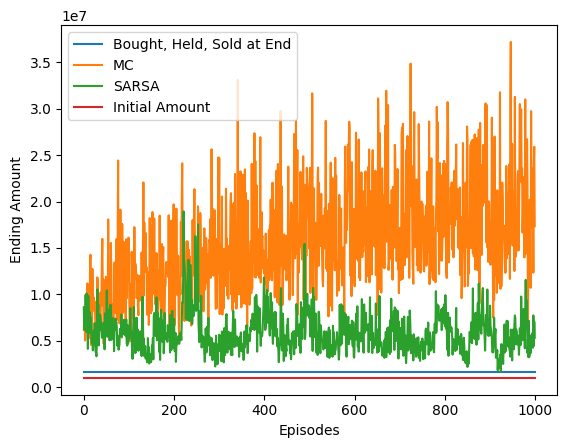

In [22]:
# MC TRAINING PLOT
mc_all_episode_rewards = []
for episode in mc_train_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    mc_all_episode_rewards.append(episode_rewards)
        

mc_final_amounts = [rewards[-1] for rewards in mc_all_episode_rewards]

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), mc_final_amounts, label='MC')
plt.plot(list(range(EPISODES)), sarsa_final_amounts, label='SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

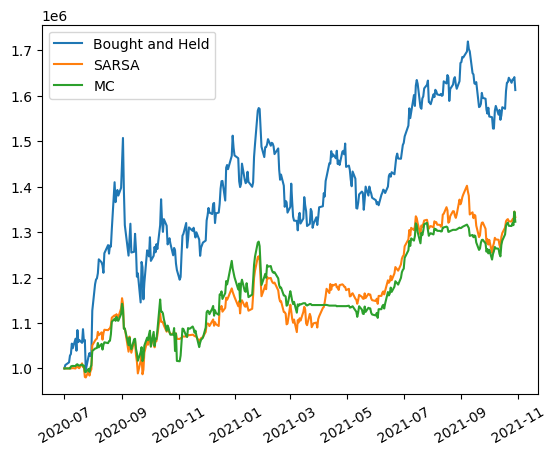

In [23]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
sarsa_test_values = sarsa_test_env.asset_memory
plt.plot(dates, sarsa_test_values, label="SARSA")
mc_test_values = mc_test_env_post.asset_memory
plt.plot(dates, mc_test_values, label="MC")
plt.xticks(rotation=30)
plt.legend()
plt.show()


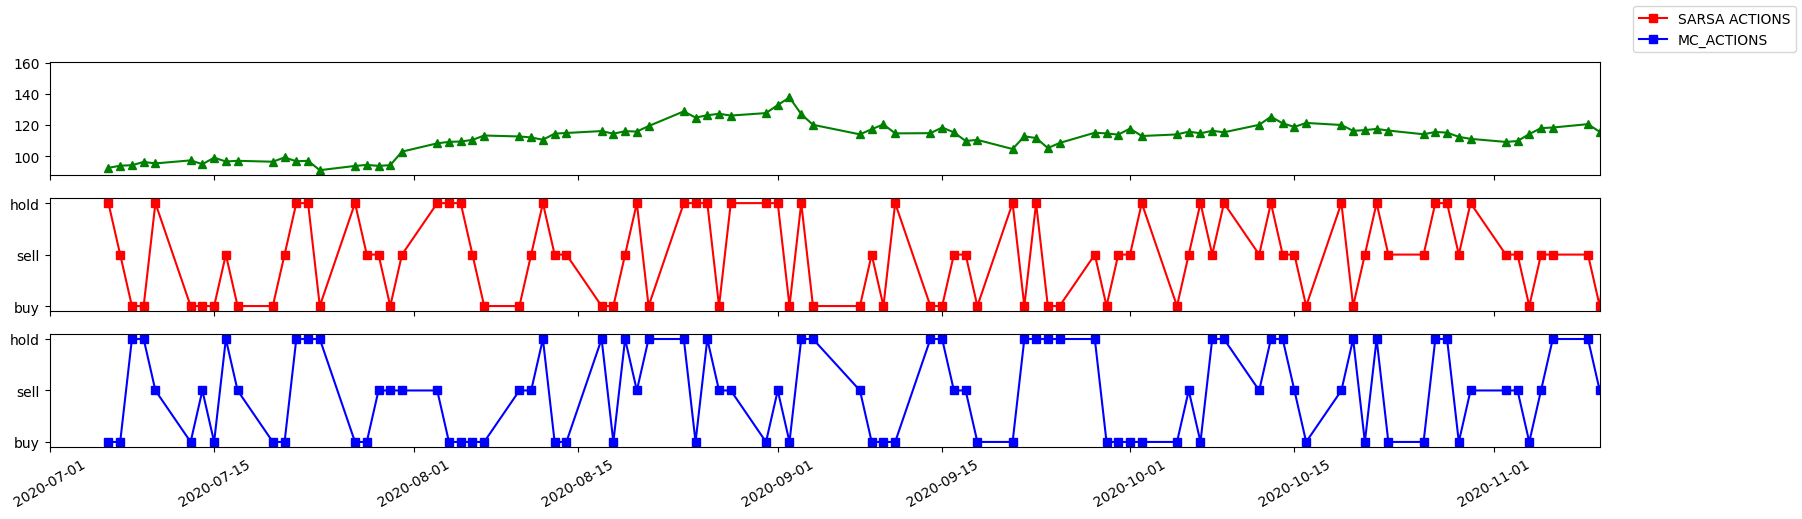

In [24]:
# ACTIONS OVER TEST
sarsa_test_actions = []
mc_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in sarsa_test_episode[0]:
    action = step[1]
    sarsa_test_actions.append(action)
for step in mc_test_episode[0]:
    action = step[1]
    mc_test_actions.append(action)
fig, axs = plt.subplots(nrows=3, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, sarsa_test_actions, marker = 's', label = 'SARSA ACTIONS', c='r')
axs[2].plot(action_dates, mc_test_actions, marker = 's', label= 'MC_ACTIONS', c='b')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])

#### State space should be the same for normal and aggressive

In [25]:
seen = len(sarsa_test_Q.keys())
unseen = 0
for state in sarsa_test_Q.keys():
    if state not in sarsa_Q.keys():
        unseen += 1
print(f"States seen in training: {seen}")
print(f"New States seen in Test: {unseen}")
print(f"Length of training episodes: {len(sarsa_training_episodes[0])}")
print(f"Length of test episode: {len(sarsa_test_episode[0])}")

States seen in training: 3092
New States seen in Test: 0
Length of training episodes: 2891
Length of test episode: 335


In [26]:
from collections import Counter

states_visited_in_single_test_episode = []
# episode.append((S, A, reward, percent))
for step in sarsa_training_episodes[0]:
    state = step[0]
    states_visited_in_single_test_episode.append(state)
"""
def convert_prices_to_discrete_state(prev_data_df: pd.DataFrame, current_data_df: pd.DataFrame) -> Tuple:
    # if prev_data_df['tic'].tolist() == current_data_df['tic'].tolist():
    # for x, y in zip(prev_data_df['tic'].tolist(), current_data_df['tic'].tolist()):
    #    print(x == y)
    # raise IndexError("Dfs are wrong")
    percent_diffs = ((current_data_df['open'].to_numpy() - prev_data_df['open'].to_numpy()) / prev_data_df['open'].to_numpy()) * 100
    discrete = []
    for dif in percent_diffs:
        if dif > 5:
            discrete.append(0)
        elif 5 > dif > 0:
            discrete.append(1)
        elif 0 > dif > -5:
            discrete.append(2)
        elif -5 > dif:
            discrete.append(3)
        else:
            discrete.append(4)
    return tuple(discrete)
"""
for s, count in Counter(states_visited_in_single_test_episode).most_common(5):
    print(f"STATE: {s}\nCOUNT: {count}\n")

STATE: (2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
COUNT: 28

STATE: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
COUNT: 27

STATE: (2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
COUNT: 6

STATE: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1)
COUNT: 5

STATE: (2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
COUNT: 5
